# Load Station Status Stream Files

In [119]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math

import seaborn as sns
sns.set()

In [120]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [121]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [130]:
def load_status_data():

    print('Loading Status Data...')
    file_path_slug = '../streamed_data/*/*station_status*.csv'

    # glob all files
    file_list = glob(file_path_slug)

    status_import = pd.DataFrame()
    chunks = []
    counter = 0
    
    print('Started Import (%s files to load)...' % len(file_list))

    # load data from each file
    for file in file_list:
        try:

            # import file in chunks
            chunk = pd.read_csv(file)

            # add program id to chunk
            chunk['program_id'] = str(file).split('/')[2]

            # append chunk to chunks list
            chunks.append(chunk)
            
            counter += 1
            if counter == 1 or counter % math.ceil(len(file_list)/10) == 0 or counter == len(file_list):
                print('\tFinished file! (%d of %d)' % (counter, len(file_list)))        
        except:
            print(file)

    status_import = pd.concat(chunks)
    print('Data Loaded Successfully!\n')

    program_list = sorted(pd.unique(status_import.program_id))
    print('Started cleaning (%s programs to clean)...' % len(program_list))
    status_import.rename(columns={'last_reported' : 'time',
                                     'eightd_has_available_keys' : 'has_available_keys',
                                     'is_installed' : 'is_installed',
                                     'is_renting' : 'is_renting',
                                     'is_returning' : 'is_returning',
                                     'num_bikes_available' : 'bikes_available',
                                     'num_bikes_disabled' : 'bikes_disabled',
                                     'num_docks_available' : 'docks_available',
                                     'num_docks_disabled' : 'docks_disabled',
                                     'station_id' : 'station_id'}, inplace=True)

    drop_cols = ['eightd_active_station_services', 'has_available_keys', 'is_installed', 'is_renting', 'is_returning', 'bikes_disabled', 'docks_disabled', 'renting', 'returning', 'installed']

    for c in drop_cols:
        try:
            status_import.drop(c, axis=1, inplace=True)
        except:
            pass

    # convert time to datetime, and prune entries pre 2000, some epoch dates are being reported
    status_import['time'] = pd.to_datetime(status_import['time'], format="%Y-%m-%d %H:%M:%S")
    change_date = pd.Timestamp('2000-01-01 00:00')
    status_import = status_import[status_import.time >= change_date]

    status_import.sort_values(['program_id', 'station_id', 'time'], inplace=True)
    
    A = len(status_import)
    status_import.drop_duplicates(subset=['time', 'program_id', 'station_id'], inplace=True)
    B = len(status_import)
    print('\t\tDropped %s duplicates!' % (A-B))
    
    # by program and station ,append dock change and bike change
    cleaned_df = pd.DataFrame()
    cleaned_list = []
    counter = 1
    for pid in program_list:

        df_temp_program = status_import[status_import.program_id == pid].copy()

        # for each dock
        print('%s\t%s - %s Stations to Clean...' % (str(counter).rjust(3), pid.ljust(25), str(len(pd.unique(df_temp_program.station_id))).rjust(4)))
        for sid in pd.unique(df_temp_program.station_id):
            df_temp_station = df_temp_program[df_temp_program.station_id == sid].copy()
            
            # drop duplicates
            A = len(df_temp_station)
            df_temp_station.drop_duplicates(subset='time', inplace=True)
            B = len(df_temp_station)
            if A != B:
                print('\t%s\tDropped %s duplicates!' % (sid, (A-B)))
            
            df_temp_station.sort_values(['time'], inplace=True)

            df_temp_station['bike_change'] = df_temp_station['bikes_available'].diff()
            df_temp_station['bike_change'] = df_temp_station['bike_change'].apply(lambda x: 1 if x > 0 else 0)

            df_temp_station['trips_ending'] = df_temp_station['bikes_available'].diff()
            df_temp_station['trips_ending'] = df_temp_station['trips_ending'].apply(lambda x: x if x > 0 else 0)

            df_temp_station['dock_change'] = df_temp_station['docks_available'].diff()
            df_temp_station['dock_change'] = df_temp_station['dock_change'].apply(lambda x: 1 if x > 0 else 0)

            df_temp_station['trips_starting'] = df_temp_station['docks_available'].diff()
            df_temp_station['trips_starting'] = df_temp_station['trips_starting'].apply(lambda x: x if x > 0 else 0)
            
            df_temp_station['net_traffic'] = df_temp_station['trips_starting'] - df_temp_station['trips_ending']

            cleaned_list.append(df_temp_station)
            

        counter += 1

    print('Merging DataFrame...')
    cleaned_df = pd.concat(cleaned_list)
    cleaned_df.reset_index(inplace=True, drop=True)

    print('Cleaning Complete!')

    return cleaned_df


In [ ]:
status_data = load_status_data()

Loading Status Data...
Started Import (6626 files to load)...
	Finished file! (1 of 6626)
	Finished file! (663 of 6626)
	Finished file! (1326 of 6626)
	Finished file! (1989 of 6626)
	Finished file! (2652 of 6626)
	Finished file! (3315 of 6626)
	Finished file! (3978 of 6626)
	Finished file! (4641 of 6626)
	Finished file! (5304 of 6626)
	Finished file! (5967 of 6626)
	Finished file! (6626 of 6626)
Data Loaded Successfully!

Started cleaning (70 programs to clean)...
		Dropped 758451 duplicates!
  1	aru                       -    8 Stations to Clean...
  2	asp                       -   21 Stations to Clean...
  3	ba                        -  249 Stations to Clean...
  4	bcyclearborbike           -   13 Stations to Clean...
  5	bcycleaustin              -   54 Stations to Clean...
  6	bcycleaventura            -    5 Stations to Clean...
  7	bcyclebattlecreek         -    4 Stations to Clean...
  8	bcycleboulder             -   43 Stations to Clean...
  9	bcyclebroward             -   24 S

In [ ]:
status_data.info()

In [133]:
status_data.head(20)

time  bikes_available  docks_available program_id  \
0  2017-11-15 21:28:17                8               18        aru   
1  2017-11-15 21:32:42                8               18        aru   
2  2017-11-15 21:41:26                8               18        aru   
3  2017-11-15 21:45:52                8               18        aru   
4  2017-11-15 21:50:21                8               18        aru   
5  2017-11-15 21:59:08                8               18        aru   
6  2017-11-15 22:07:56                8               18        aru   
7  2017-11-15 22:12:16                8               18        aru   
8  2017-11-15 22:21:04                8               18        aru   
9  2017-11-15 22:25:27                8               18        aru   
10 2017-11-15 22:29:52                8               18        aru   
11 2017-11-15 22:38:43                8               18        aru   
12 2017-11-15 22:43:02                8               18        aru   
13 2017-11-15 22:51:50                8               18        aru   
14 2017-11-15 22:56:13                8               18        aru   
15 2017-11-15 23:04:59                8               18        aru   
16 2017-11-15 23:09:24                8               18        aru   
17 2017-11-15 23:13:43                8               18        aru   
18 2017-11-15 23:22:32                8               18        aru   
19 2017-11-15 23:26:56                8               18        aru   

   station_id  bike_change  trips_ending  dock_change  trips_starting  \
0           1            0           0.0            0             0.0   
1           1            0           0.0            0             0.0   
2           1            0           0.0            0             0.0   
3           1            0           0.0            0             0.0   
4           1            0           0.0            0             0.0   
5           1            0           0.0            0             0.0   
6           1            0           0.0            0             0.0   
7           1            0           0.0            0             0.0   
8           1            0           0.0            0             0.0   
9           1            0           0.0            0             0.0   
10          1            0           0.0            0             0.0   
11          1            0           0.0            0             0.0   
12          1            0           0.0            0             0.0   
13          1            0           0.0            0             0.0   
14          1            0           0.0            0             0.0   
15          1            0           0.0            0             0.0   
16          1            0           0.0            0             0.0   
17          1            0           0.0            0             0.0   
18          1            0           0.0            0             0.0   
19          1            0           0.0            0             0.0   

    net_traffic  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
5           0.0  
6           0.0  
7           0.0  
8           0.0  
9           0.0  
10          0.0  
11          0.0  
12          0.0  
13          0.0  
14          0.0  
15          0.0  
16          0.0  
17          0.0  
18          0.0  
19          0.0

In [134]:
status_data[status_data.trips_starting == status_data.trips_starting.max()]
# status_data.iloc[133530:133540,:]

time  bikes_available  docks_available program_id  \
1304471 2017-11-14 08:29:59                3               36        nyc   

        station_id  bike_change  trips_ending  dock_change  trips_starting  \
1304471        116            0           0.0            1            27.0   

         net_traffic  
1304471         27.0

In [135]:
def show_station(df, id, x_label = '', y_label = '', title_suffix='', color='b', col='bikes_available'):
    t = df[df.station_id == id]
    t.set_index('time', inplace=True)
    ax = t[col].cumsum().plot(color=color, figsize=(24,3))
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.show()

In [136]:
def plot_hourly_usage(df, title='CoGo', color='r'):
    
    try:
        df.sort_values('time', inplace=True)
        x_ticks = sorted(pd.unique(df.time.dt.hour))
        df_data = df[df.bike_change != 0]
        df_data.reset_index(inplace=True, drop=True)
        df_status_change = df_data.groupby([df_data.time.dt.hour])['station_id'].count()

        plt.subplots(figsize=(24,3))
        ax = sns.barplot(x = df_status_change.index , y = df_status_change, color=color, alpha = 0.25, label=title)
        ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
        ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
        ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
        ax.set_xticks(x_ticks)
        plt.legend()
        plt.show()
    except:
        print('Unable to plot %s' % title)

In [73]:
def resample_status(df, interval='5T', verbose=False):
    if verbose:
        print('[%s] Resampling on interval' % datetime.datetime.now().time())
    
    resampled_list = []
    
    for pid in pd.unique(df.program_id):

            df_temp = df[df.program_id == pid].copy()
            
            df_temp.set_index(['station_id', 'time'], inplace=True)

            # resample on 5 minute interval mean
            df_temp = df_temp.groupby([pd.Grouper(level=0), pd.Grouper(freq=interval, level=-1)]).mean()
            df_temp.reset_index(inplace=True)
            
            df_temp['program_id'] = pid
         
            resampled_list.append(df_temp)

    resampled_df = pd.concat(resampled_list)
    resampled_df.reset_index(inplace=True, drop=True)
    
    if verbose:
        print('[%s] Complete' % datetime.datetime.now().time())
    return resampled_df

aru - (2017-11-15 21:28:17 to 2017-11-15 23:36:20)
Unable to plot aru
asp - (2017-11-15 18:27:54 to 2017-11-15 20:36:58)


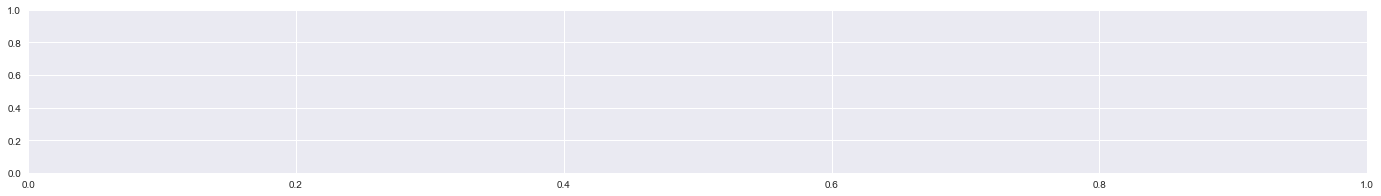

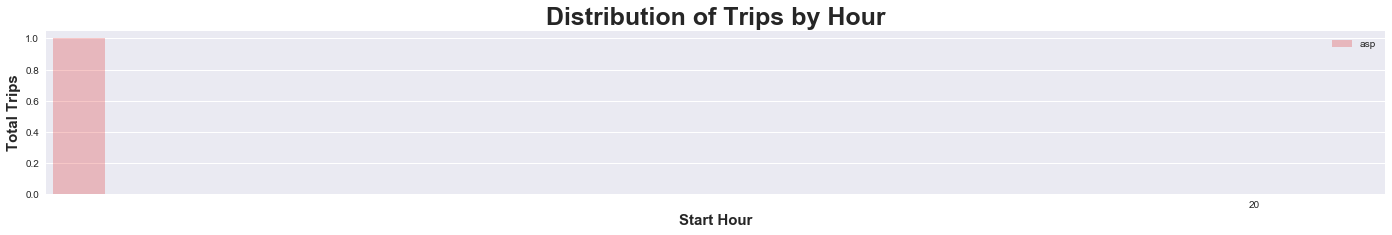

ba - (2017-11-07 19:21:00 to 2017-11-15 19:35:57)


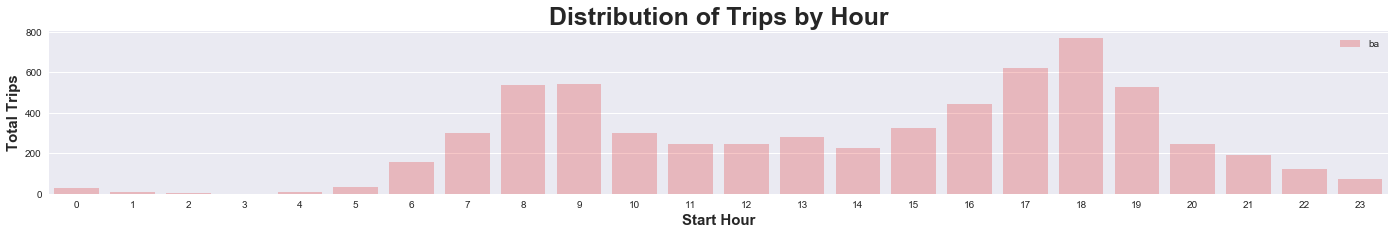

bcyclearborbike - (2017-11-13 17:55:49 to 2017-11-15 22:36:23)


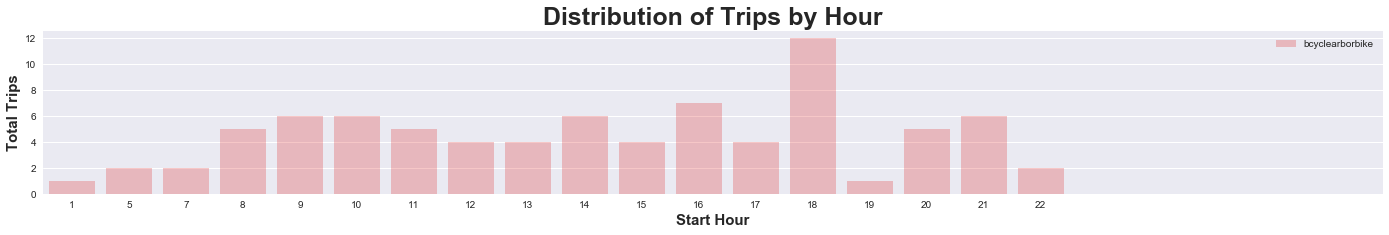

bcycleaustin - (2017-11-13 16:55:18 to 2017-11-15 21:35:30)


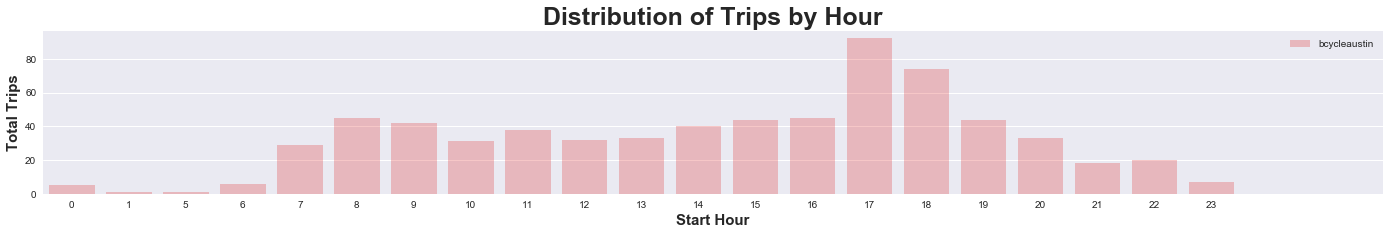

bcycleaventura - (2017-11-13 17:55:50 to 2017-11-15 22:36:25)


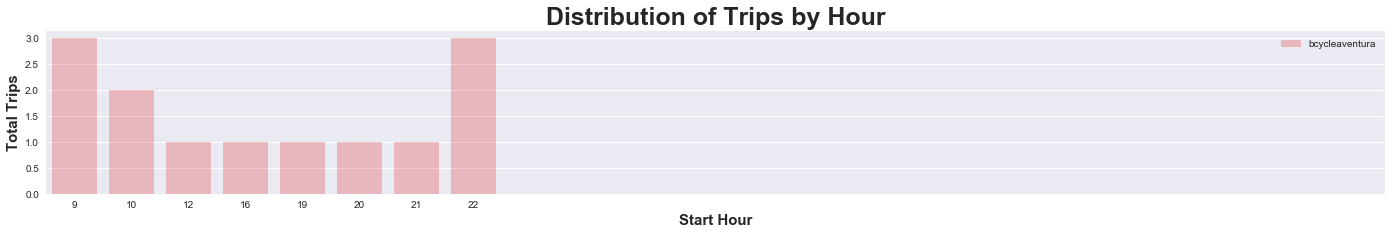

bcyclebattlecreek - (2017-11-13 17:55:51 to 2017-11-15 22:36:28)
Unable to plot bcyclebattlecreek
bcycleboulder - (2017-11-13 15:55:13 to 2017-11-15 20:35:40)


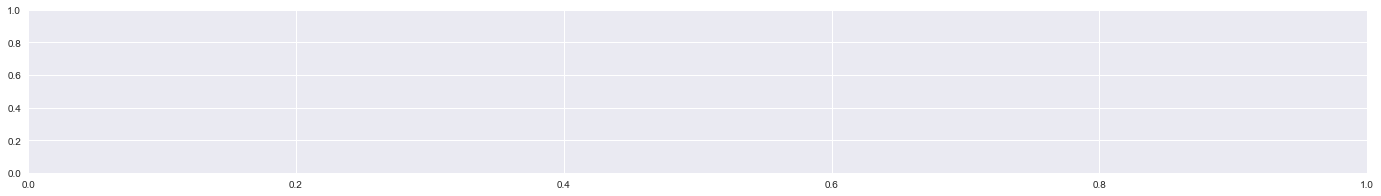

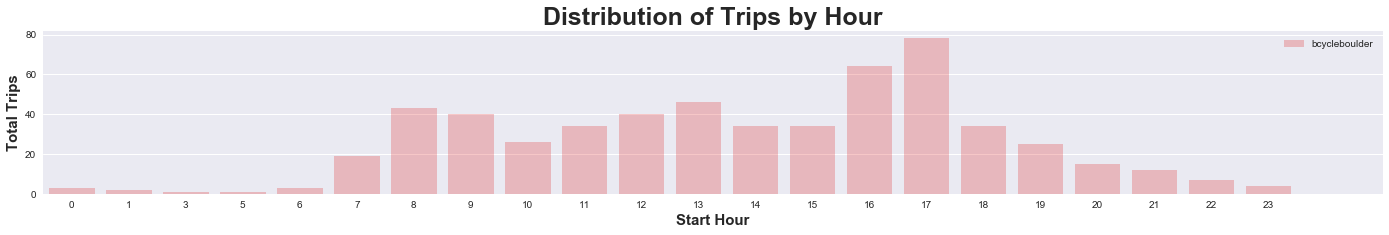

bcyclebroward - (2017-11-13 17:55:52 to 2017-11-15 22:36:28)


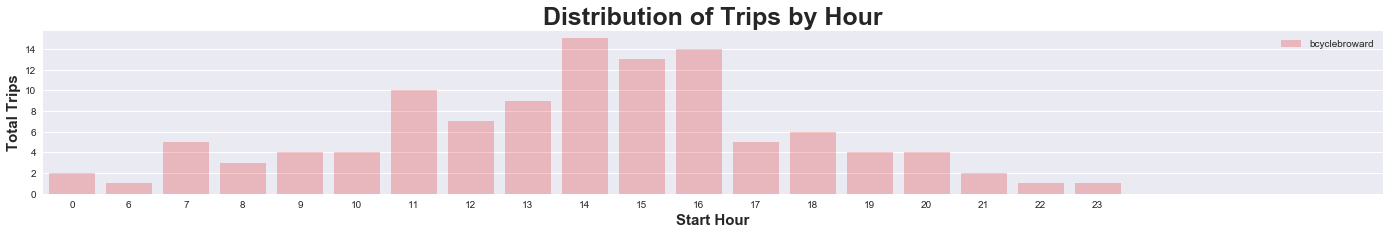

bcyclebublr - (2017-11-13 16:55:20 to 2017-11-15 21:35:45)


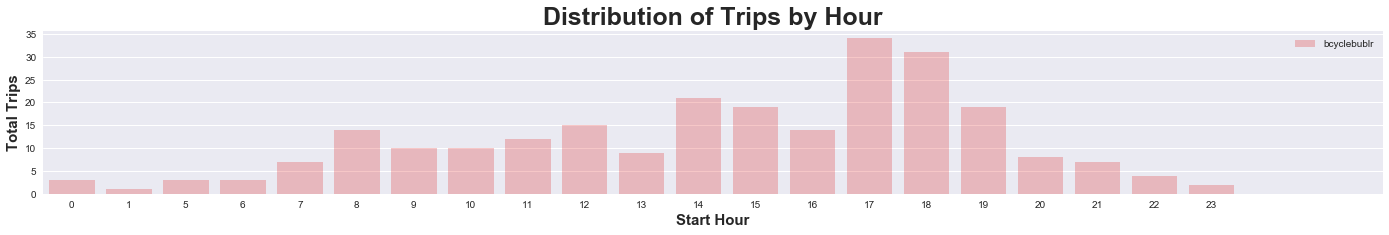

bcyclecatbike - (2017-11-13 17:56:06 to 2017-11-15 22:36:47)


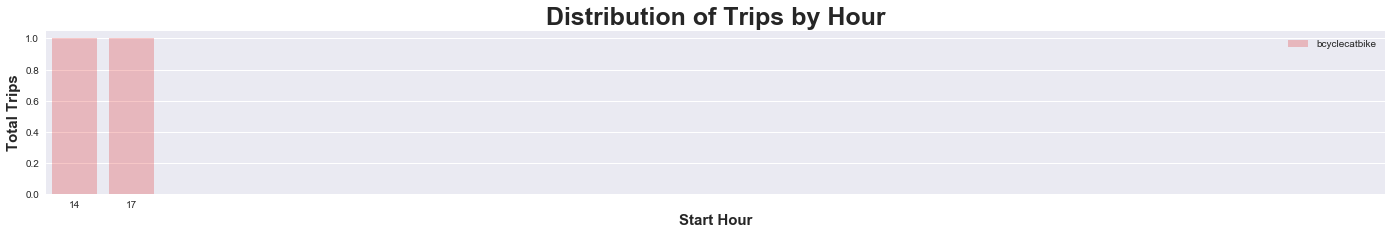

bcyclecharlotte - (2017-11-13 17:55:53 to 2017-11-15 22:36:30)


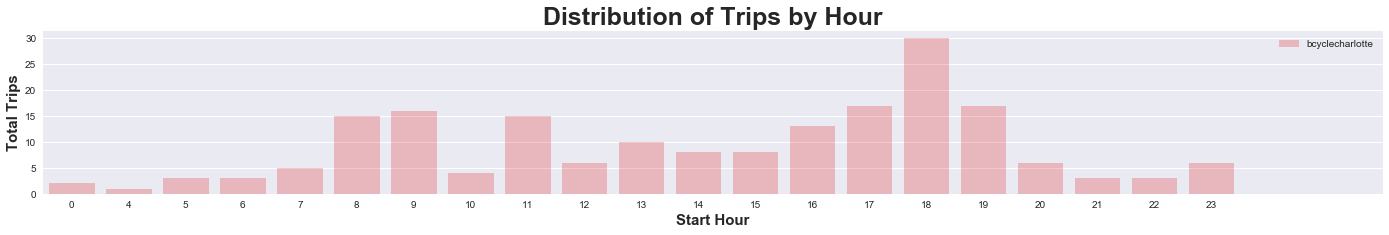

bcyclecincyredbike - (2017-11-13 17:55:54 to 2017-11-15 22:36:31)


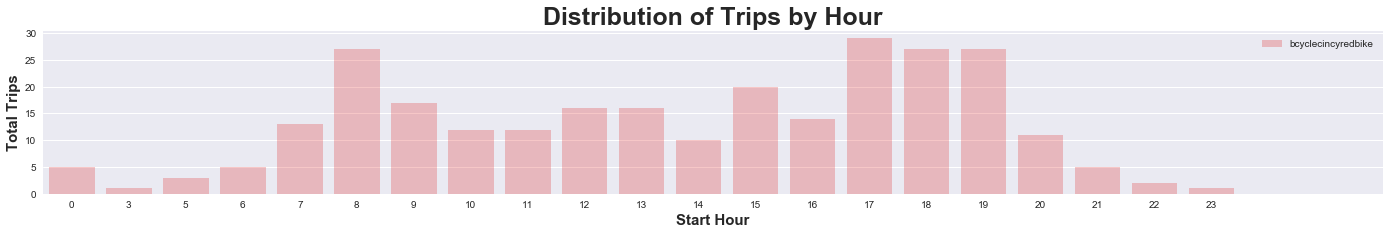

bcycleclarksville - (2017-11-13 16:55:21 to 2017-11-15 21:35:48)


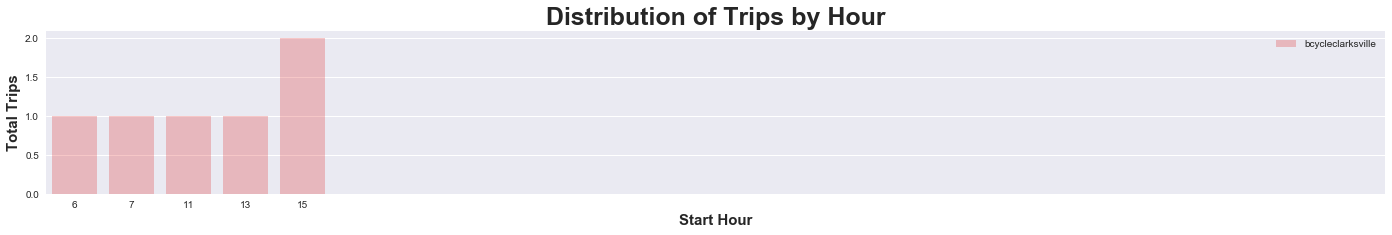

bcycleclemson - (2017-11-13 17:55:55 to 2017-11-15 22:36:33)


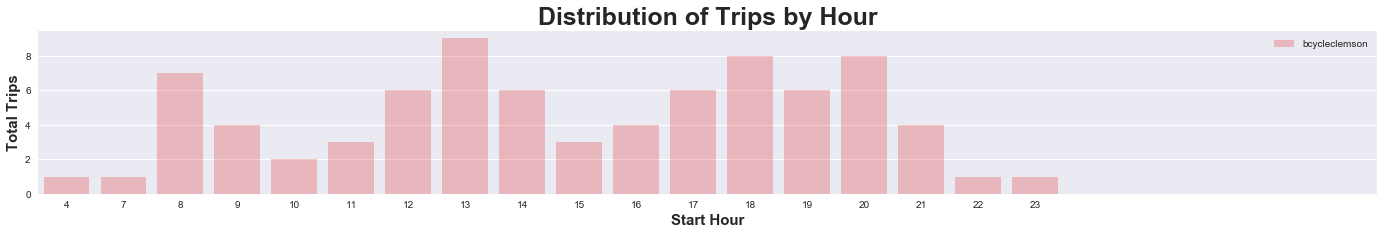

bcyclecolumbiacounty - (2017-11-13 17:55:58 to 2017-11-15 22:36:38)


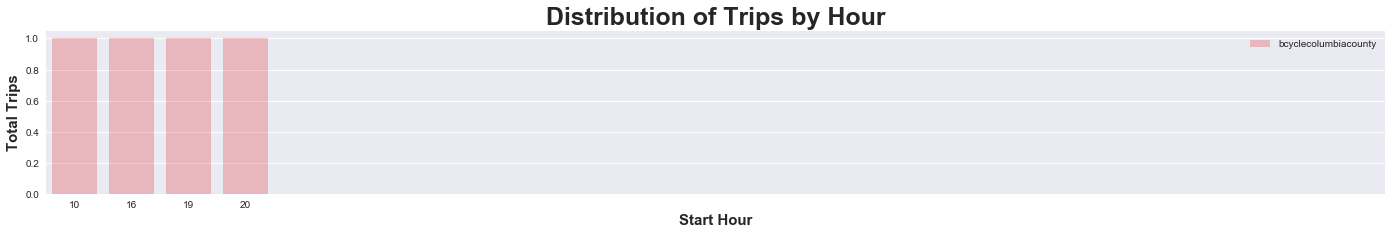

bcyclecolumbike - (2017-11-13 17:55:47 to 2017-11-15 22:36:20)


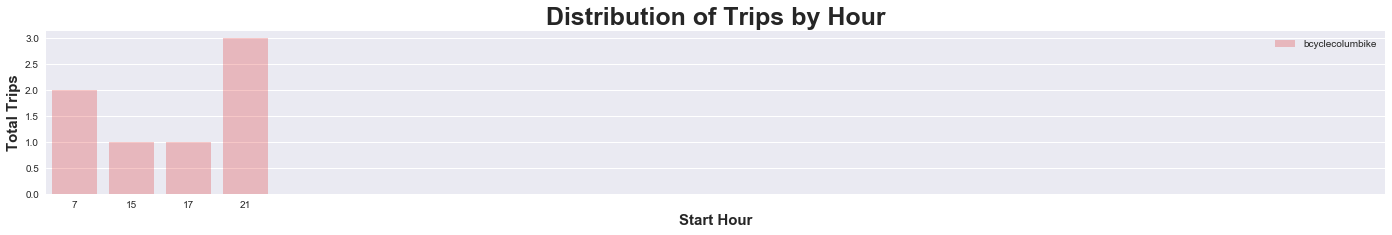

bcycledallasfairpark - (2017-11-13 16:55:21 to 2017-11-15 21:35:47)
Unable to plot bcycledallasfairpark
bcycledenver - (2017-11-13 15:54:41 to 2017-11-15 20:35:41)


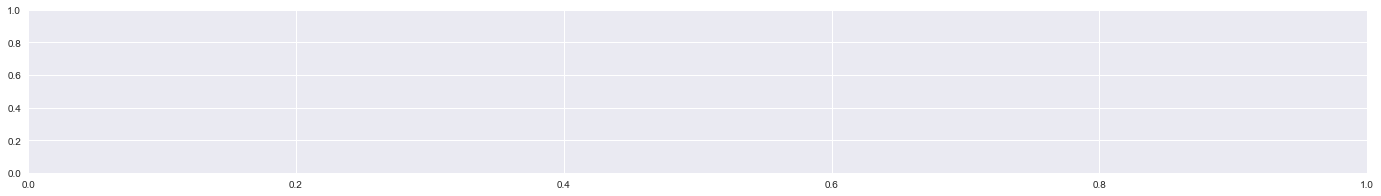

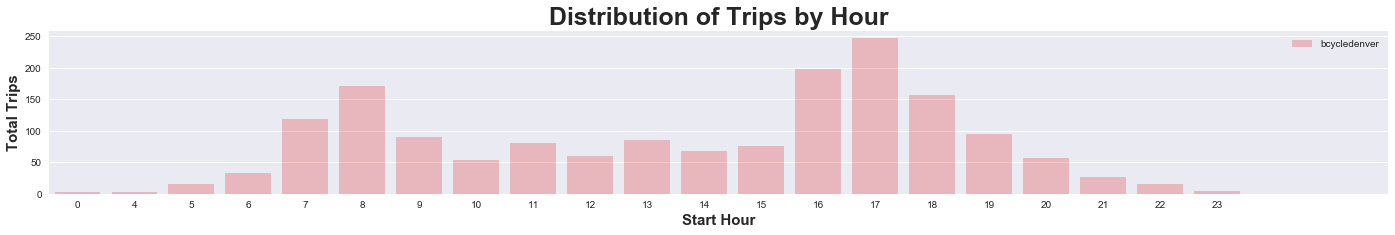

bcycledesmoines - (2017-11-13 16:55:22 to 2017-11-15 21:35:50)


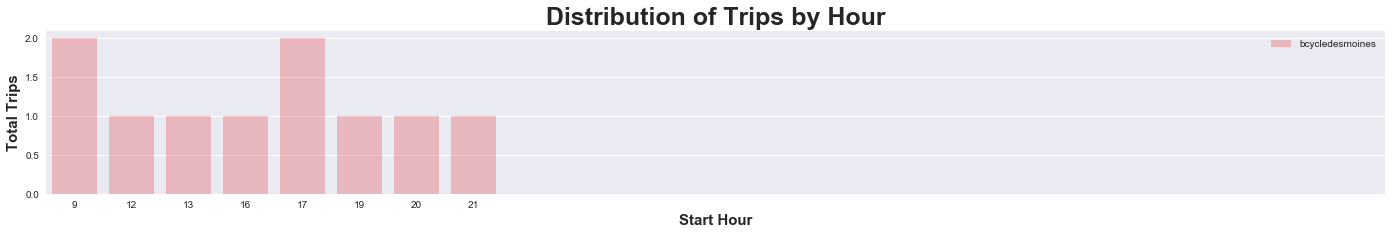

bcycleelpaso - (2017-11-13 16:55:23 to 2017-11-15 21:35:51)


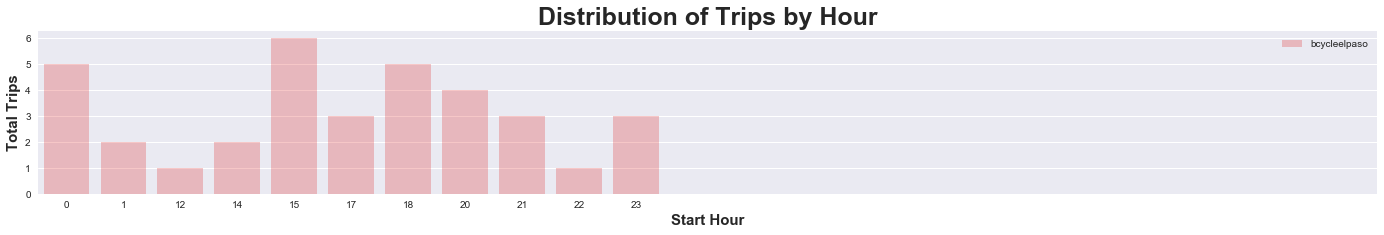

bcyclefortworth - (2017-11-13 16:55:25 to 2017-11-15 21:35:52)


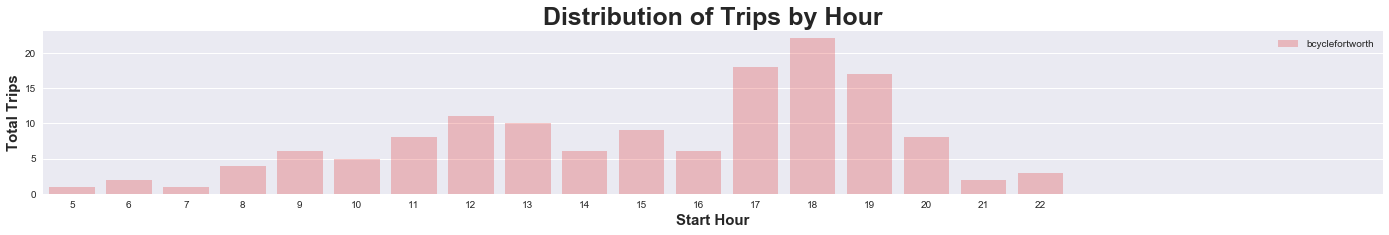

bcyclegreenbikeslc - (2017-11-13 15:55:15 to 2017-11-15 20:35:40)


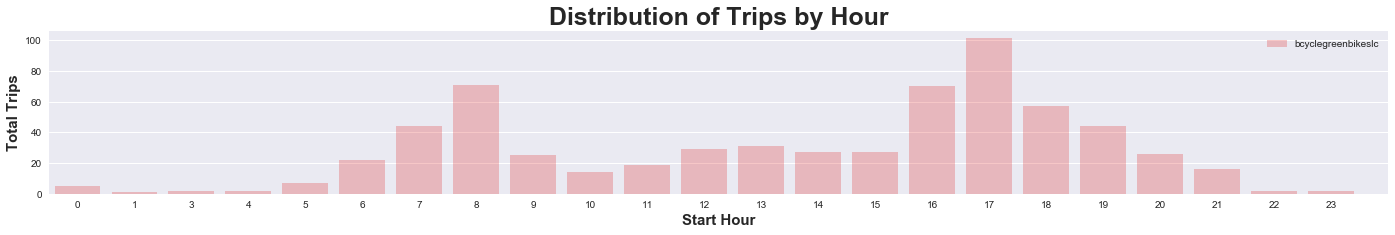

bcyclegreenville - (2017-11-13 17:55:59 to 2017-11-15 22:36:42)


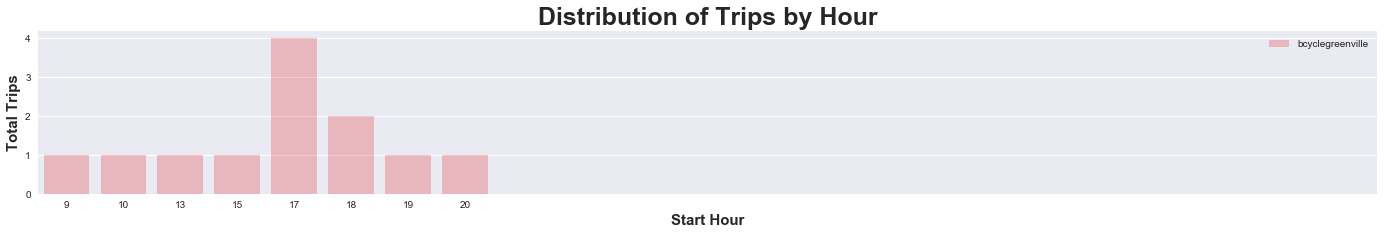

bcycleheartland - (2017-11-13 16:55:26 to 2017-11-15 21:35:54)


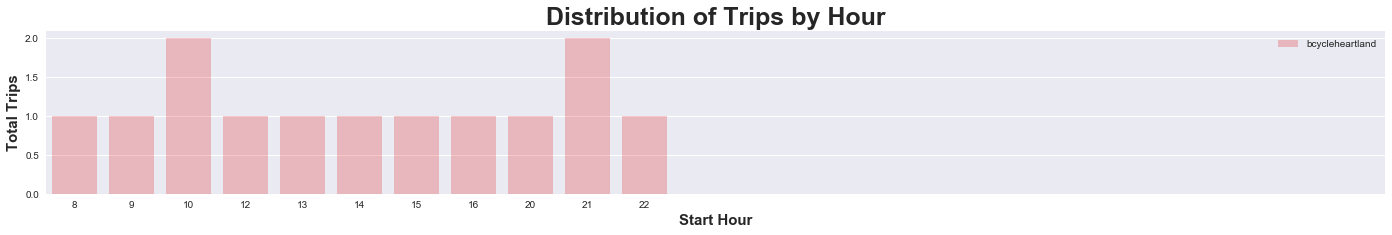

bcyclehouston - (2017-11-13 16:55:27 to 2017-11-15 21:35:35)


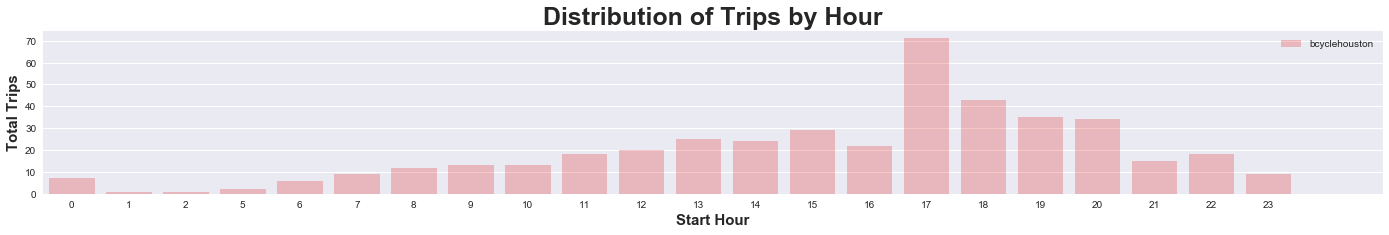

bcycleindego - (2017-11-13 17:56:00 to 2017-11-15 22:36:43)


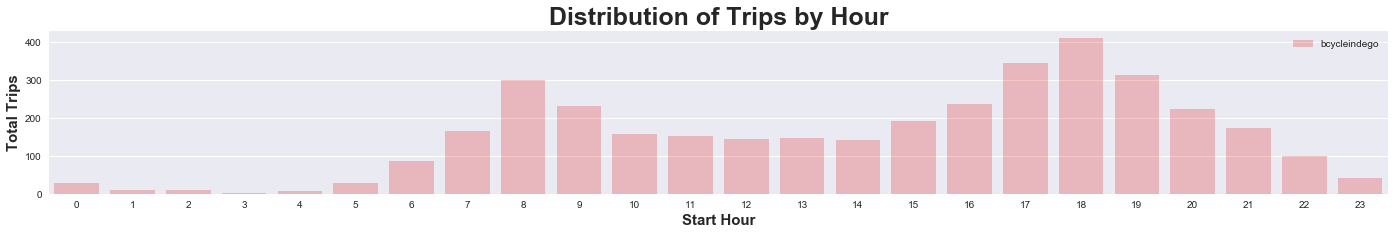

bcyclejacksoncounty - (2017-11-13 17:56:00 to 2017-11-15 22:36:43)
Unable to plot bcyclejacksoncounty
bcyclekc - (2017-11-13 16:55:28 to 2017-11-15 21:35:54)


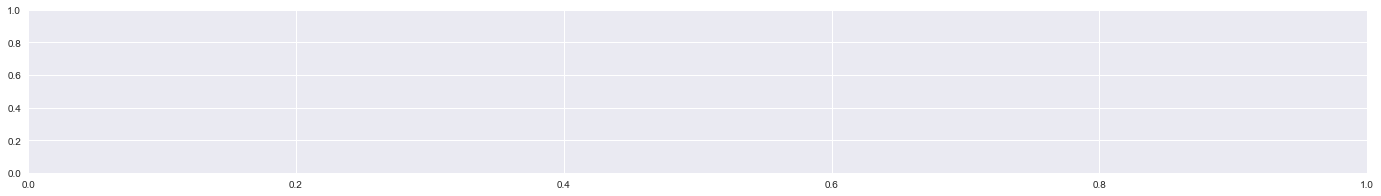

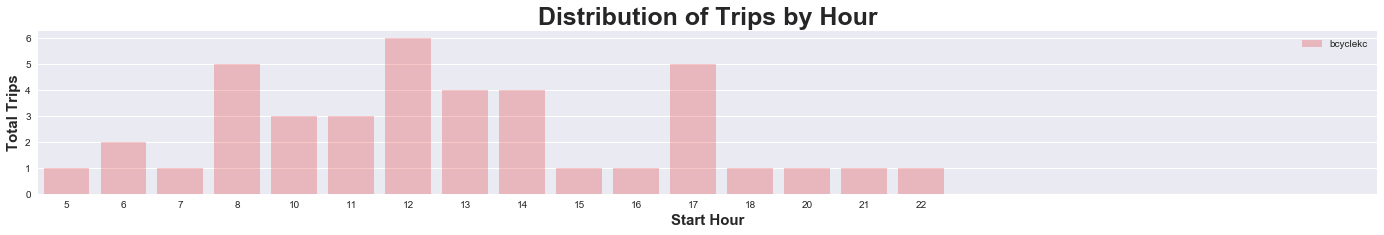

bcyclelametro - (2017-11-13 14:55:44 to 2017-11-15 19:35:54)


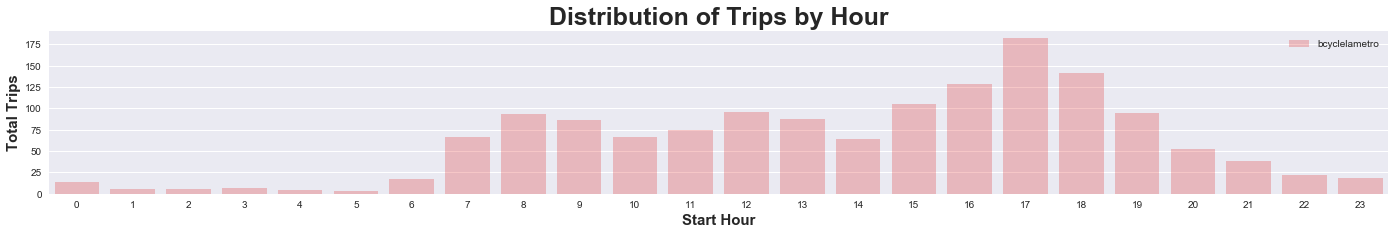

bcyclelinkdayton - (2017-11-13 17:56:03 to 2017-11-15 22:36:46)


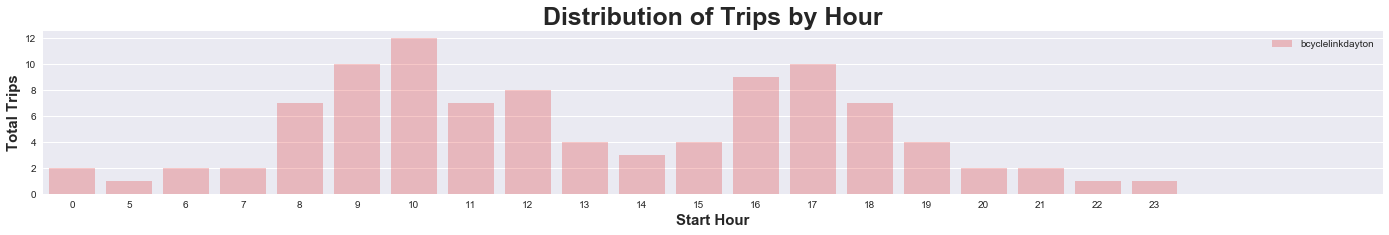

bcyclemadison - (2017-11-13 16:55:29 to 2017-11-15 21:35:58)


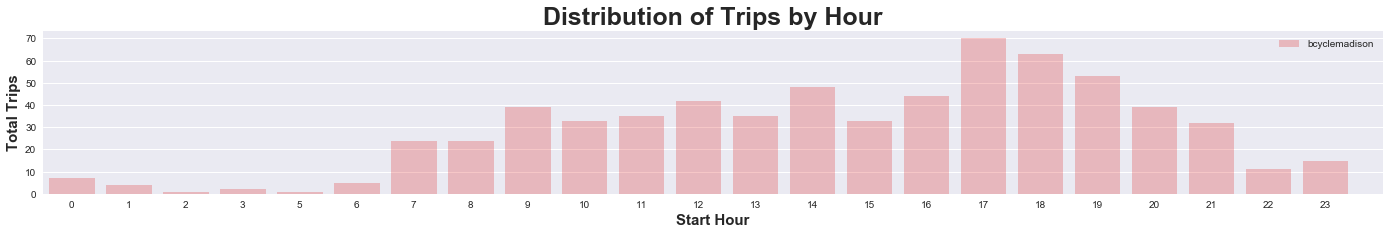

bcyclemcallen - (2017-11-13 16:55:30 to 2017-11-15 21:35:58)


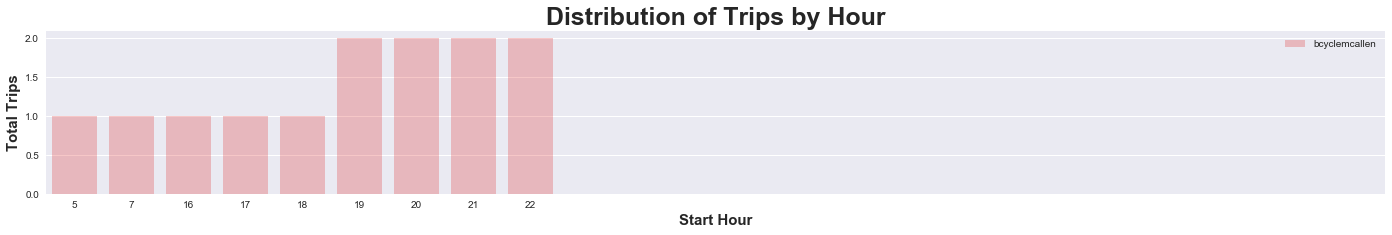

bcyclenashville - (2017-11-13 16:55:17 to 2017-11-15 21:35:44)


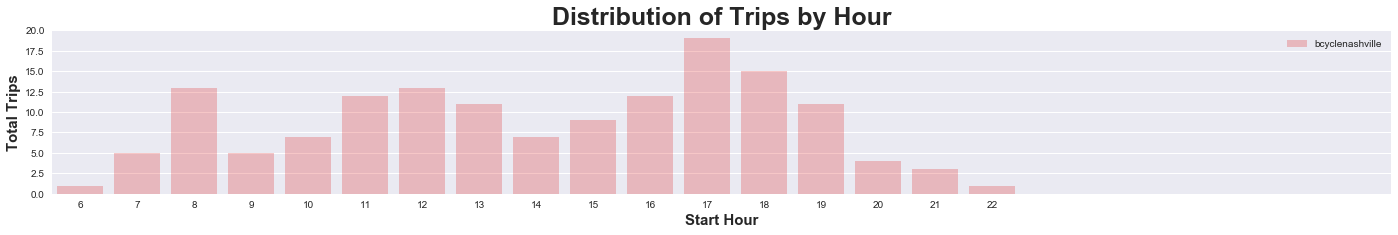

bcyclepacersbikeshare - (2017-11-13 17:55:48 to 2017-11-15 22:36:21)


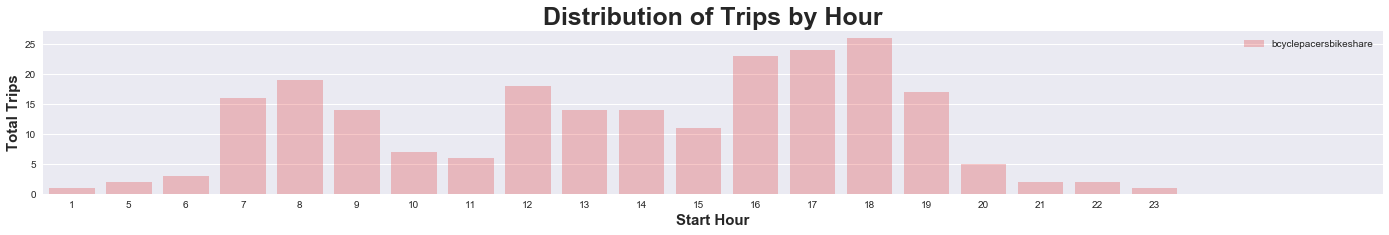

bcyclerapidcity - (2017-11-13 16:55:33 to 2017-11-15 21:36:05)
Unable to plot bcyclerapidcity
bcyclertcbikeshare - (2017-11-13 14:55:42 to 2017-11-15 19:36:16)


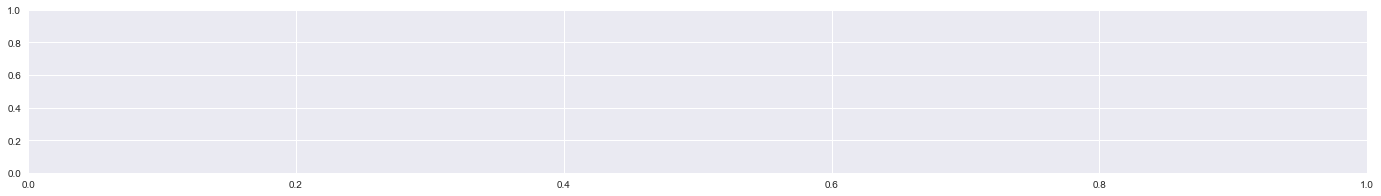

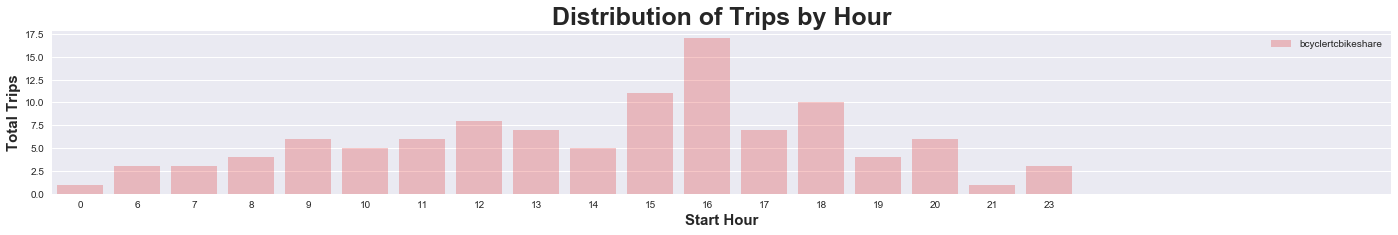

bcyclesanantonio - (2017-11-13 16:55:34 to 2017-11-15 21:36:06)


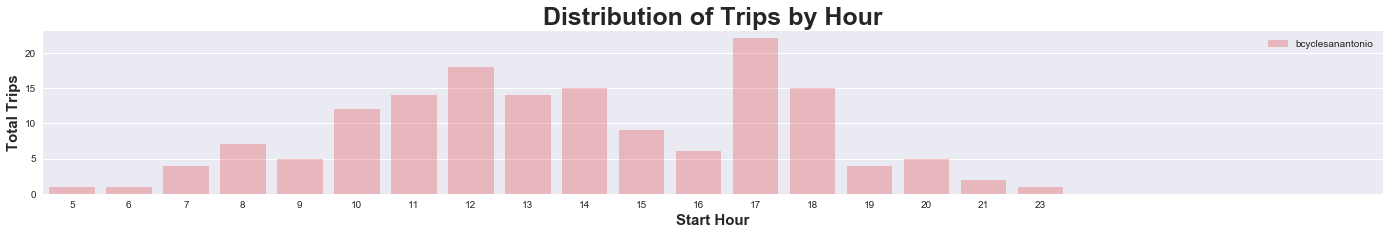

bcyclespartanburg - (2017-11-13 17:56:07 to 2017-11-15 22:36:51)


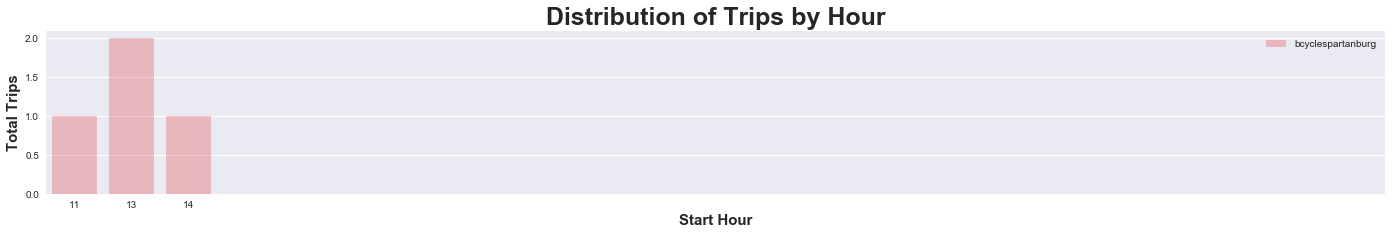

bcyclespokies - (2017-11-13 16:55:32 to 2017-11-15 21:36:04)


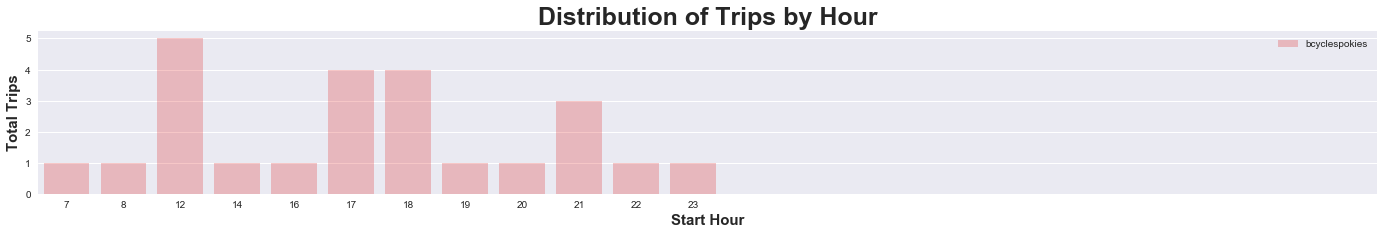

biketownpdx - (2017-11-13 14:55:39 to 2017-11-15 19:36:11)


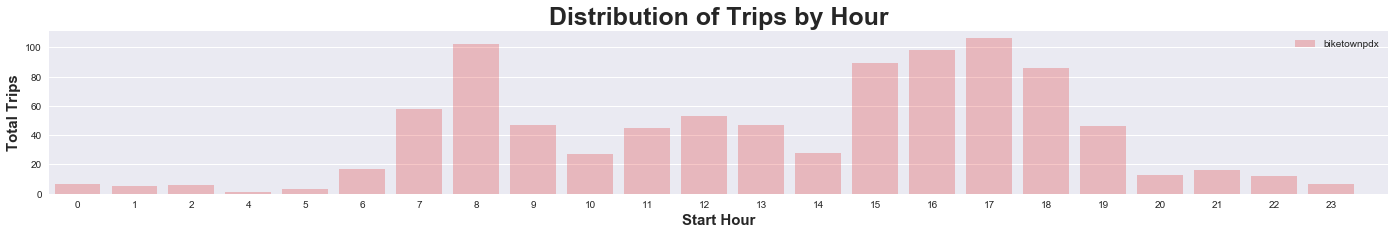

bishopranch - (2017-11-13 14:55:40 to 2017-11-15 19:36:12)


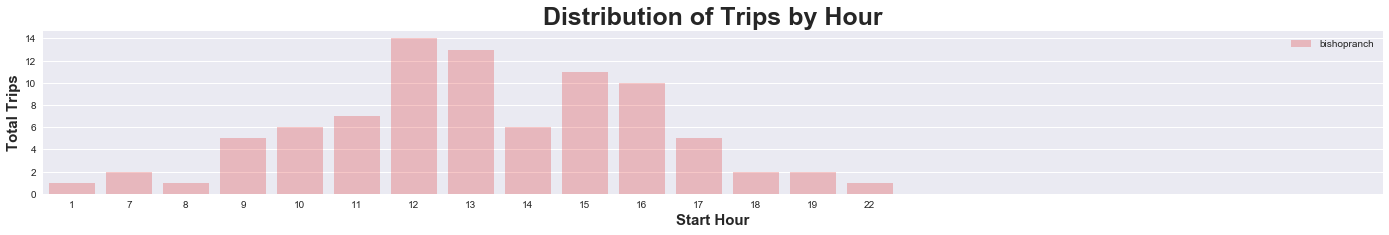

boisegreenbike - (2017-11-13 15:55:12 to 2017-11-15 20:35:38)


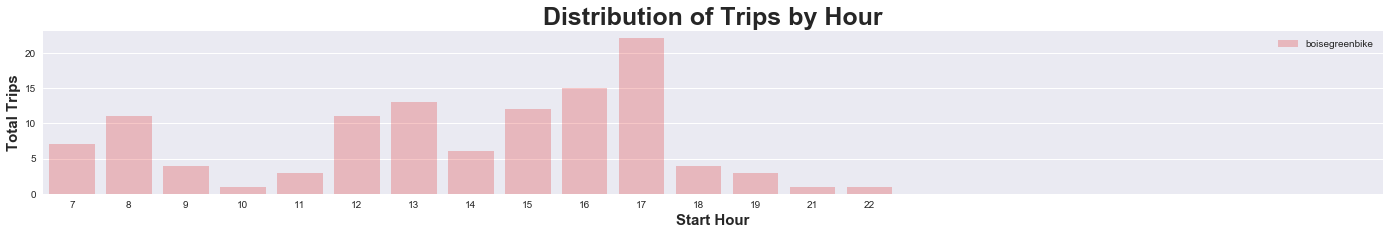

breezebikeshare - (2017-11-13 14:55:40 to 2017-11-15 19:36:13)


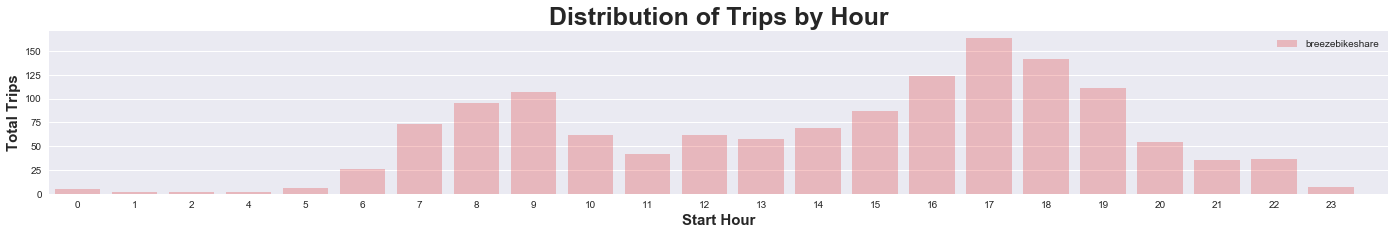

cabi - (2017-11-12 04:57:35 to 2017-11-15 22:36:38)


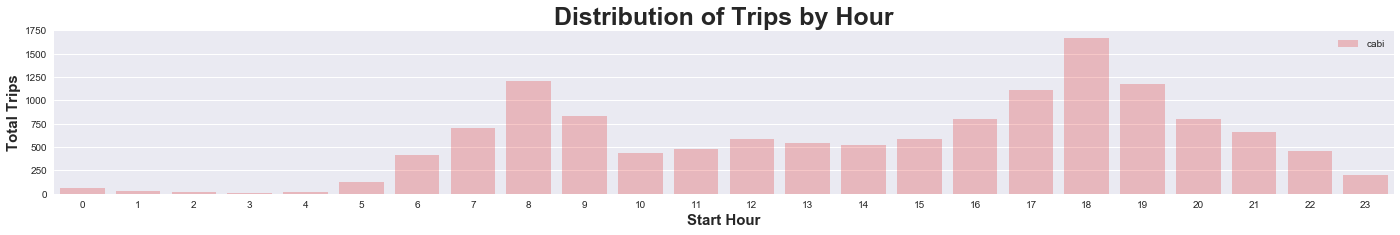

chat - (2017-11-15 19:27:21 to 2017-11-15 21:36:40)
Unable to plot chat
coastbikeshare - (2017-11-13 17:55:58 to 2017-11-15 22:36:38)


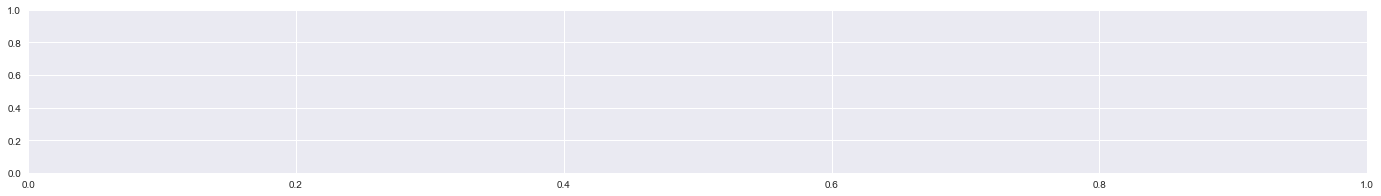

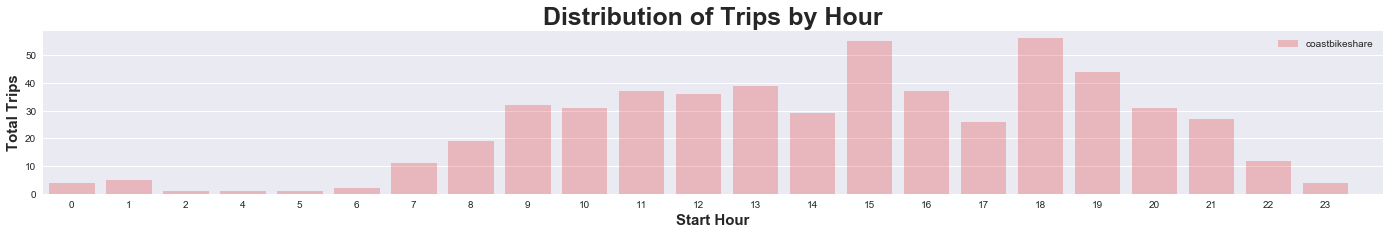

cogo - (2017-11-13 17:51:33 to 2017-11-15 22:36:38)


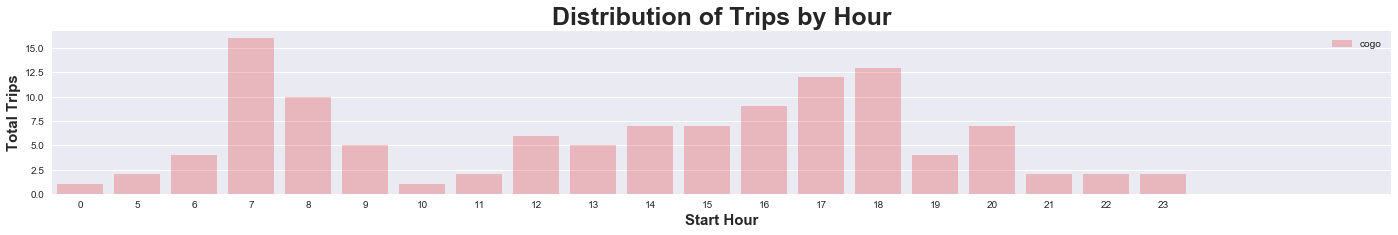

det - (2017-11-15 20:27:51 to 2017-11-15 22:36:59)


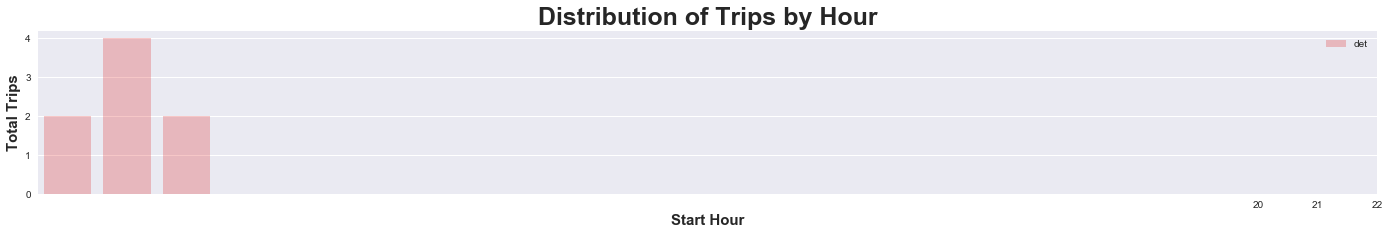

divvy - (2017-11-13 15:59:59 to 2017-11-15 21:36:01)


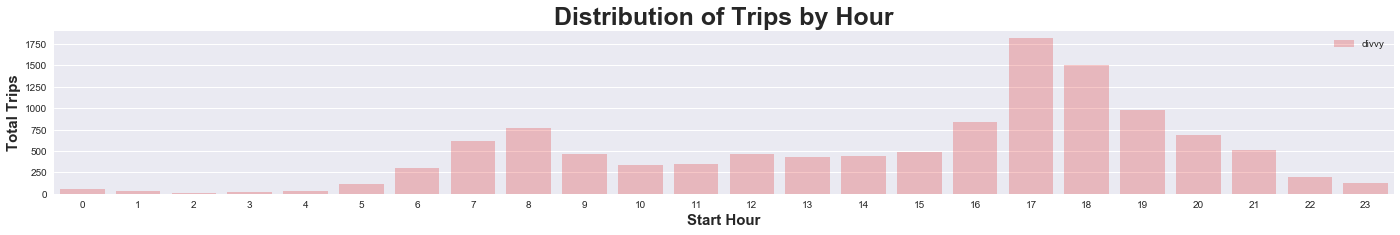

gridbikeshare - (2017-11-13 14:55:42 to 2017-11-15 19:36:15)


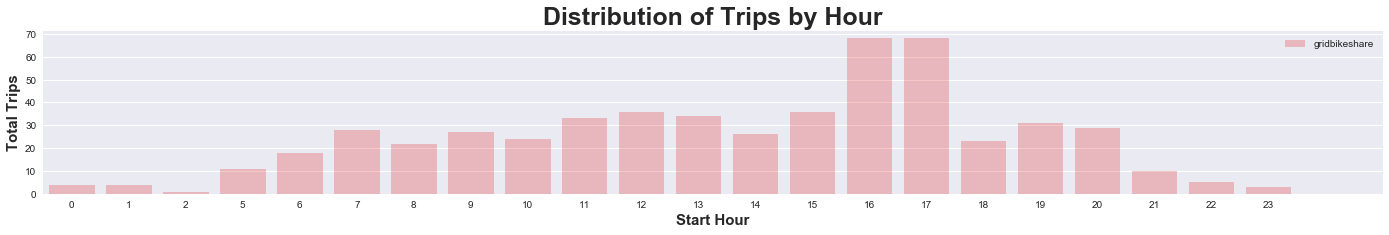

guad - (2017-11-15 19:17:46 to 2017-11-15 21:36:54)


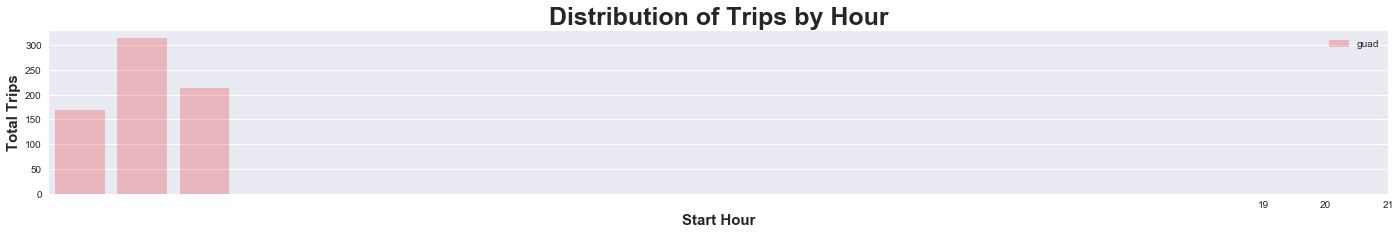

hon - (2017-11-15 15:26:59 to 2017-11-15 17:36:58)


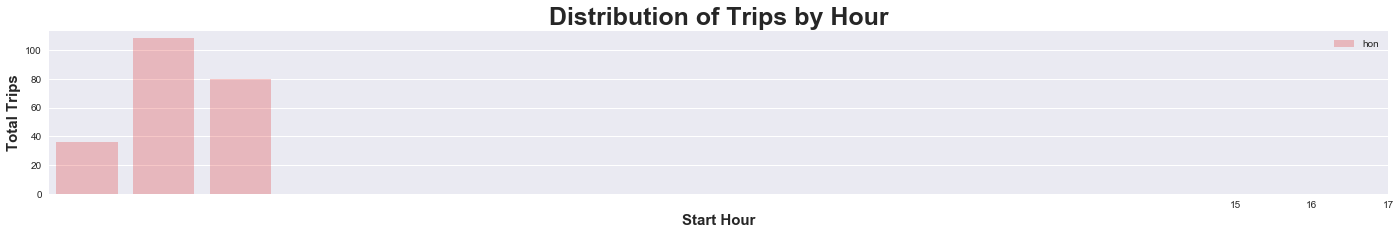

hubway - (2017-11-12 09:15:51 to 2017-11-15 22:35:53)


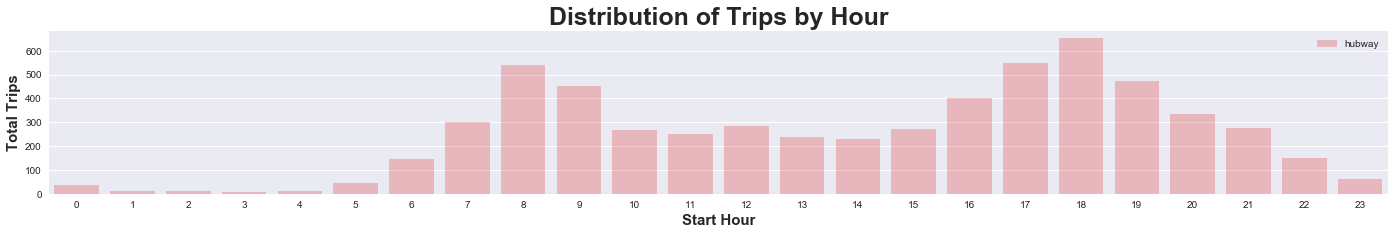

juicebikeshare - (2017-11-13 17:56:02 to 2017-11-15 22:36:43)


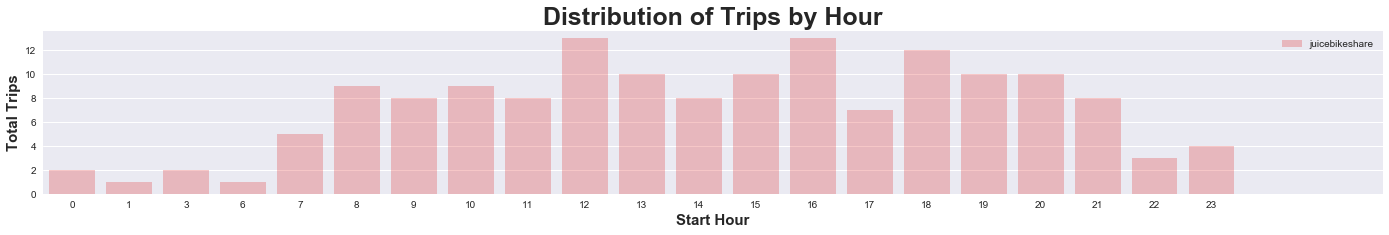

kona - (2017-11-15 15:30:11 to 2017-11-15 17:36:50)
Unable to plot kona
lou - (2017-11-15 19:28:17 to 2017-11-15 21:36:51)
Unable to plot lou
monashbikeshare - (2017-11-14 08:54:40 to 2017-11-16 13:35:36)


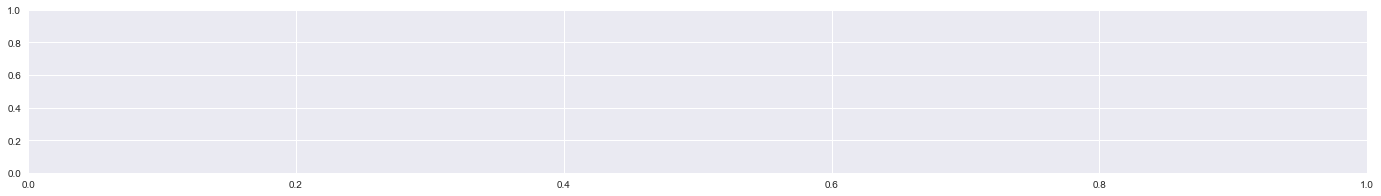

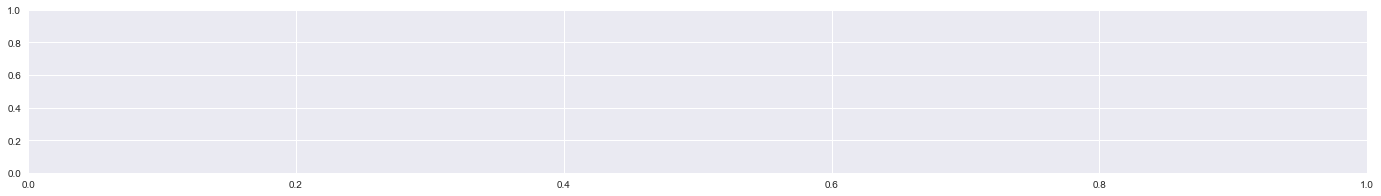

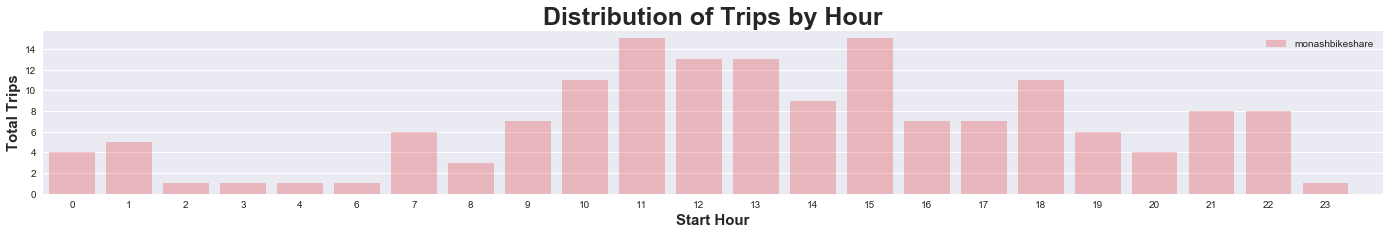

mountainridesbikeshare - (2017-11-13 15:55:16 to 2017-11-15 20:35:42)
Unable to plot mountainridesbikeshare
niceridemn - (2017-11-05 04:03:55 to 2017-11-15 04:56:09)
Unable to plot niceridemn
nyc - (2017-09-01 08:02:07 to 2017-11-15 22:36:40)


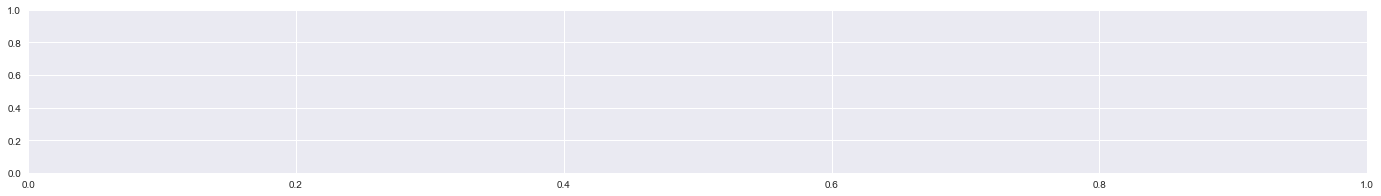

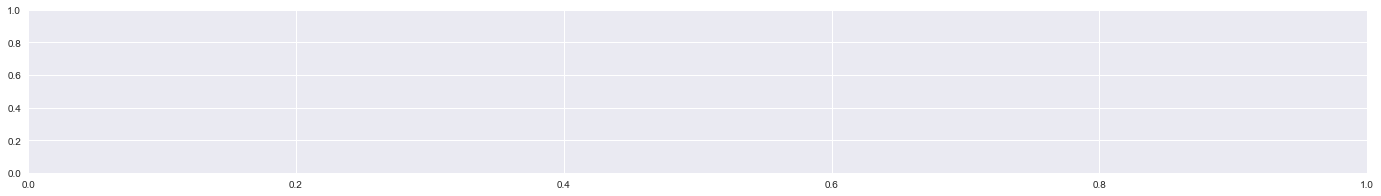

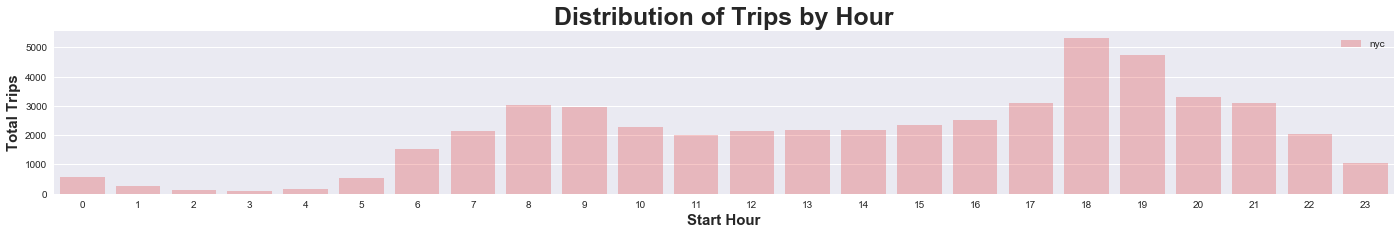

rec - (2017-11-15 22:27:28 to 2017-11-16 00:36:56)
Unable to plot rec
reddybikeshare - (2017-11-13 17:56:04 to 2017-11-15 22:36:46)


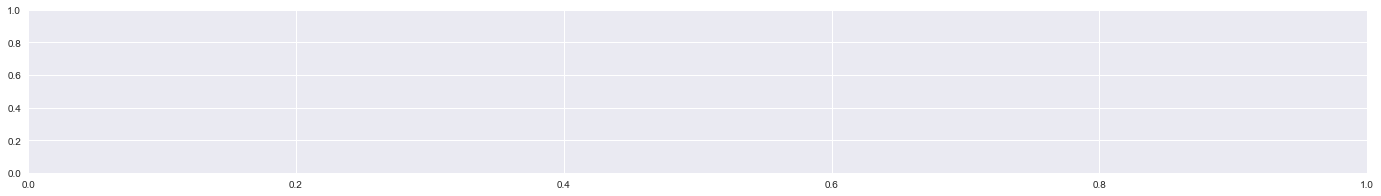

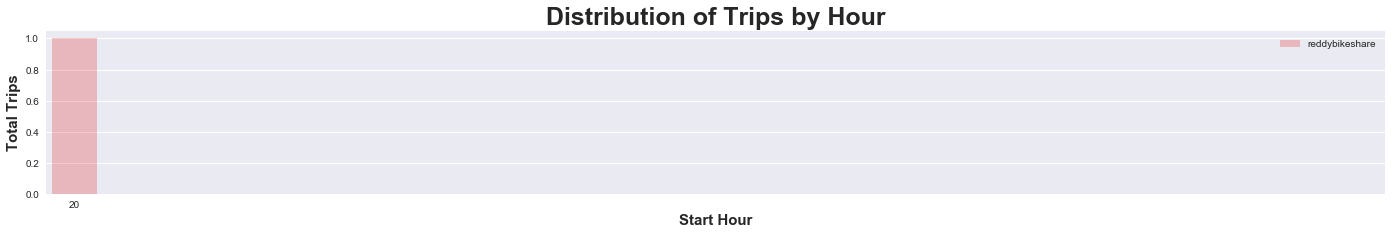

relaybikeshare - (2017-11-13 17:56:06 to 2017-11-15 22:36:47)


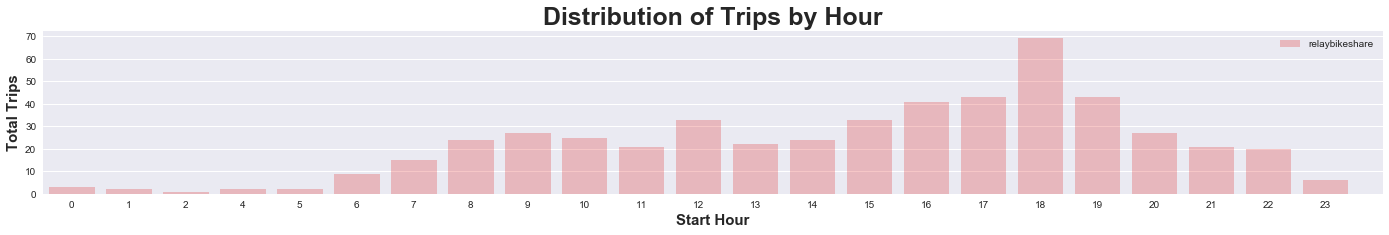

rey - (2017-10-16 09:32:30 to 2017-10-25 08:03:37)
Unable to plot rey
sobihamilton - (2017-11-13 17:54:37 to 2017-11-15 22:35:33)


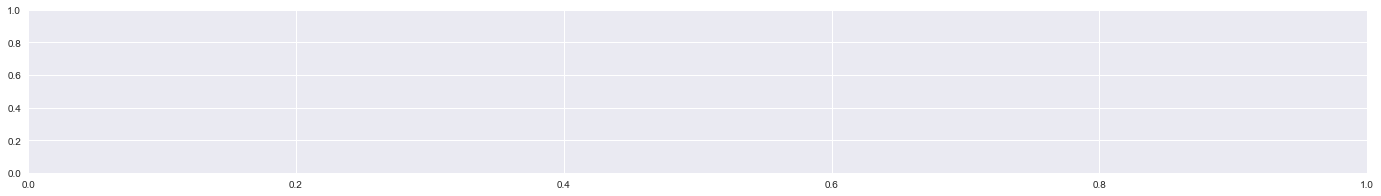

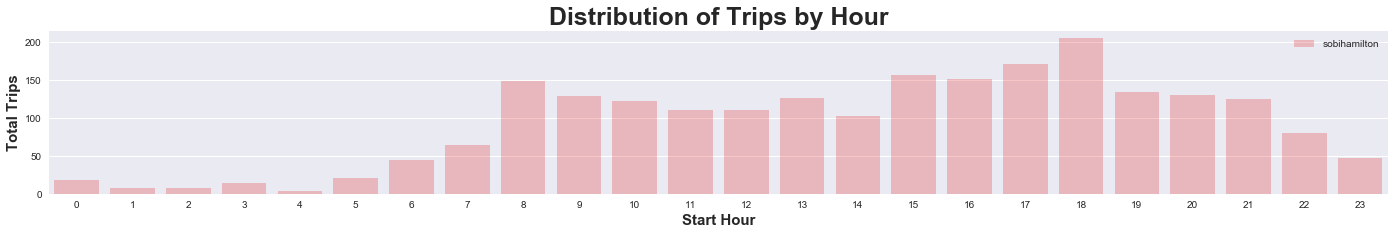

sobilongbeach - (2017-11-13 17:56:07 to 2017-11-15 22:36:49)


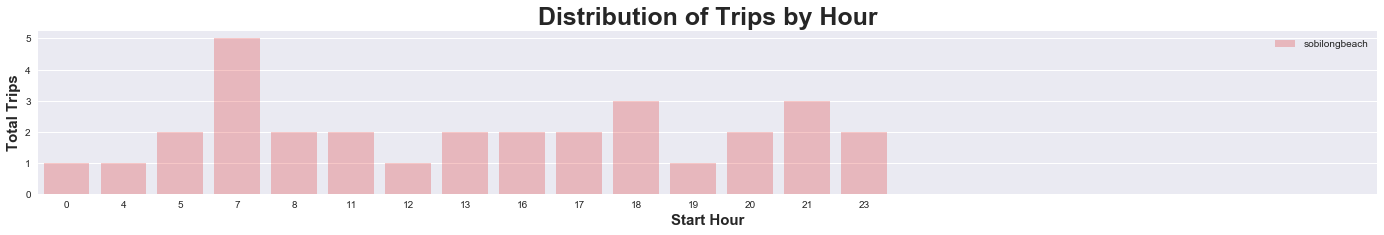

topekametrobikes - (2017-11-13 16:55:37 to 2017-11-15 21:36:07)


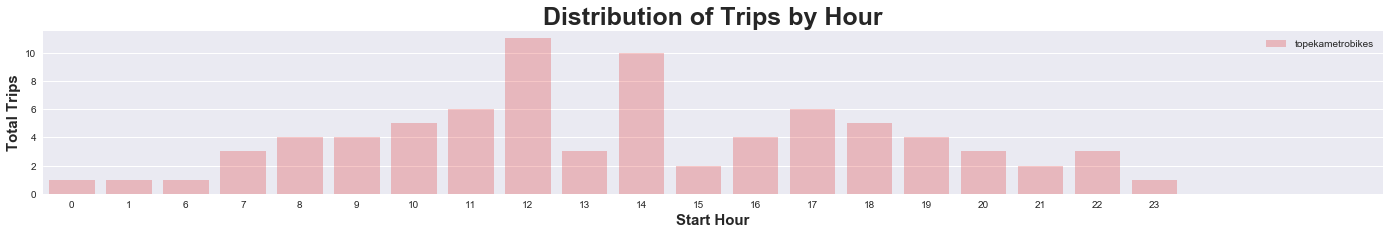

universityofvirginia - (2017-11-13 17:56:09 to 2017-11-15 22:36:50)


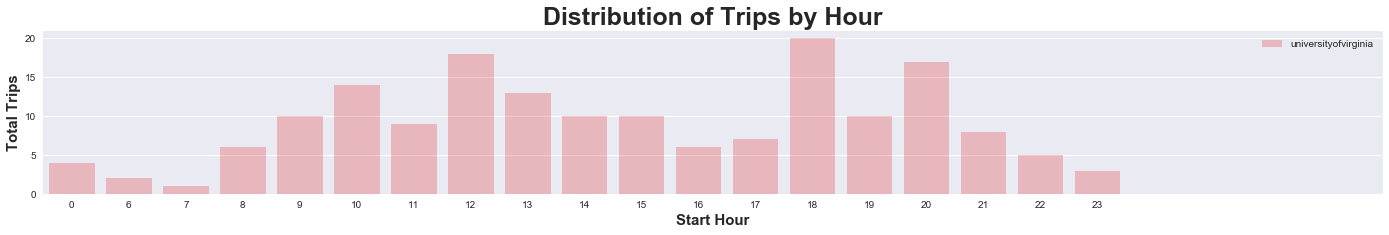

velgo - (2017-11-13 17:54:38 to 2017-11-14 15:47:23)


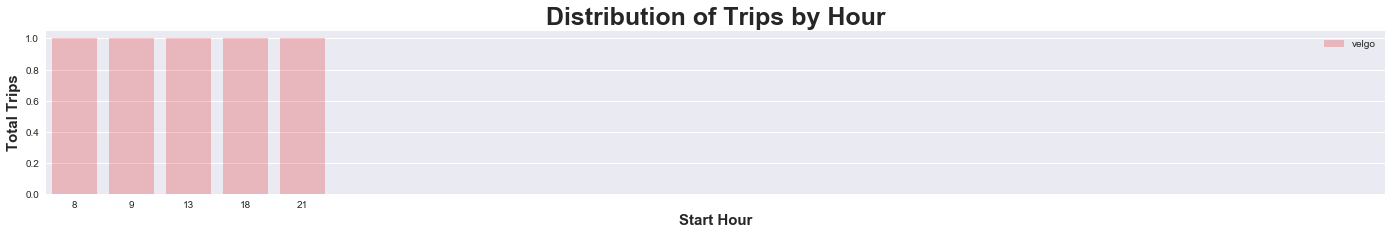

In [80]:
for pid in sorted(pd.unique(status_data.program_id)):
    df = status_data[status_data.program_id == pid].copy()
    print('%s - (%s to %s)' % (pid, df.time.min(), df.time.max()))
    plot_hourly_usage(df, title=pid.lower(), color='r')

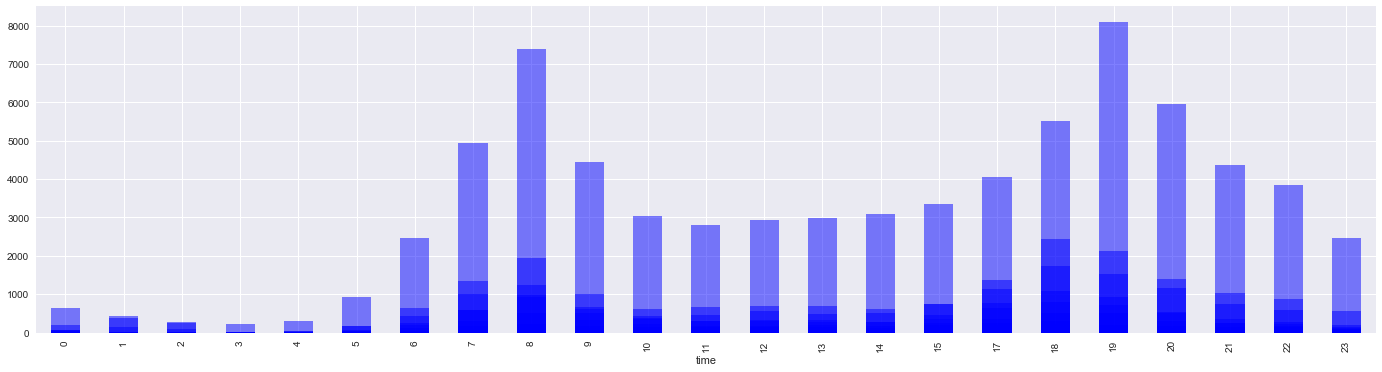

In [89]:
fig, ax = plt.subplots(figsize=(24,6))
for pid in pd.unique(status_data.program_id):
    status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum().plot(kind='bar', color='b', alpha= 0.5, ax=ax)

# ax.set_ylim(0, 1000)
plt.show()

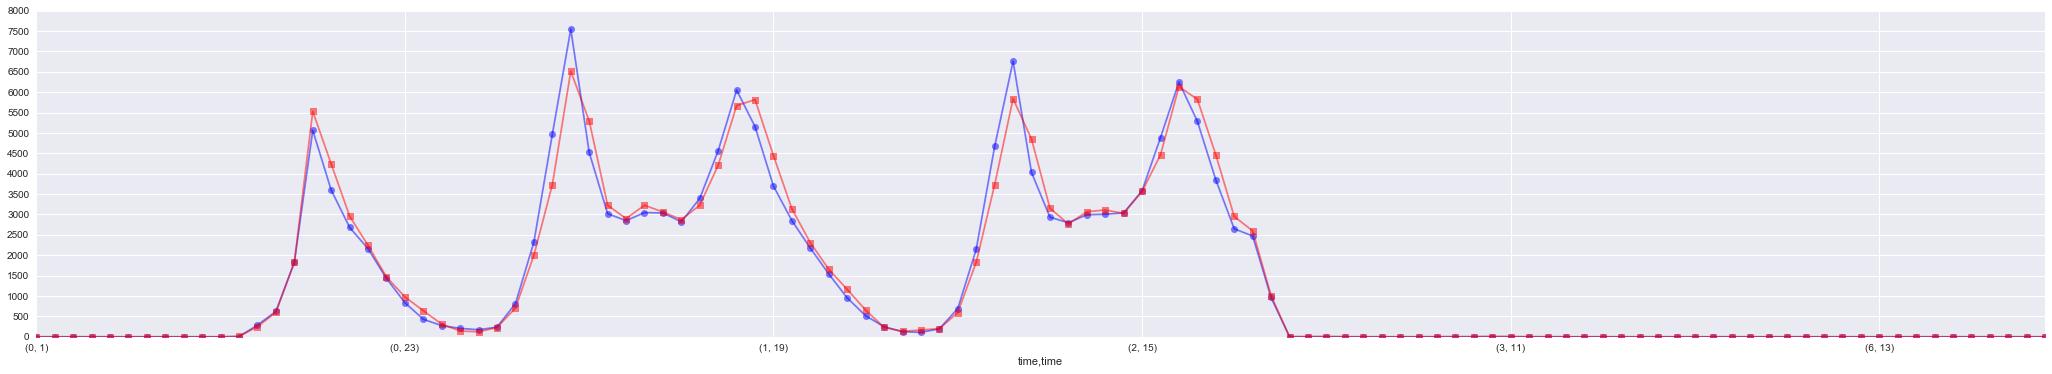

In [96]:
d0 = status_data.groupby([status_data.time.dt.dayofweek, status_data.time.dt.hour]).trips_starting.sum()
d1 = status_data.groupby([status_data.time.dt.dayofweek, status_data.time.dt.hour]).trips_ending.sum()

ax = d0.plot(figsize=(36,6), color='b', alpha=0.5, marker='o')
d1.plot(ax=ax, color='r', alpha=0.5, marker='s')


y_tick_interval = 500
y_max = math.ceil(d0.max()/y_tick_interval)*y_tick_interval

if math.ceil(d1.max()/y_tick_interval)*y_tick_interval > y_max:
    y_max = math.ceil(d1.max()/y_tick_interval)*y_tick_interval

y_tick_max = int(y_max/y_tick_interval*1.1)

ax.set_ylim(0, y_max)
ax.set_yticks([y*y_tick_interval for y in range(0, y_tick_max)])

plt.show()

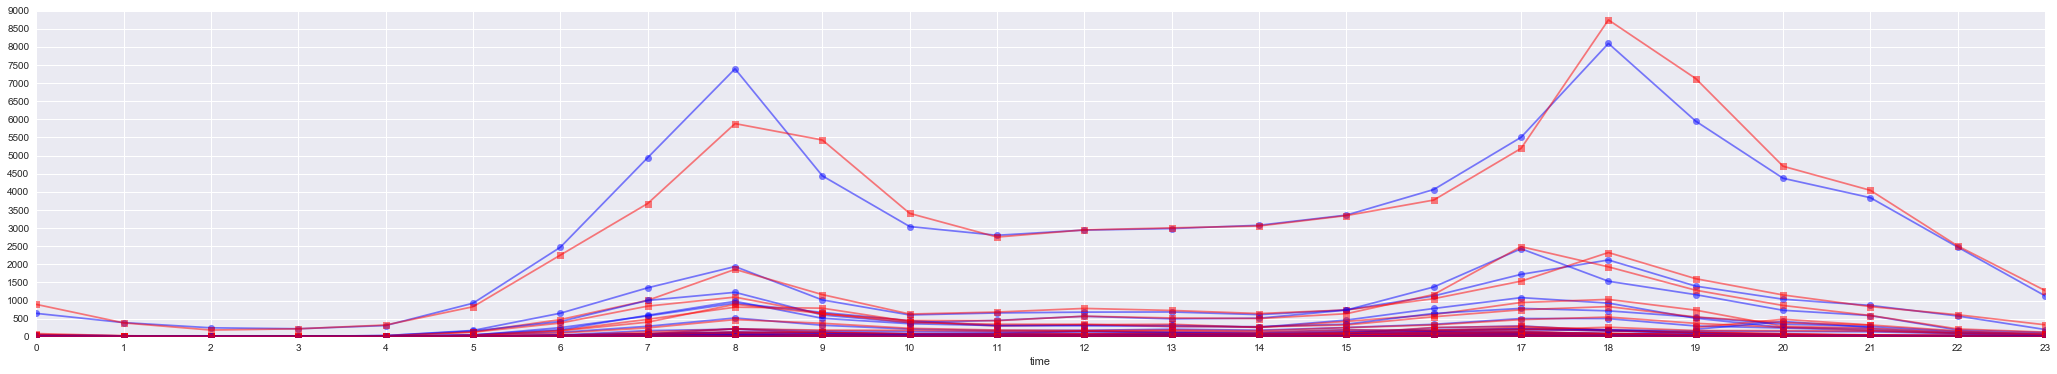

In [95]:
fig, ax = plt.subplots(figsize=(36,6))
y_max = 0
for pid in pd.unique(status_data.program_id):
    status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum().plot(color='b', alpha= 0.5, ax=ax, marker='o')
    status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_ending.sum().plot(color='r', alpha= 0.5, ax=ax, marker='s')
    
    if status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum().max() > y_max:
        y_max = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_starting.sum().max()
    
    if status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_ending.sum().max() > y_max:
        y_max = status_data[status_data.program_id == pid].groupby([status_data.time.dt.hour]).trips_ending.sum().max()
    

# ax.set_ylim(0, 1000)

y_tick_interval = 1000
y_max = math.ceil(y_max/y_tick_interval)*y_tick_interval
y_tick_max = int(y_max/y_tick_interval)+1
x_ticks = sorted(pd.unique(df.time.dt.hour))
ax.set_xticks(x_ticks)
ax.set_ylim(0, y_max)
ax.set_yticks([y*y_tick_interval for y in range(0, y_tick_max)])

plt.show()

In [91]:
print('Program ID\t\t\tTrips Starting\tTrips Ending\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    E = status_data[status_data.program_id == pid].trips_ending.sum()
    print('%s\t%s\t\t%s\t\t%s' % (pid.ljust(25), str(S), str(E), S-E))

Program ID			Trips Starting	Trips Ending	Net
aru                      	0.0		0.0		0.0
asp                      	1.0		1.0		0.0
ba                       	8616.0		8516.0		100.0
bcyclearborbike          	96.0		96.0		0.0
bcycleaustin             	875.0		897.0		-22.0
bcycleaventura           	15.0		15.0		0.0
bcyclebattlecreek        	0.0		0.0		0.0
bcycleboulder            	654.0		659.0		-5.0
bcyclebroward            	174.0		174.0		0.0
bcyclebublr              	294.0		298.0		-4.0
bcyclecatbike            	5.0		5.0		0.0
bcyclecharlotte          	236.0		222.0		14.0
bcyclecincyredbike       	296.0		301.0		-5.0
bcycleclarksville        	7.0		8.0		-1.0
bcycleclemson            	94.0		94.0		0.0
bcyclecolumbiacounty     	5.0		5.0		0.0
bcyclecolumbike          	8.0		8.0		0.0
bcycledallasfairpark     	0.0		0.0		0.0
bcycledenver             	2014.0		2048.0		-34.0
bcycledesmoines          	10.0		10.0		0.0
bcycleelpaso             	94.0		84.0		10.0
bcyclefortworth          	170.0		176.0		-6.0
bcyclegreenb

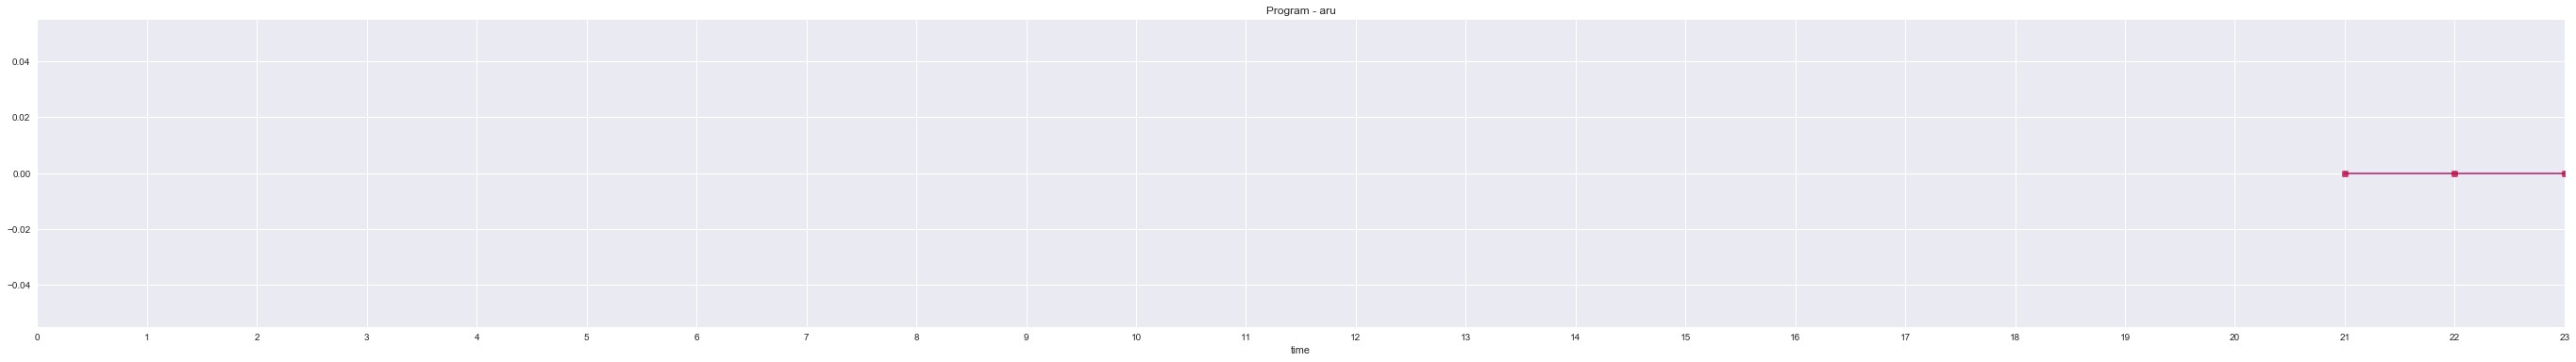

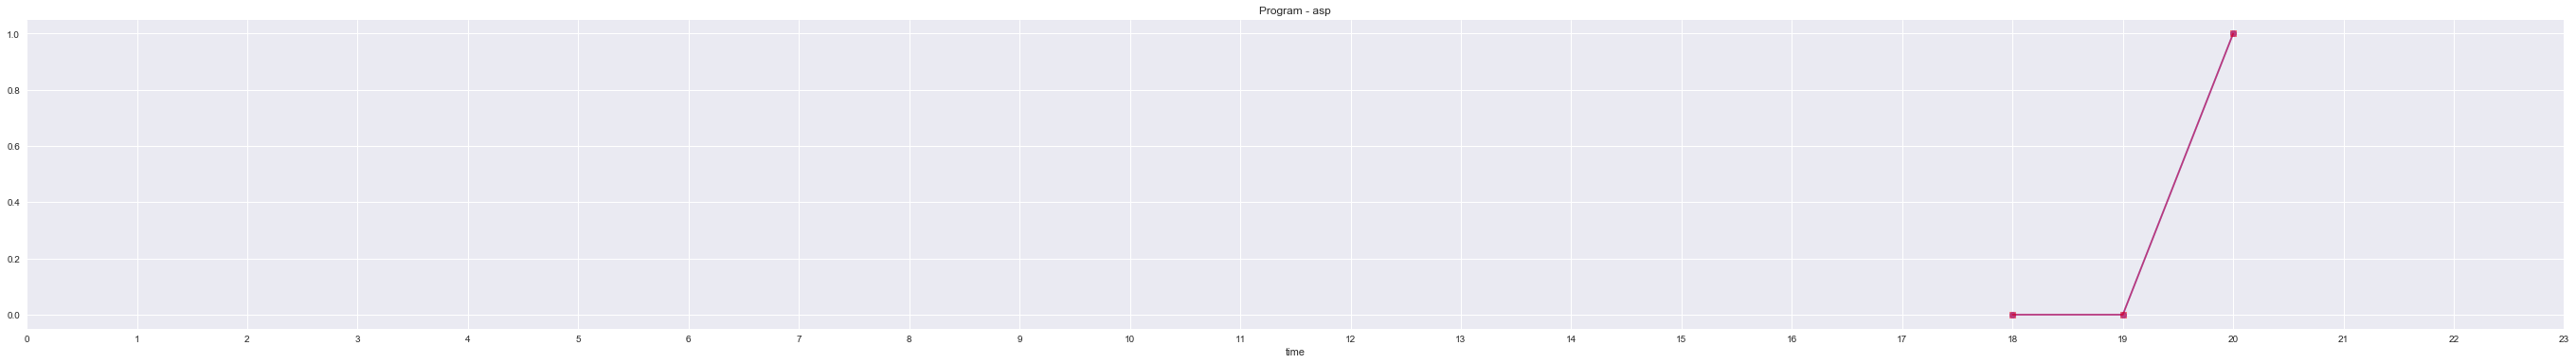

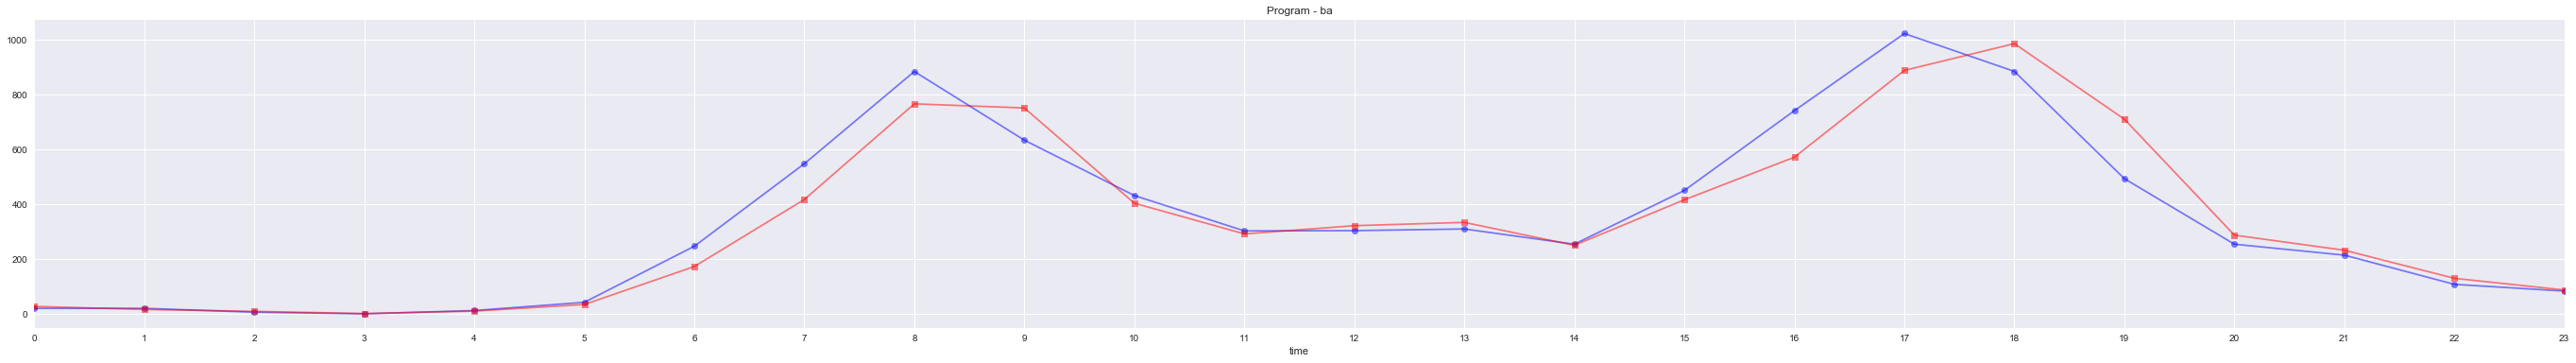

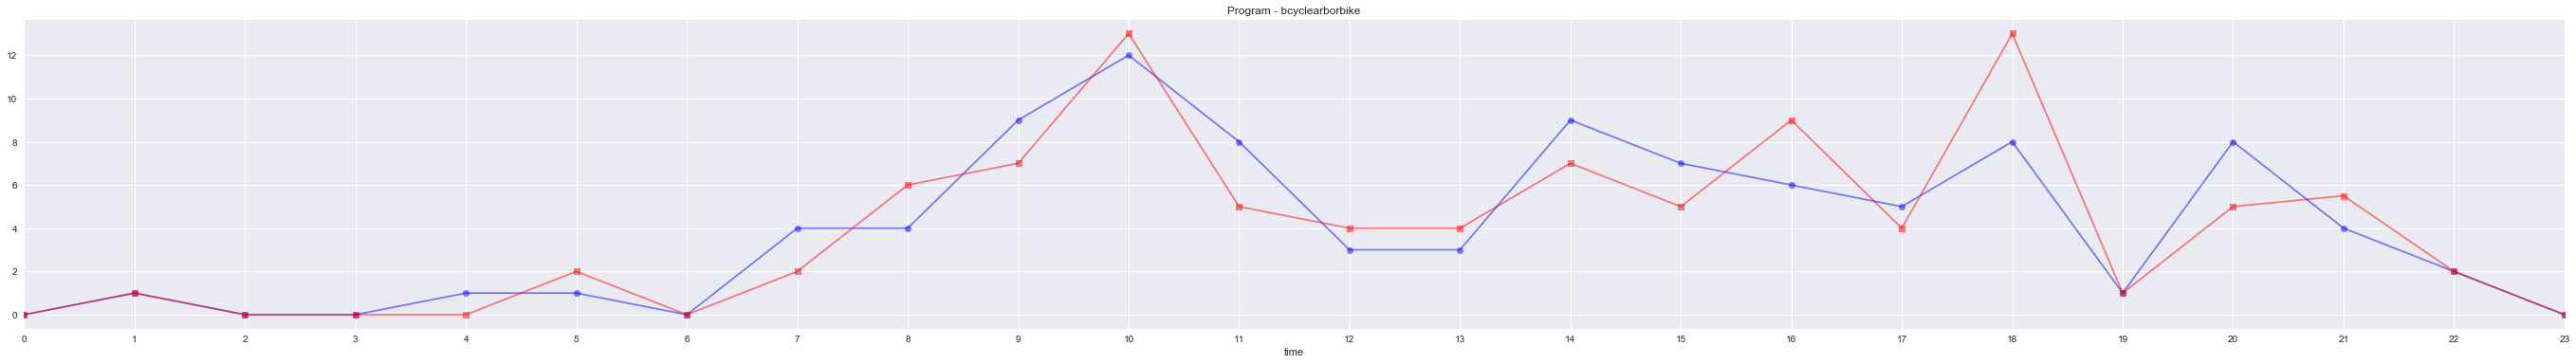

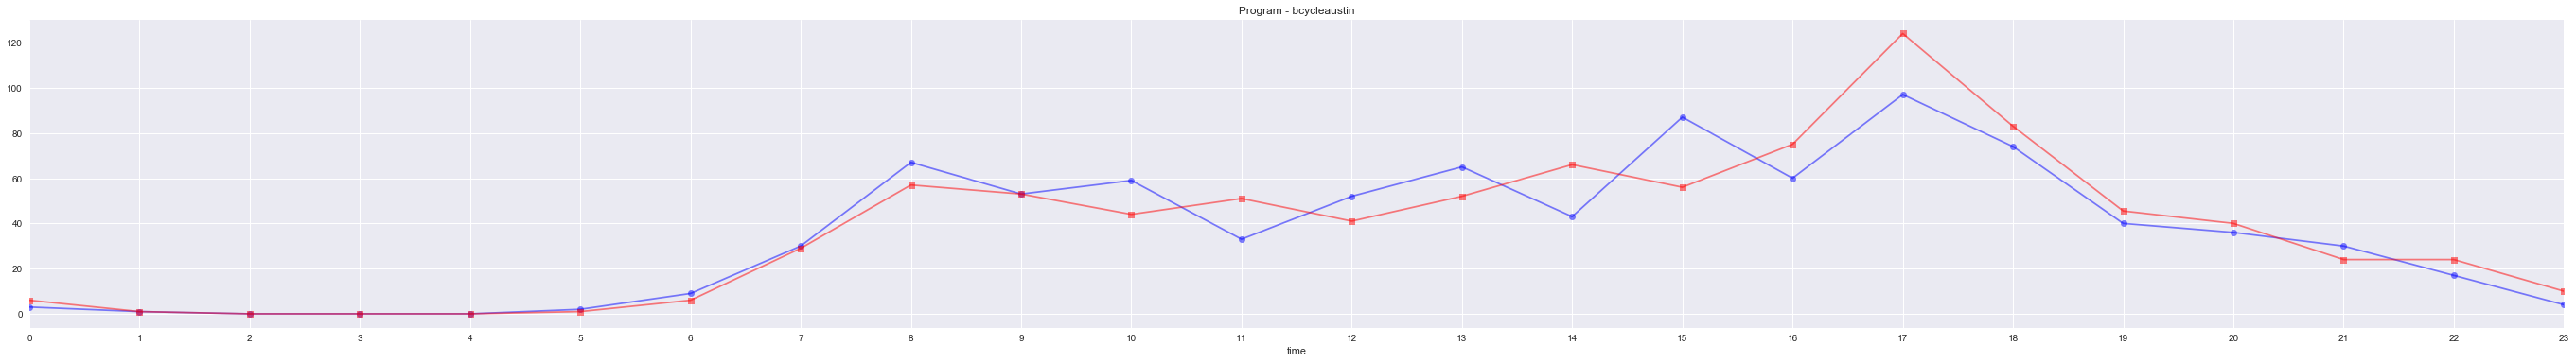

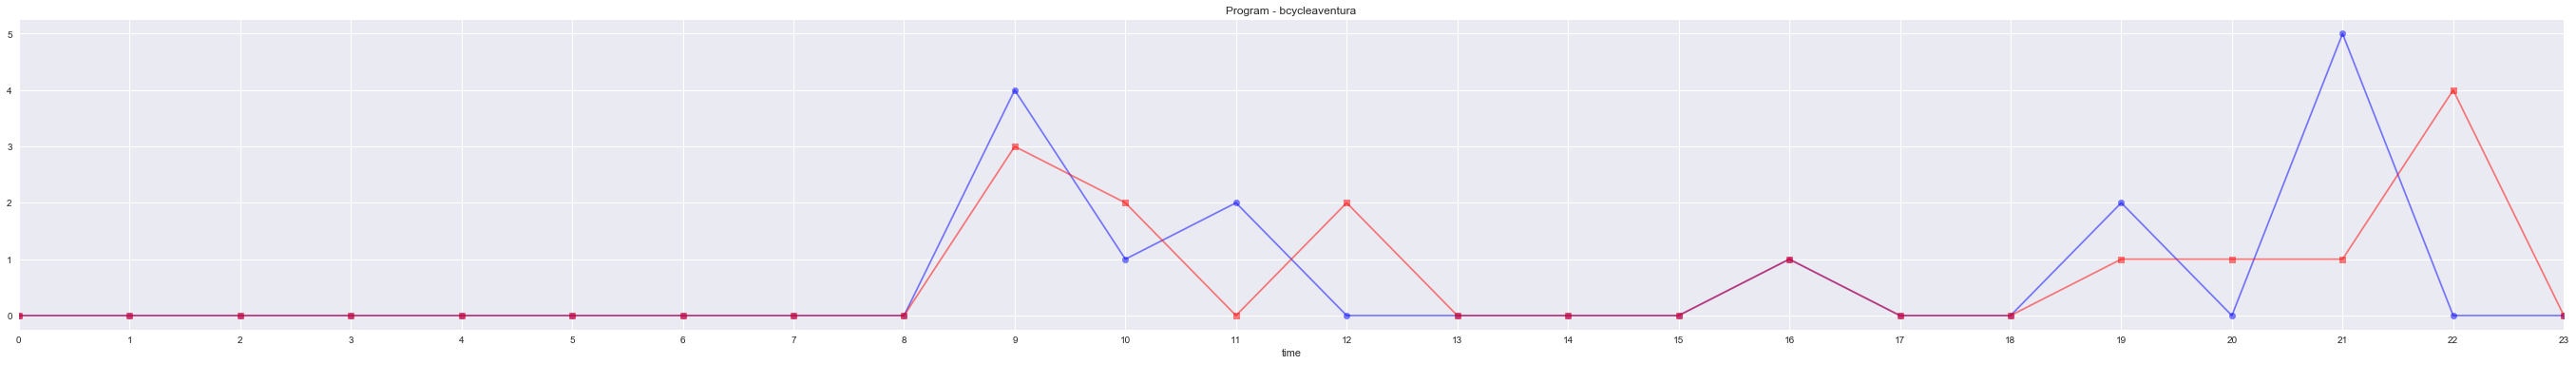

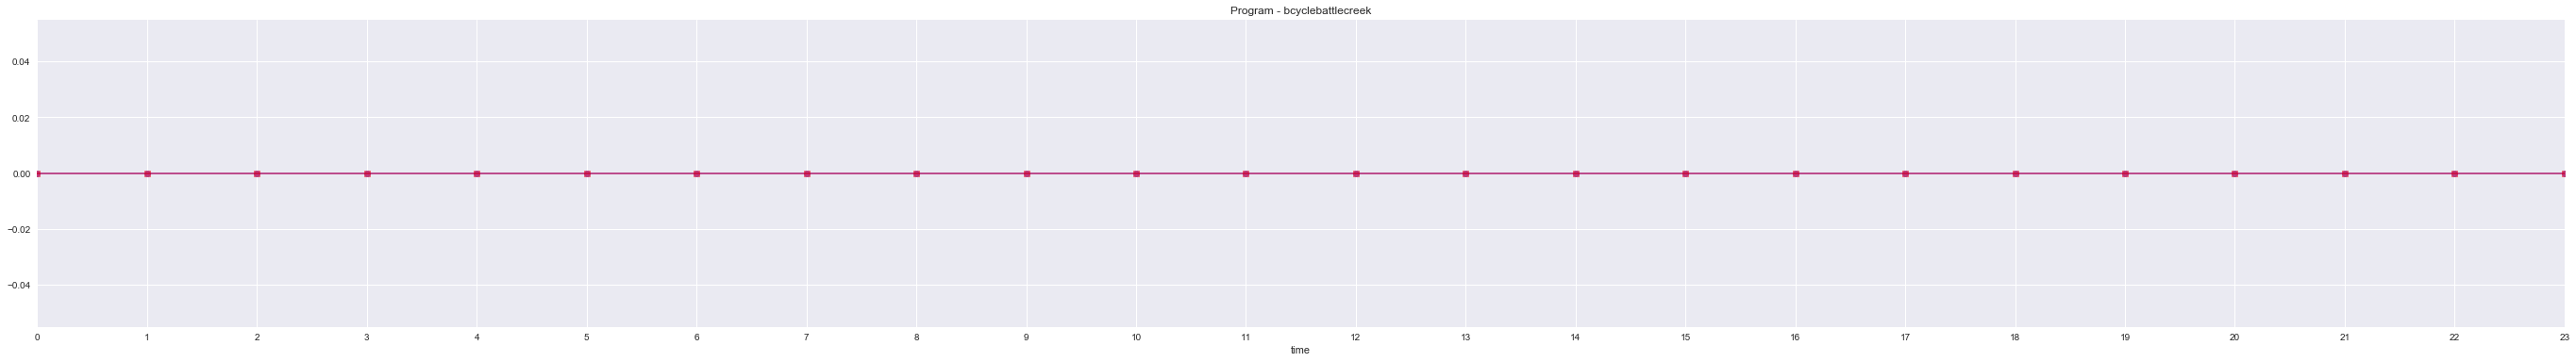

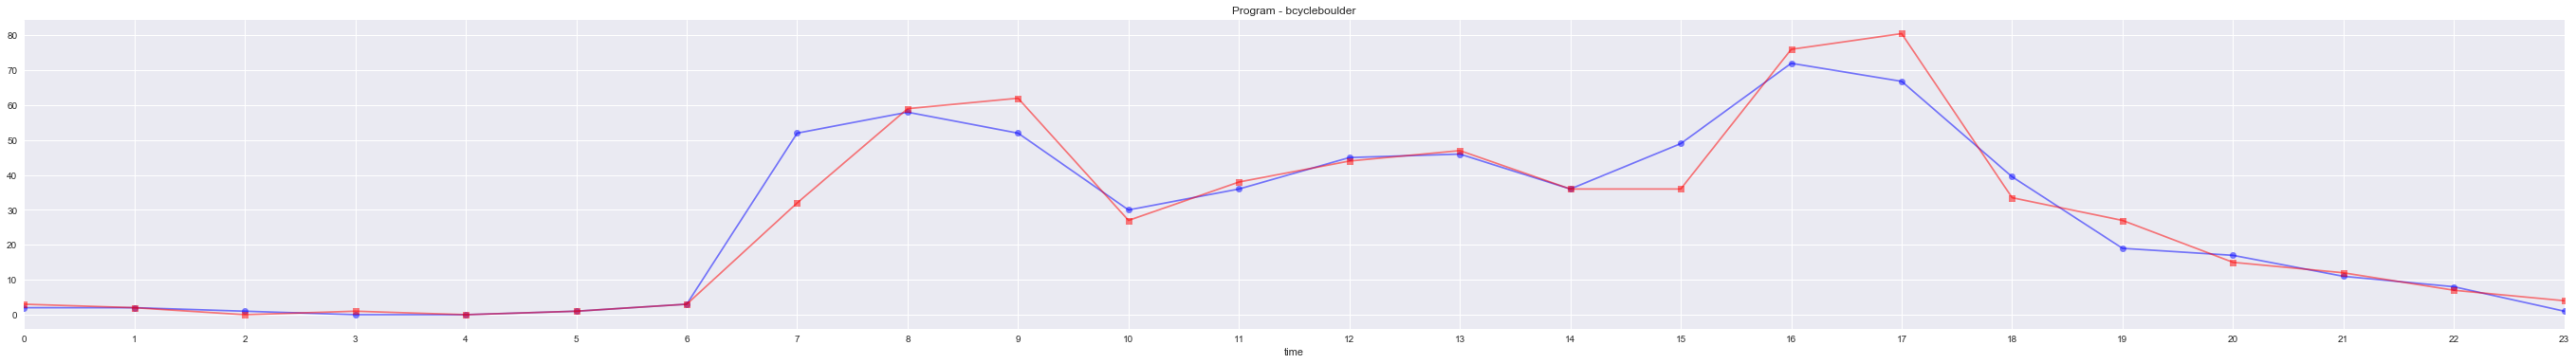

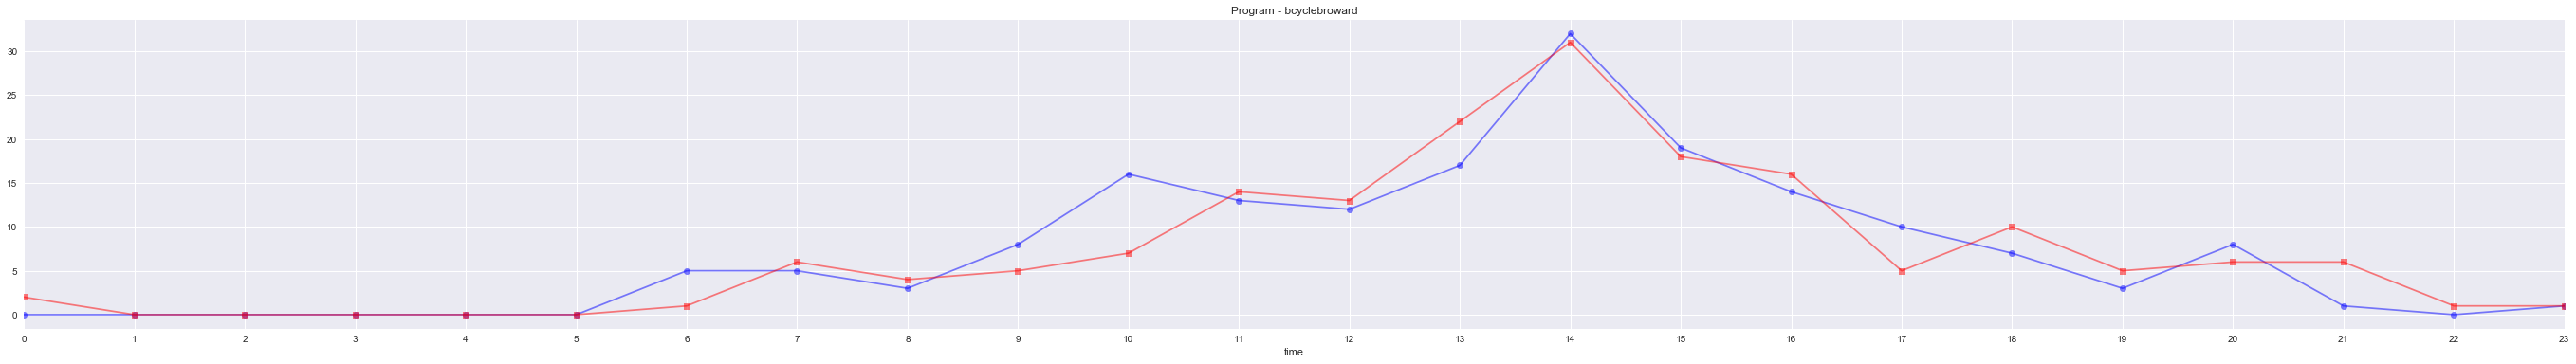

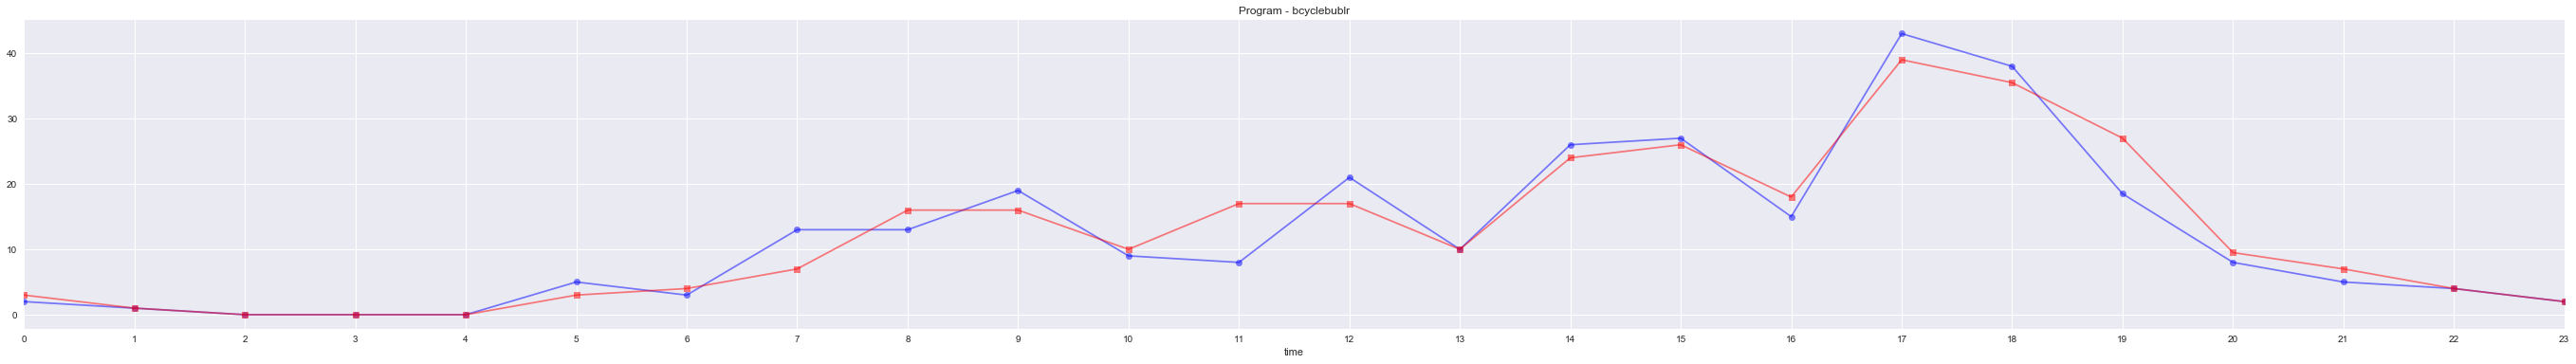

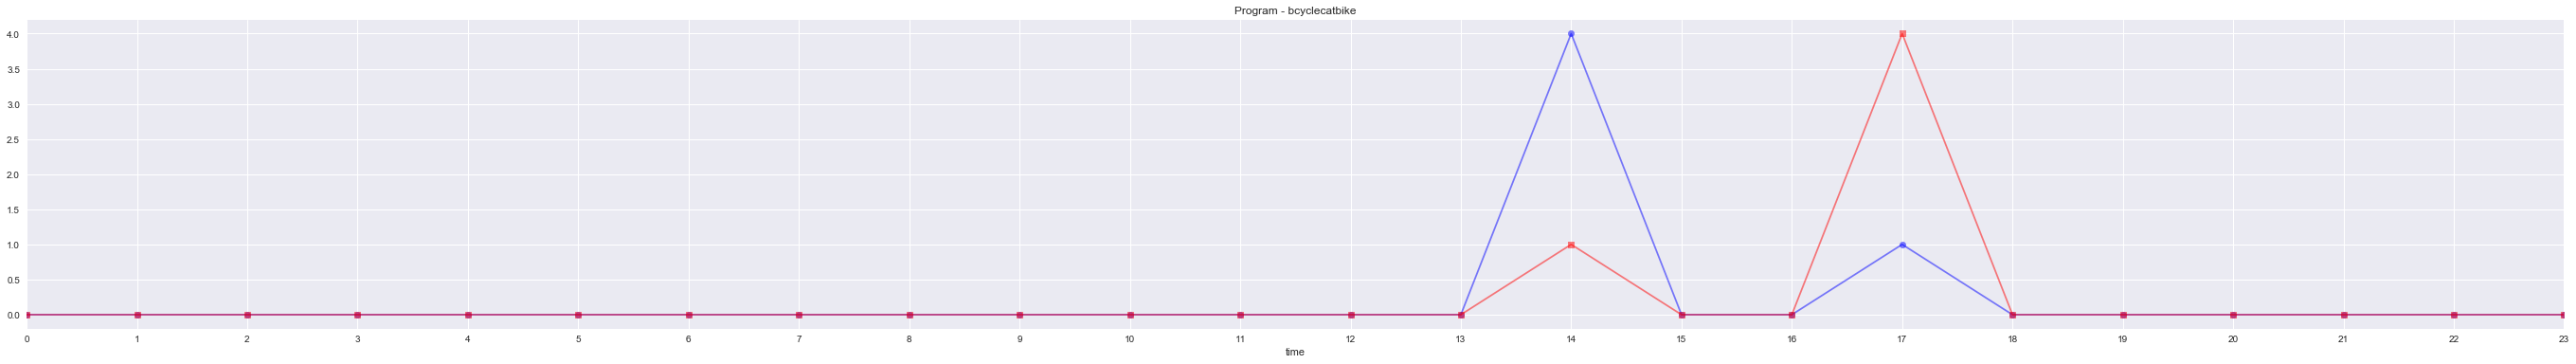

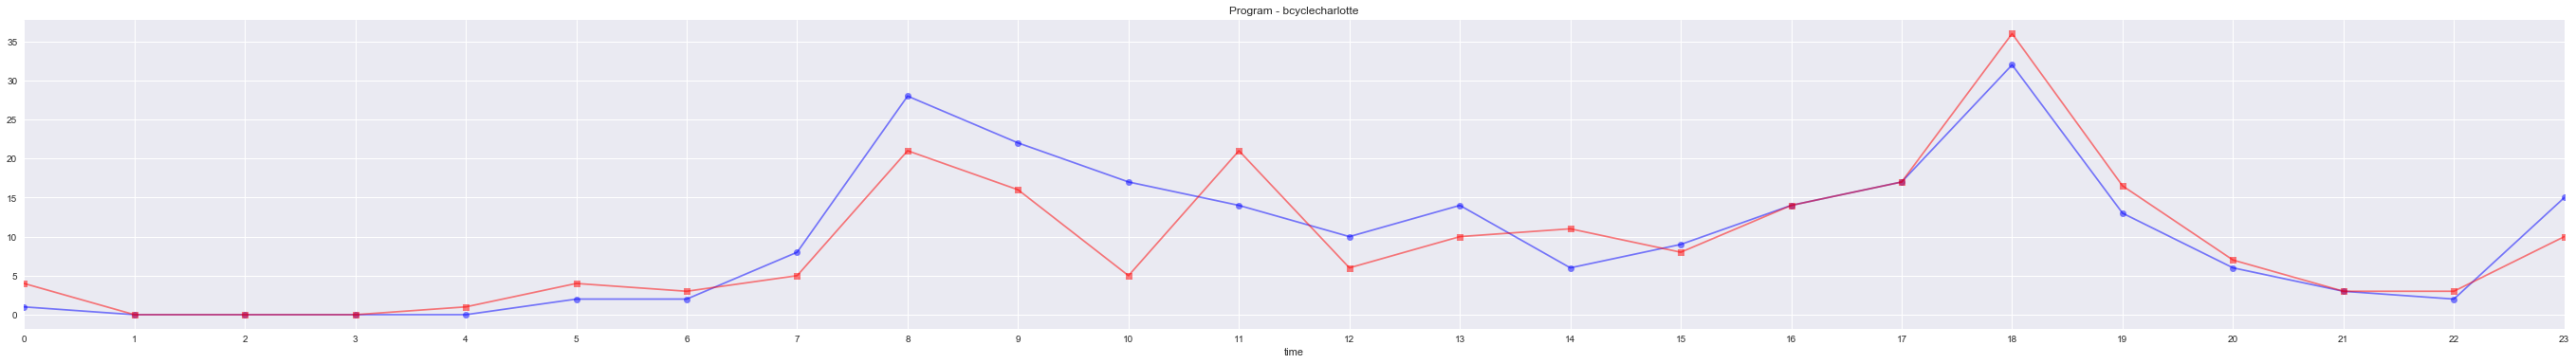

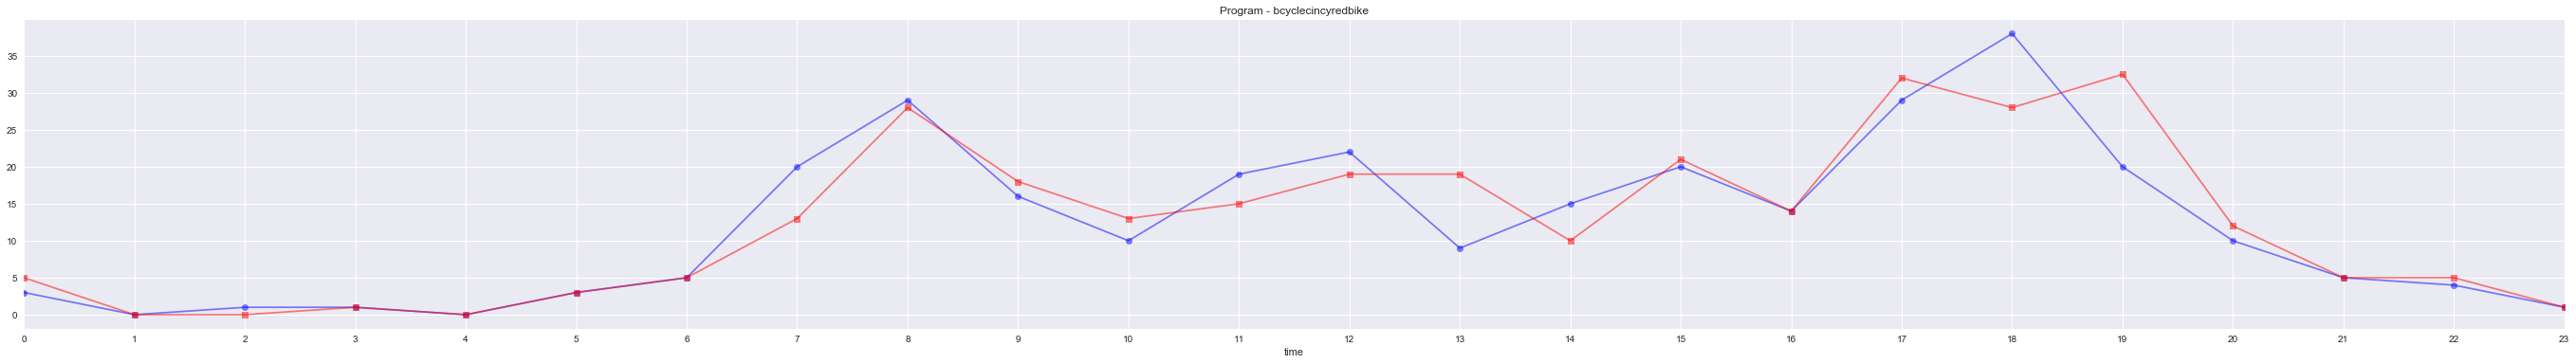

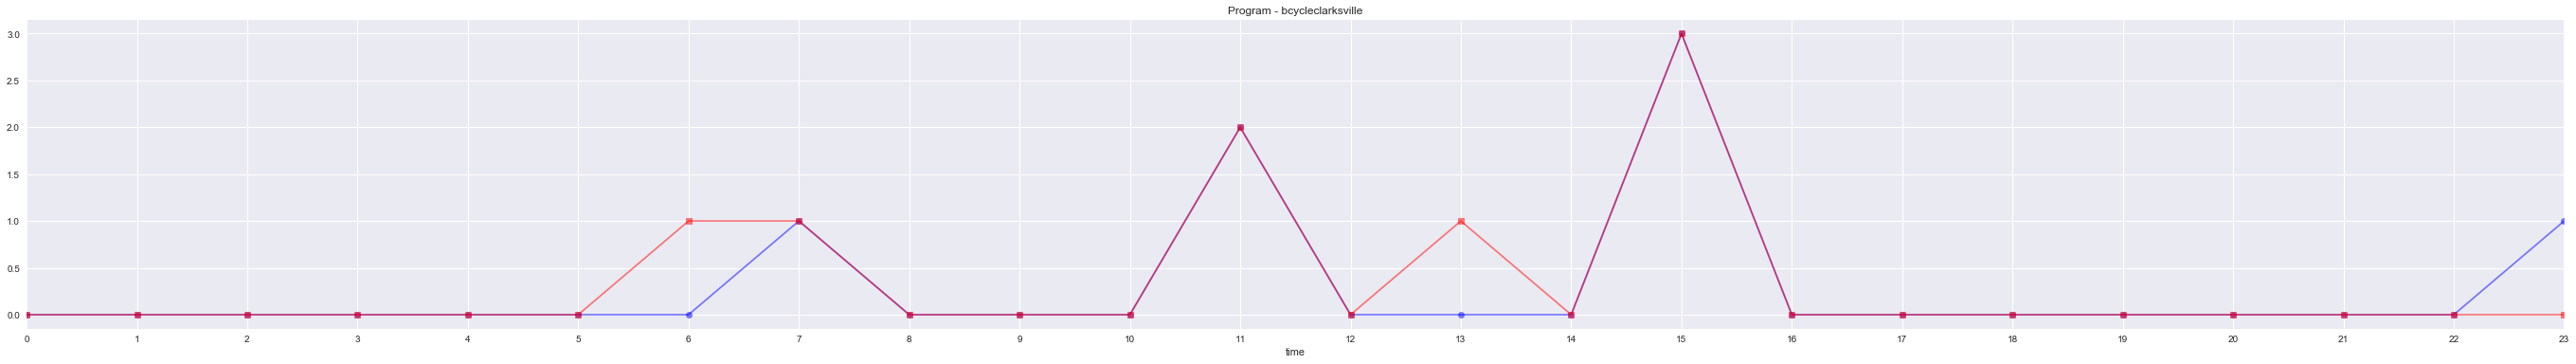

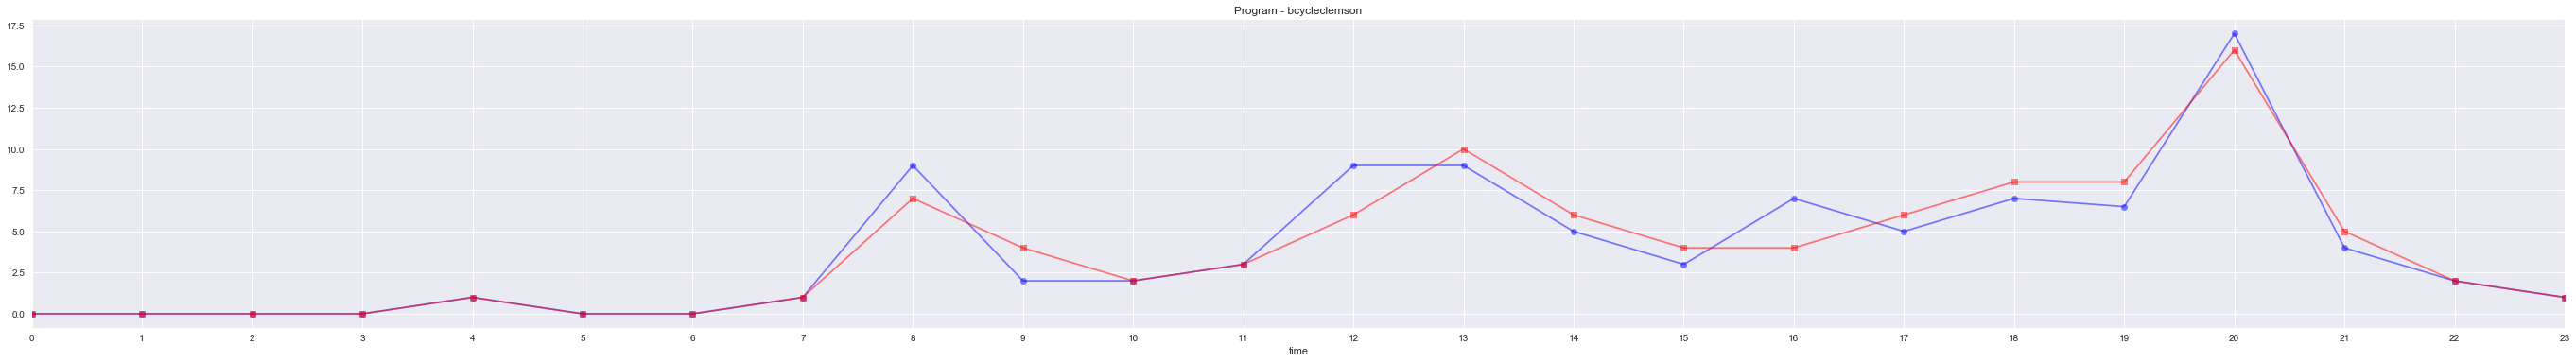

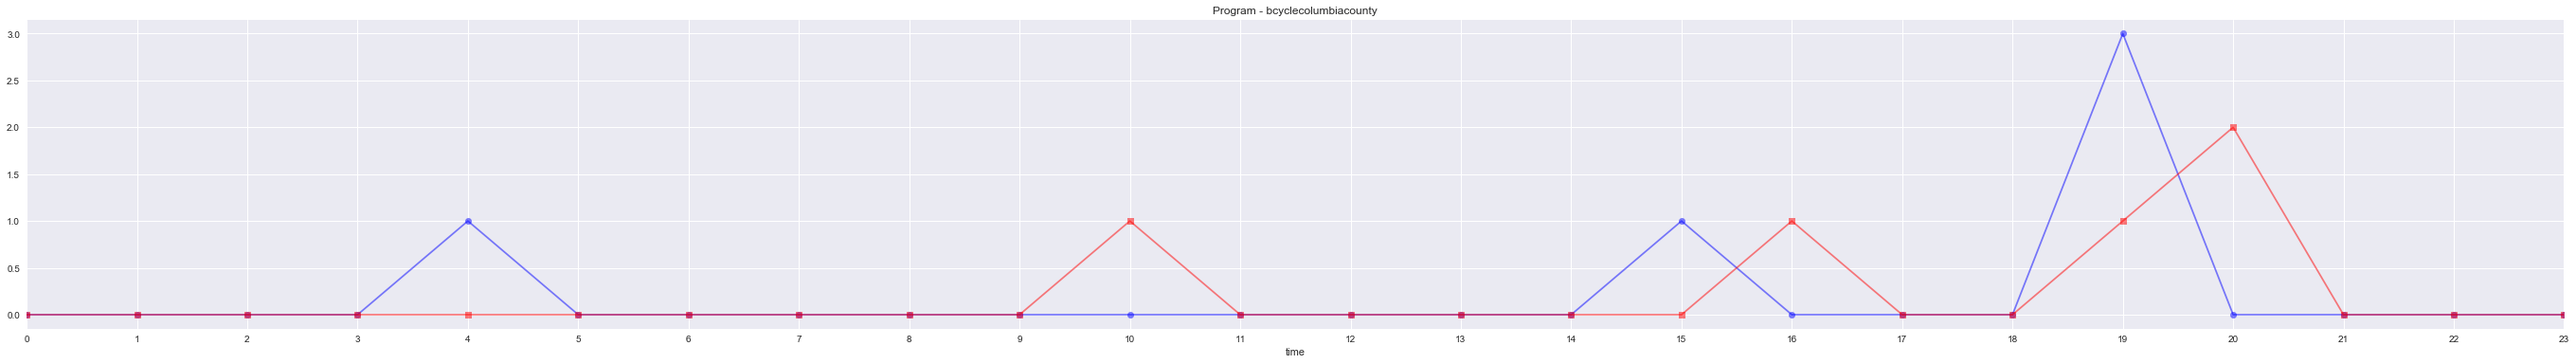

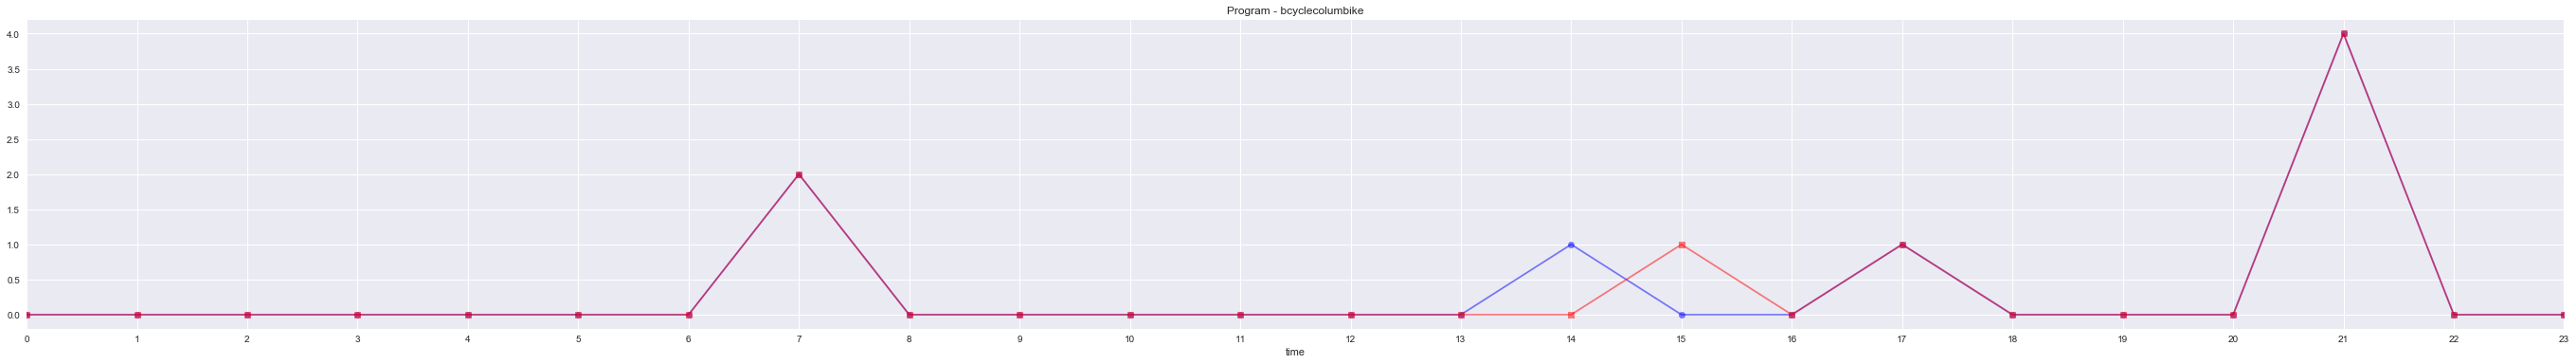

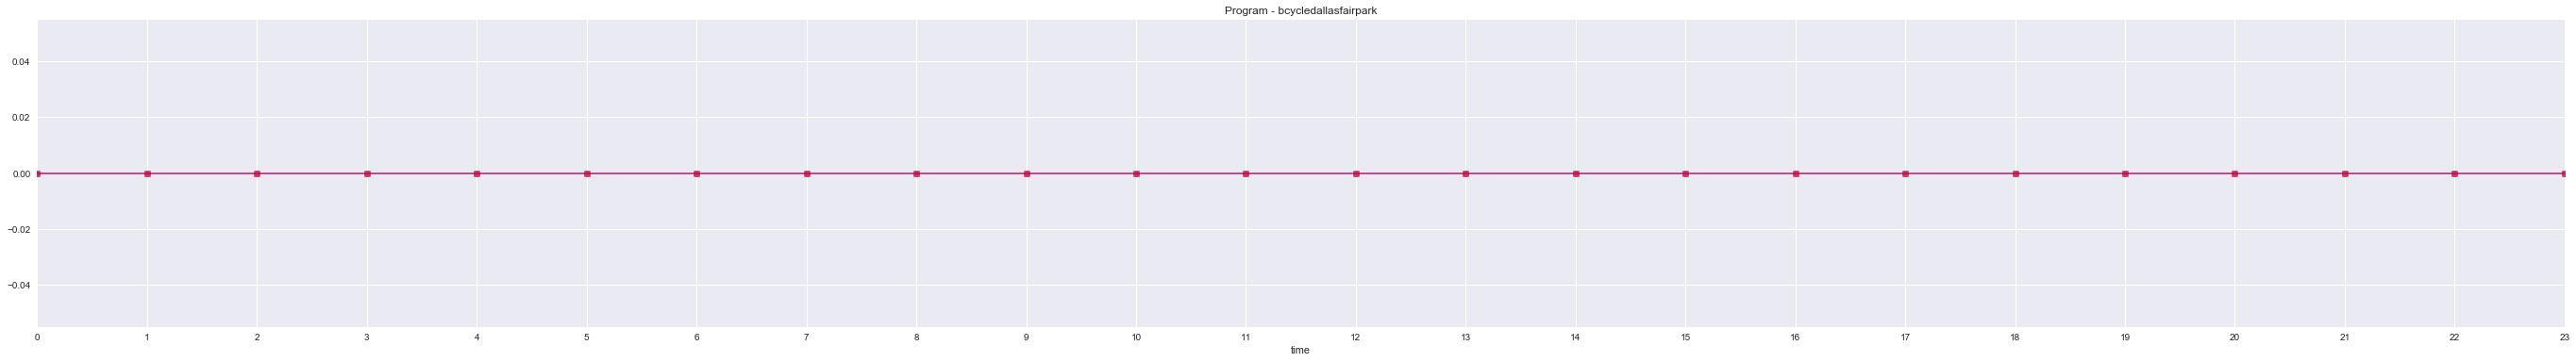

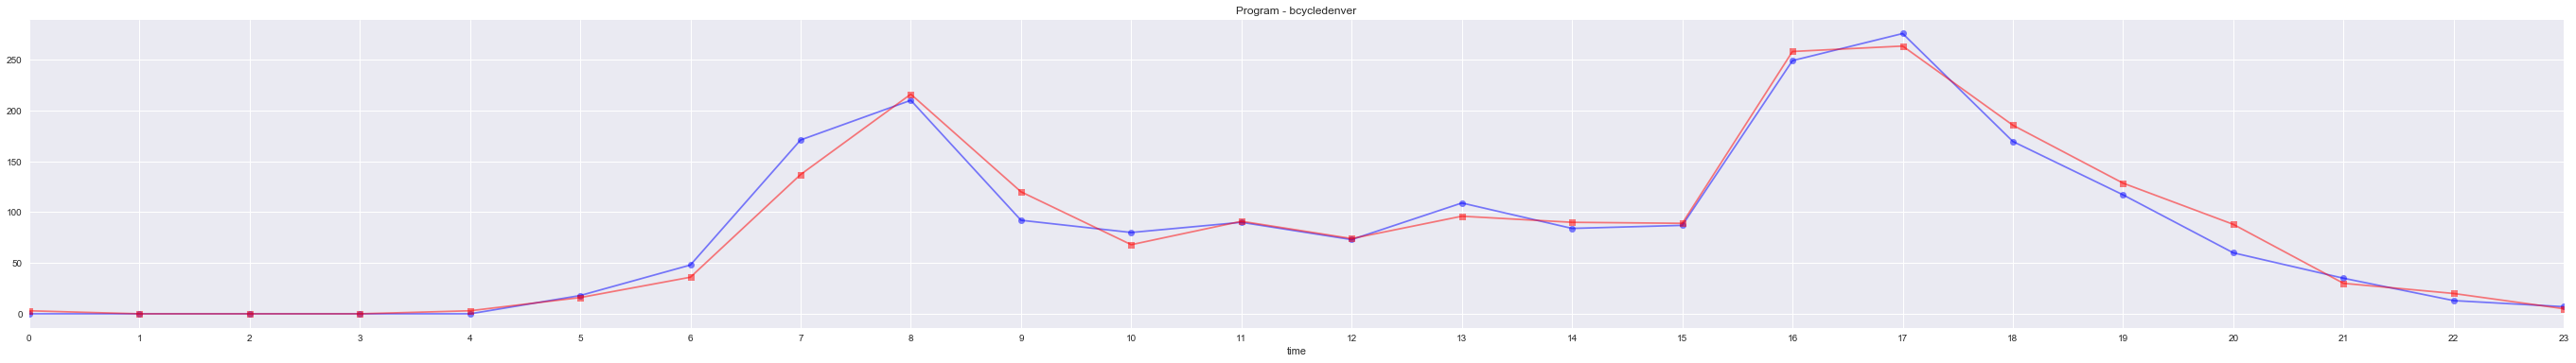

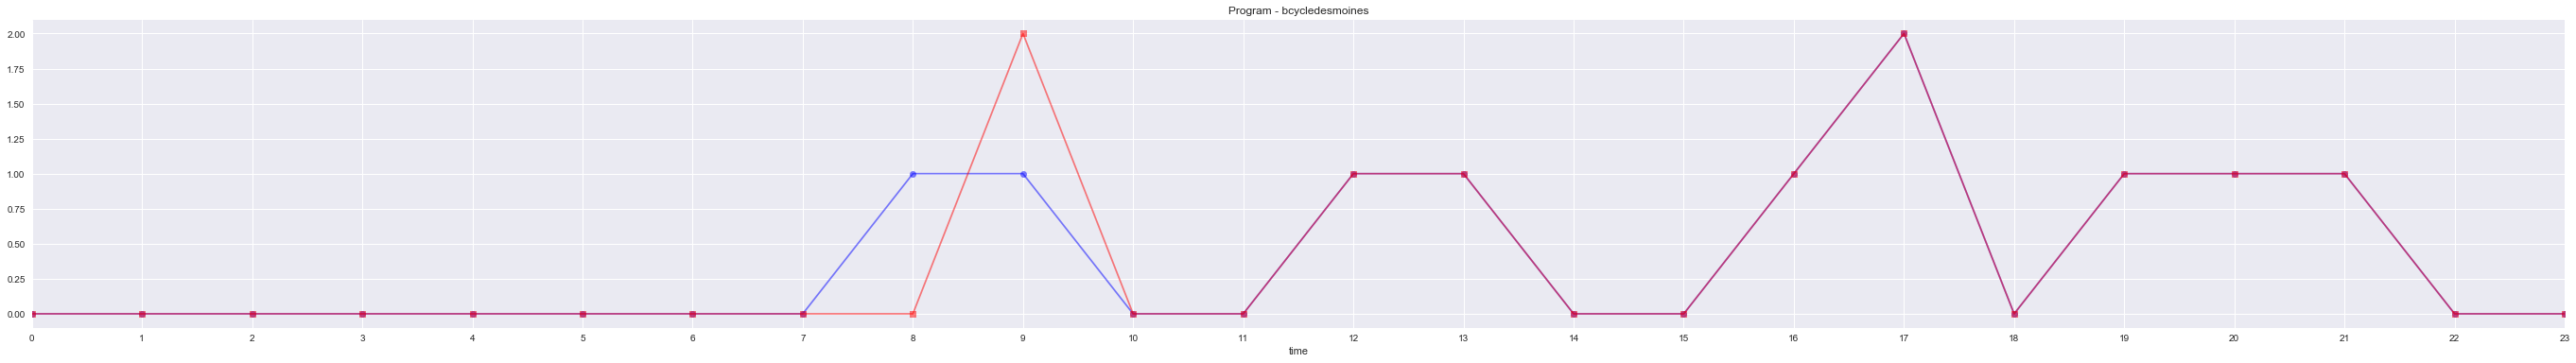

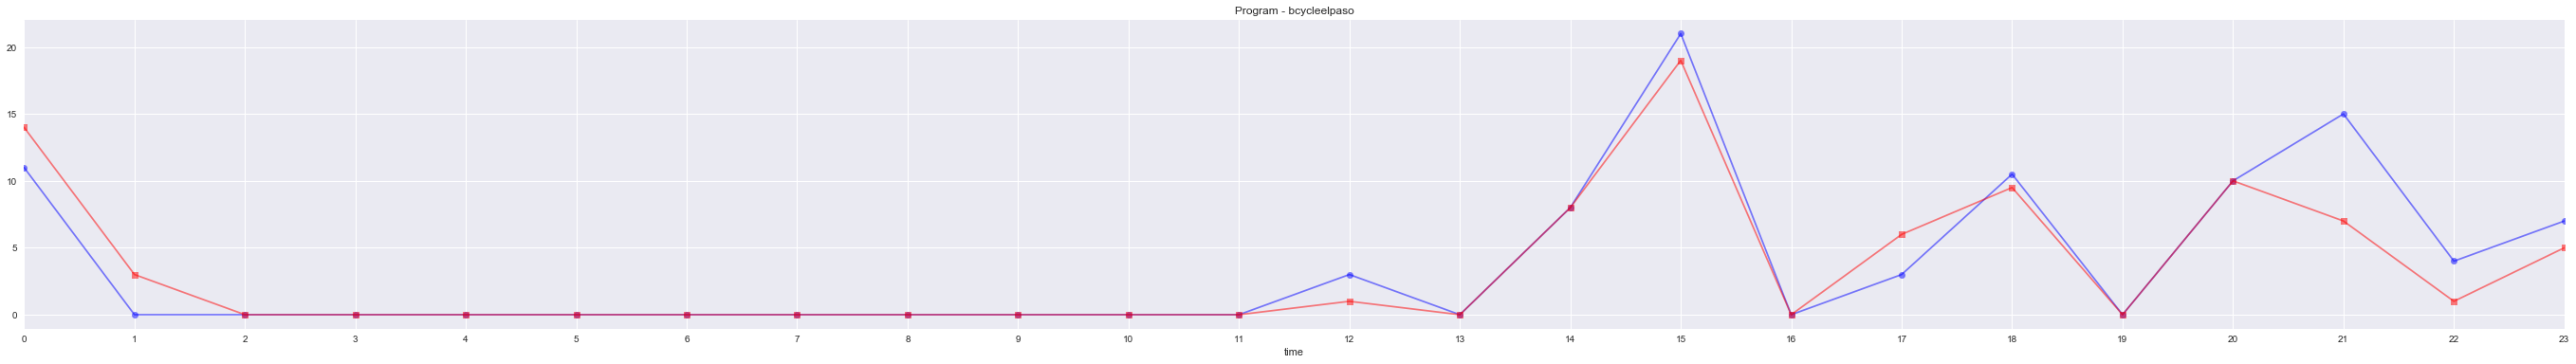

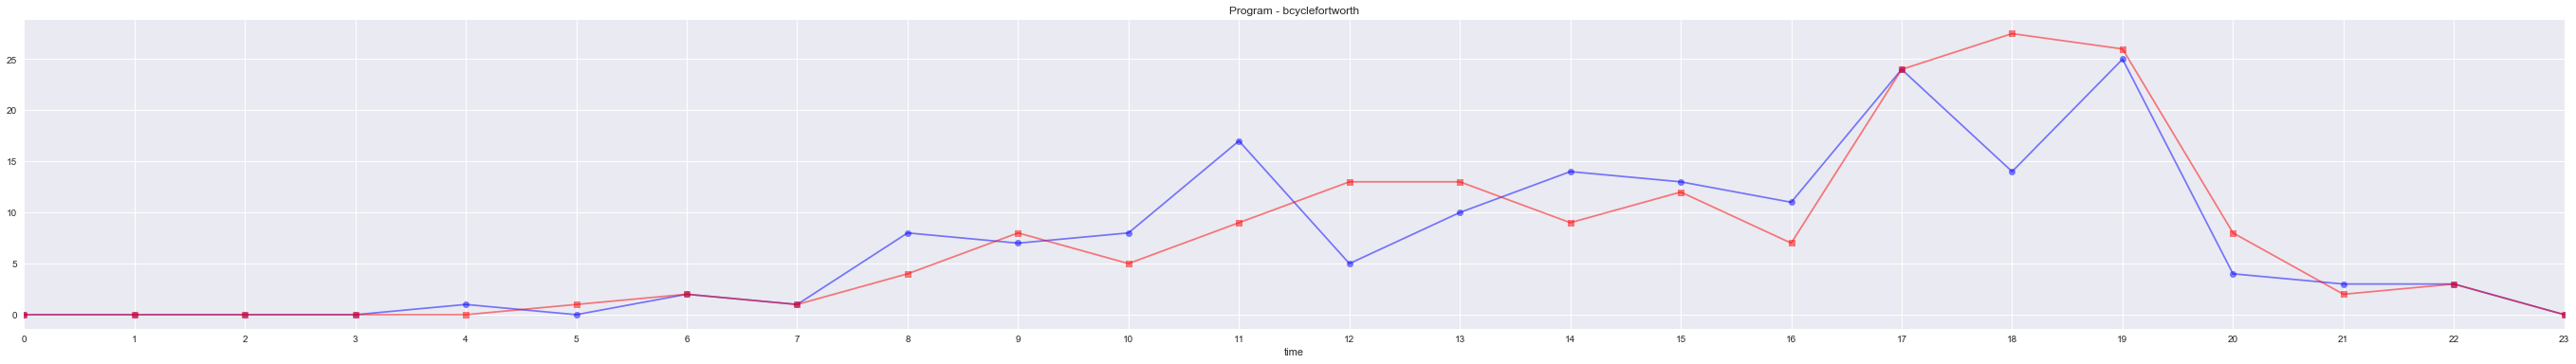

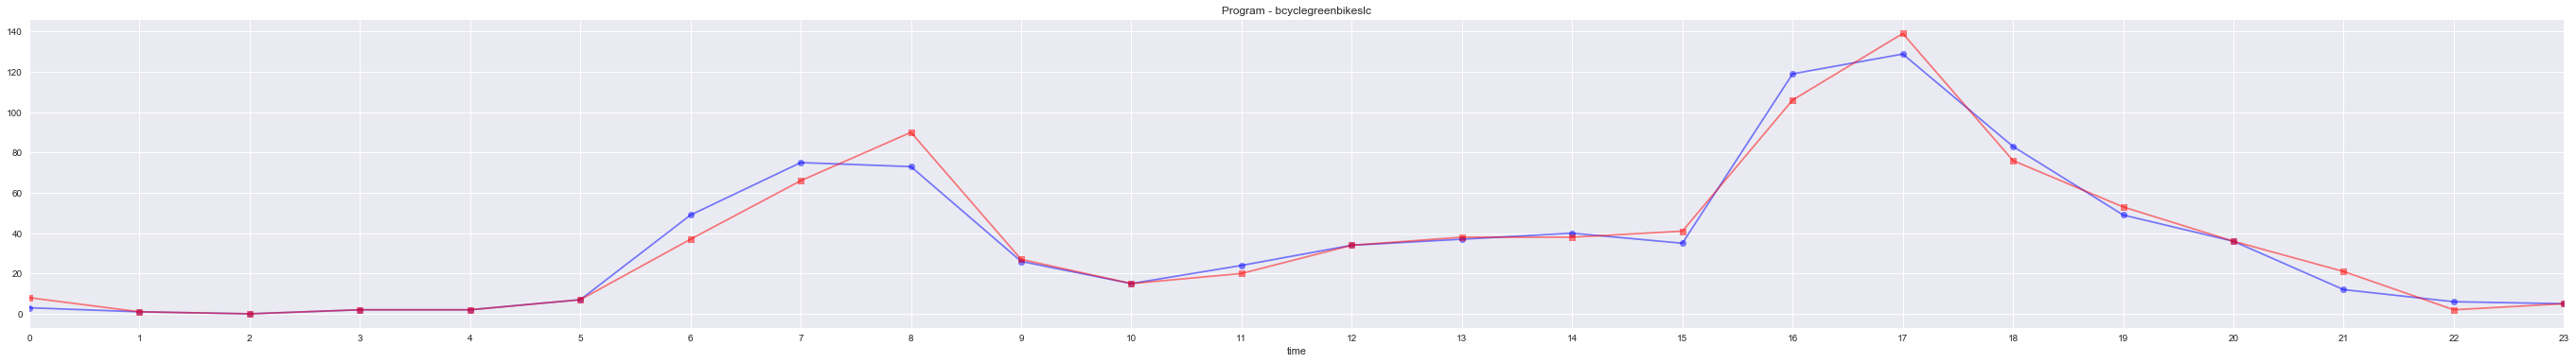

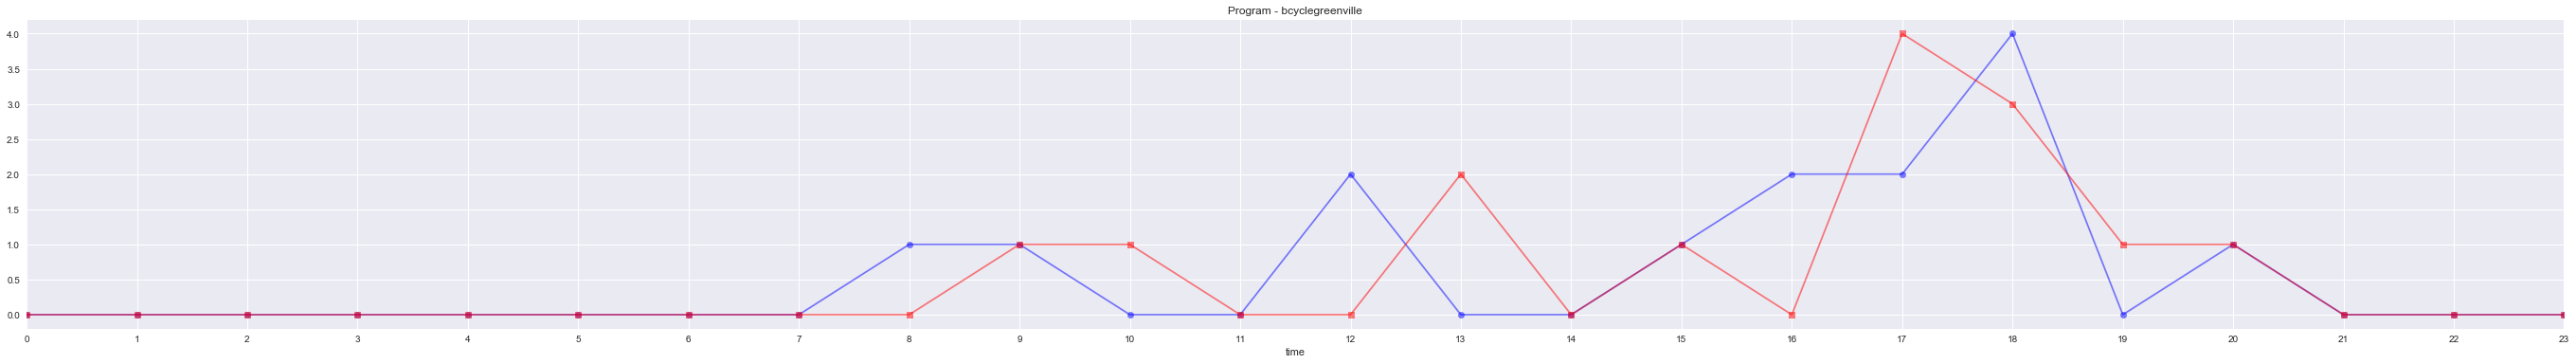

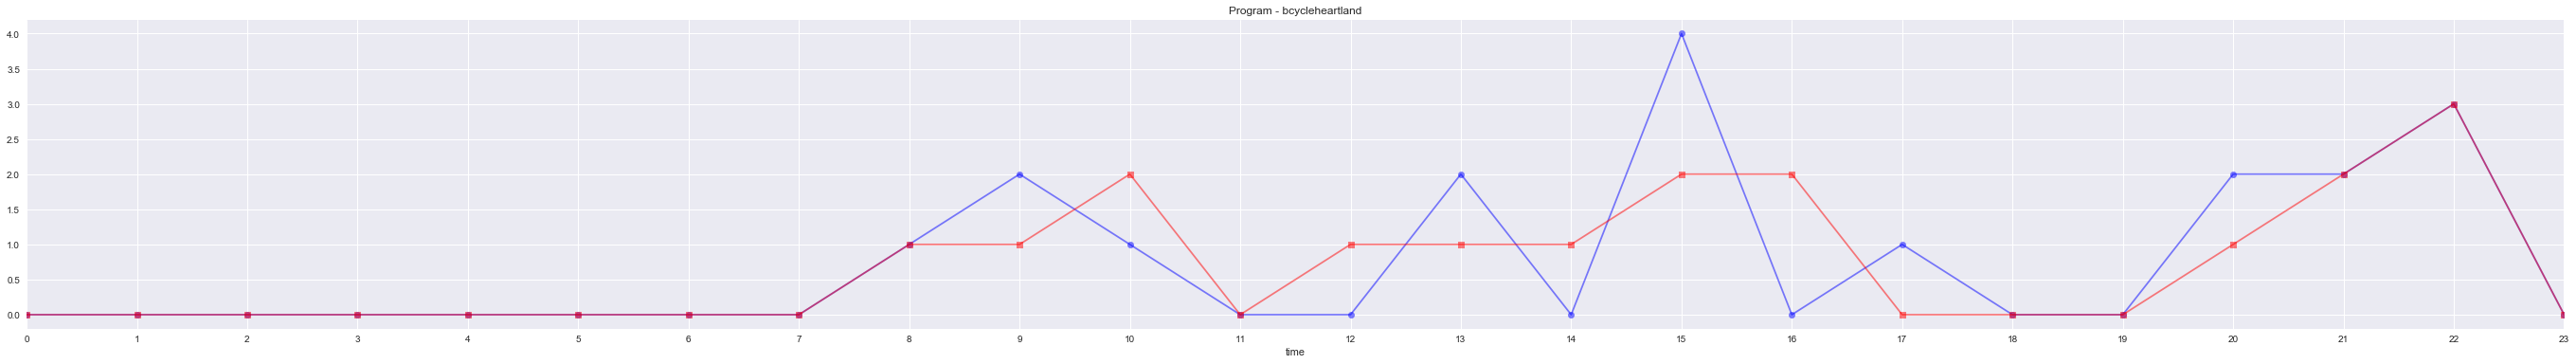

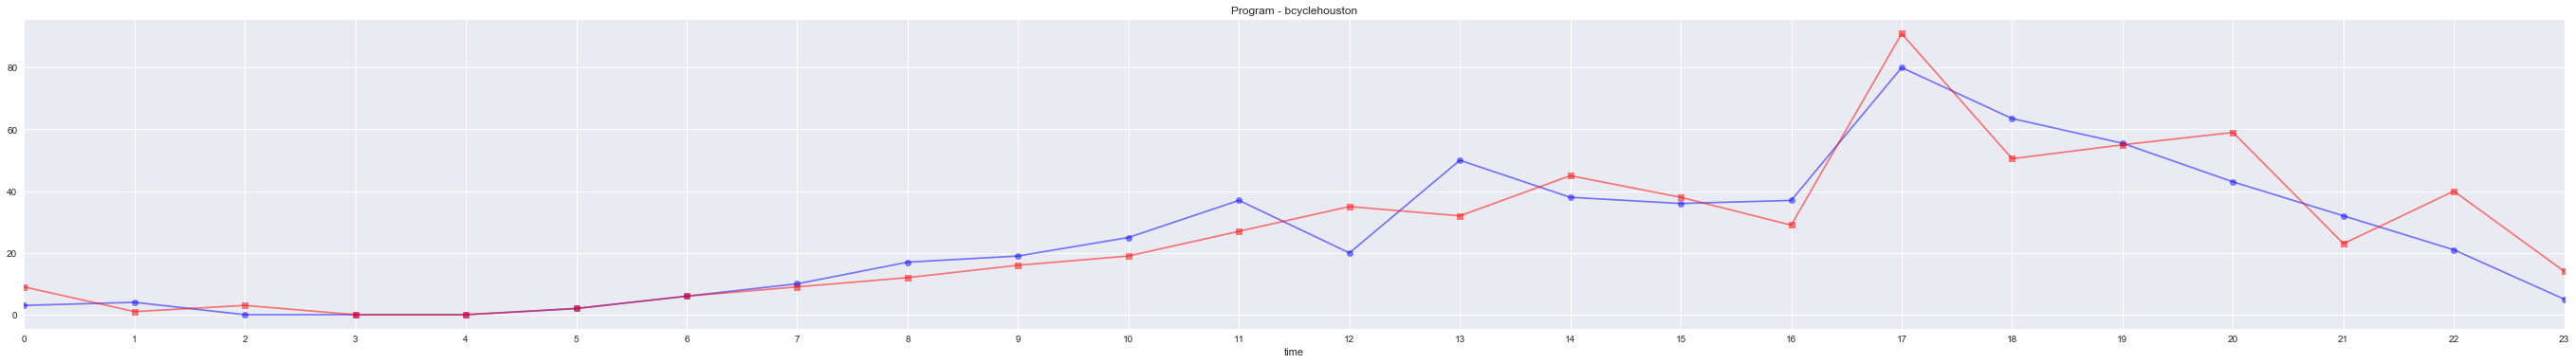

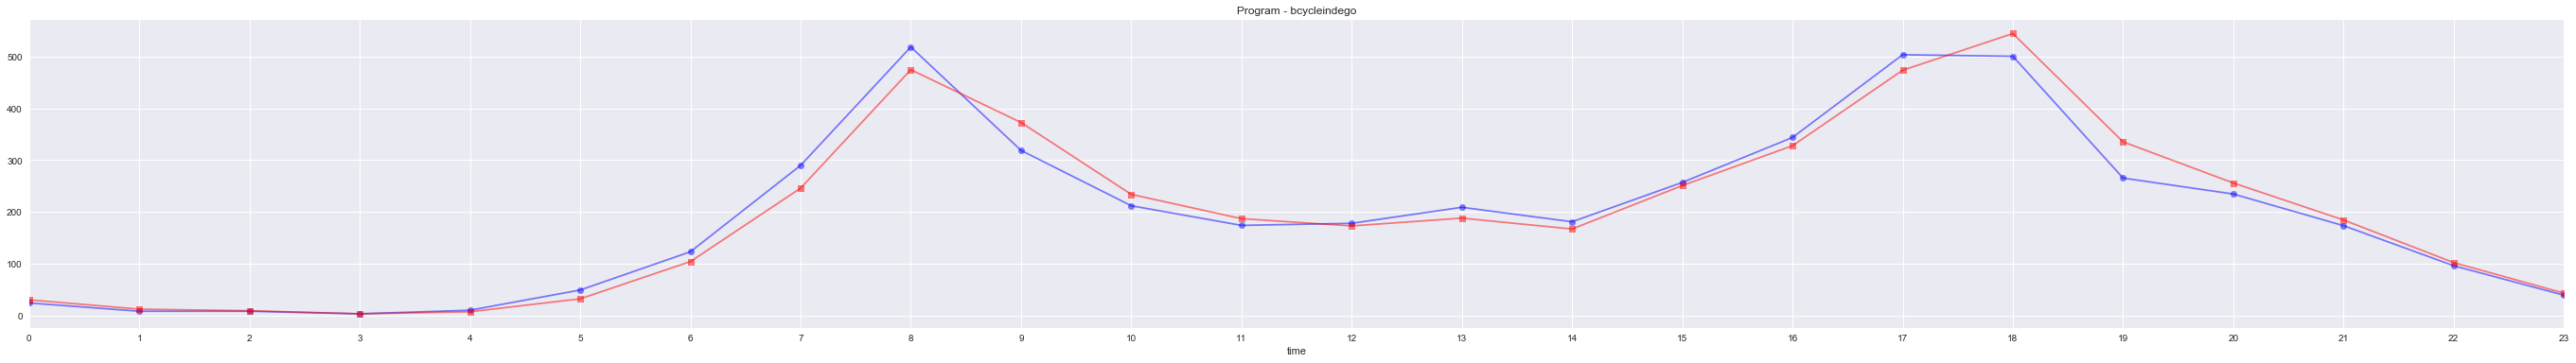

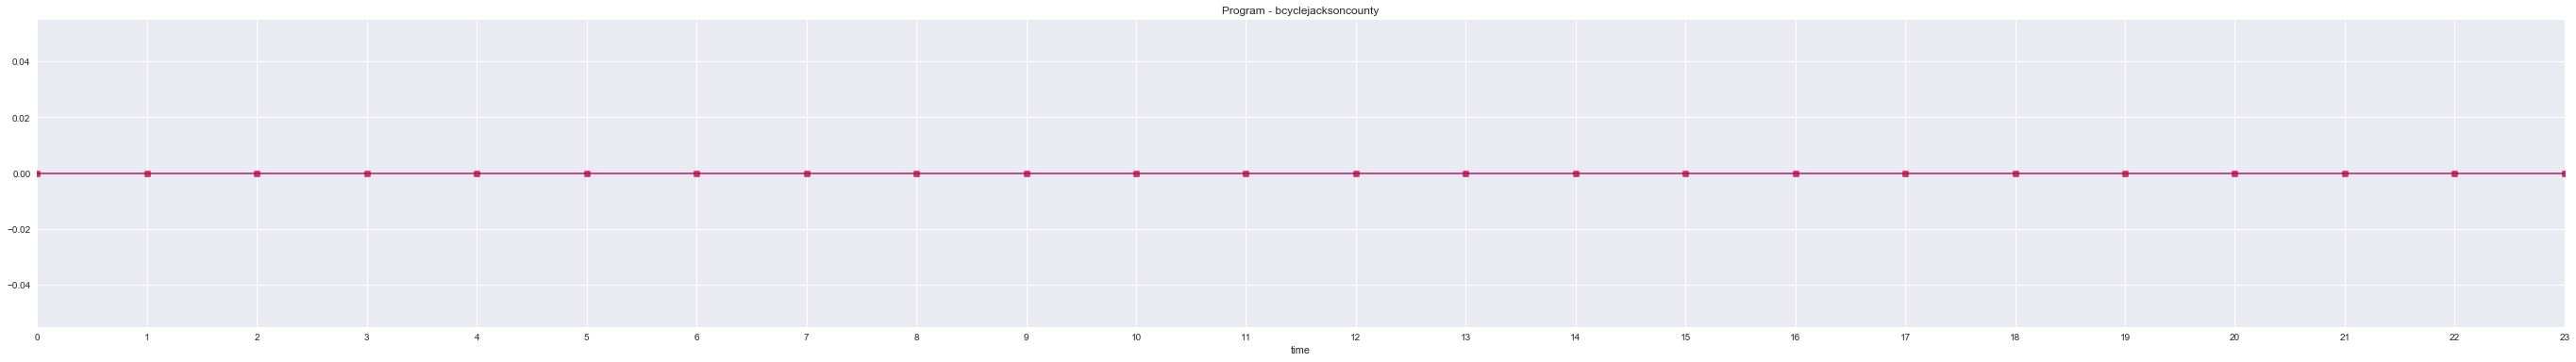

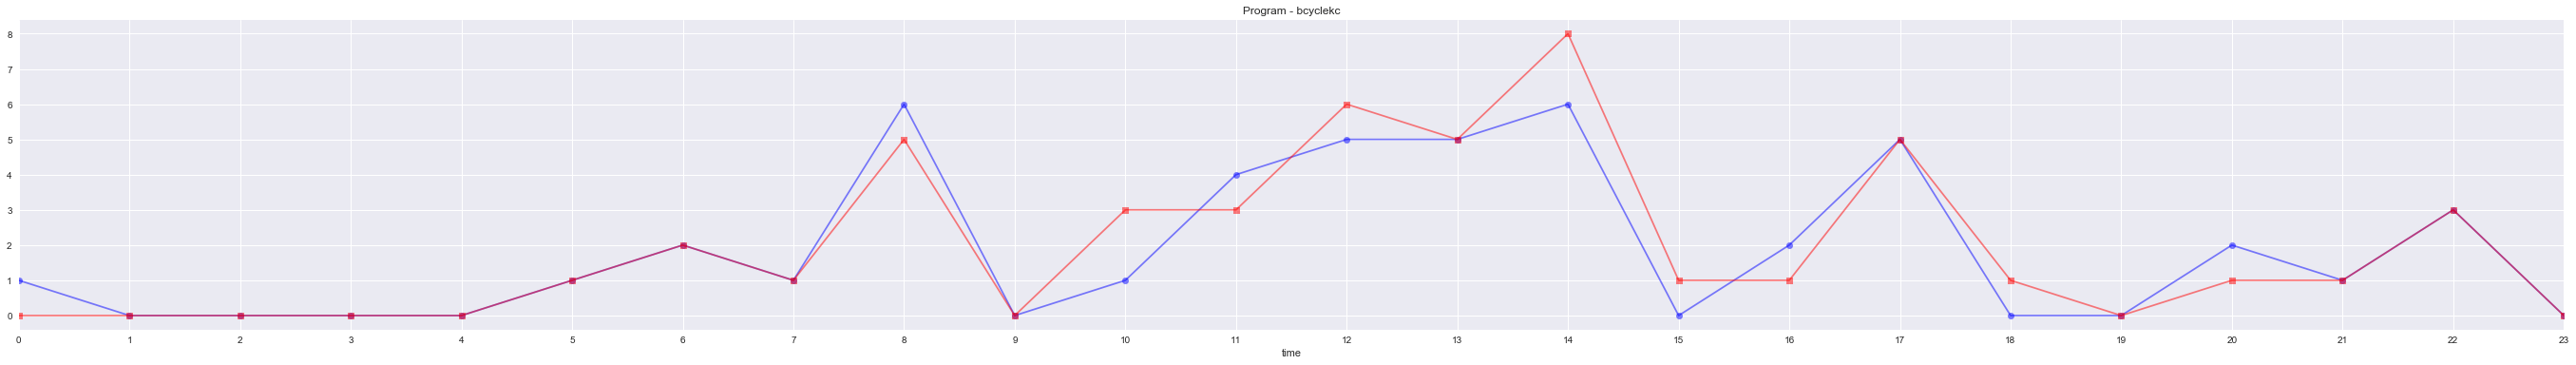

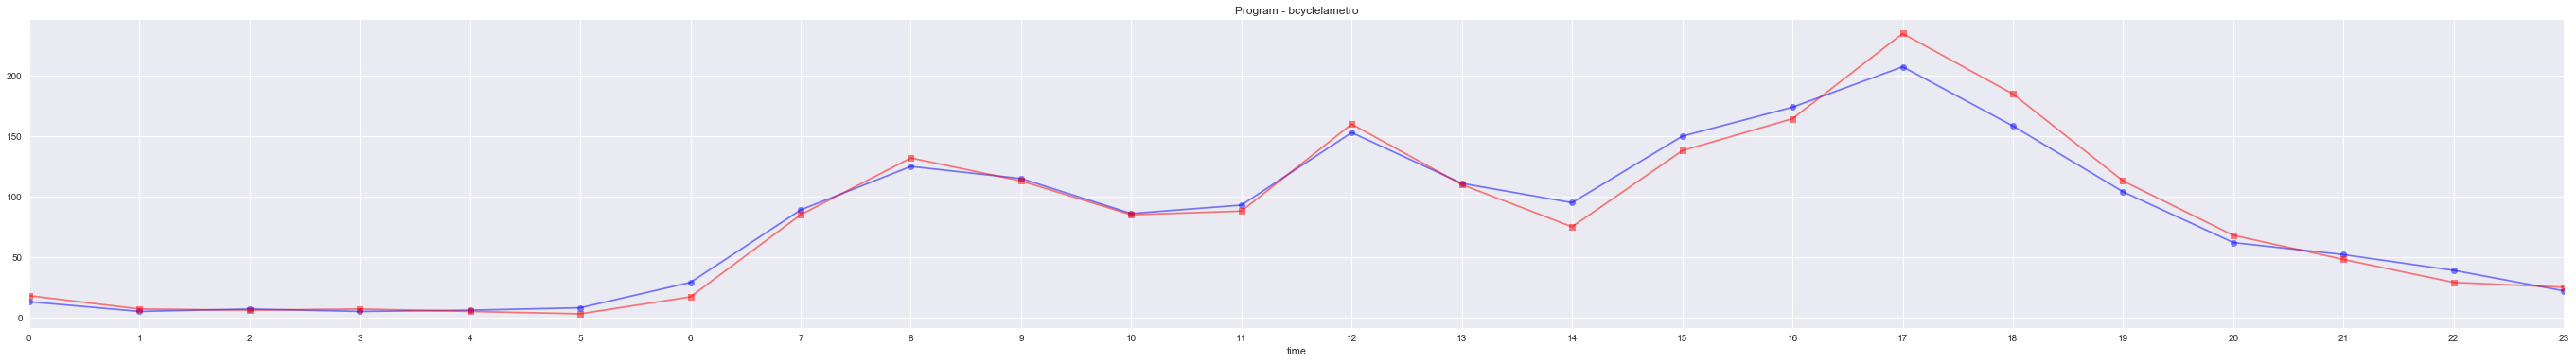

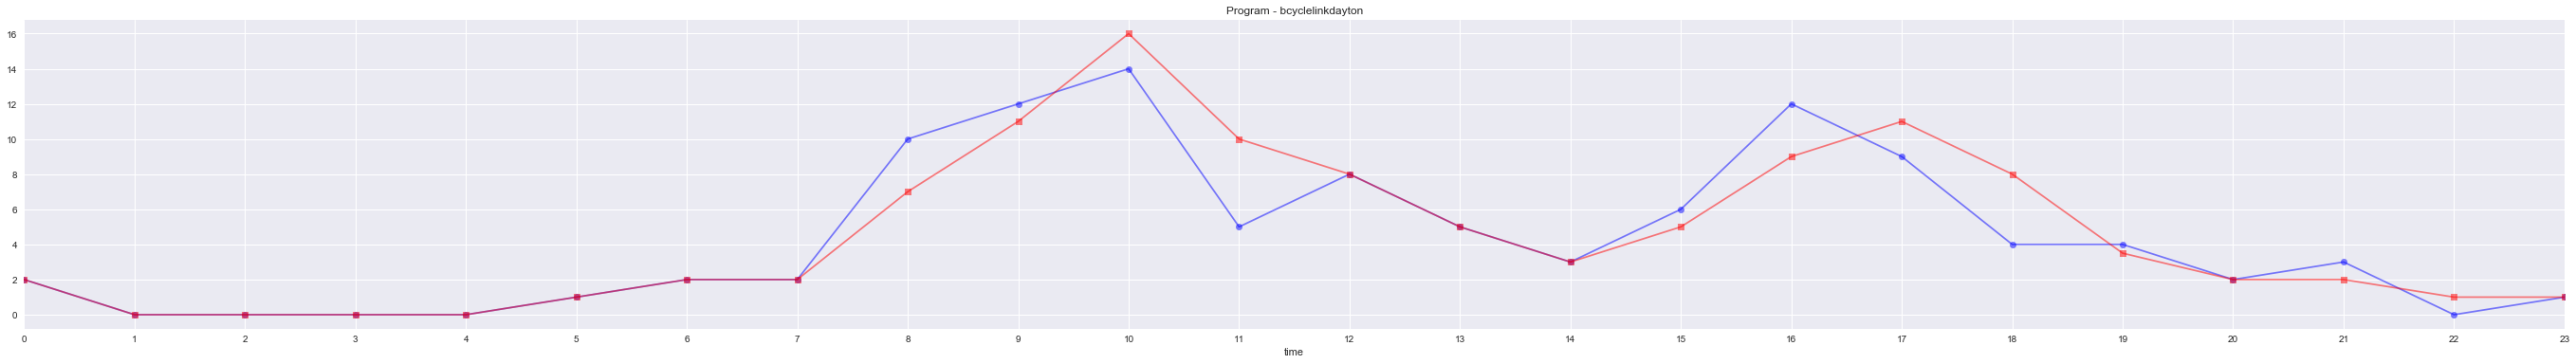

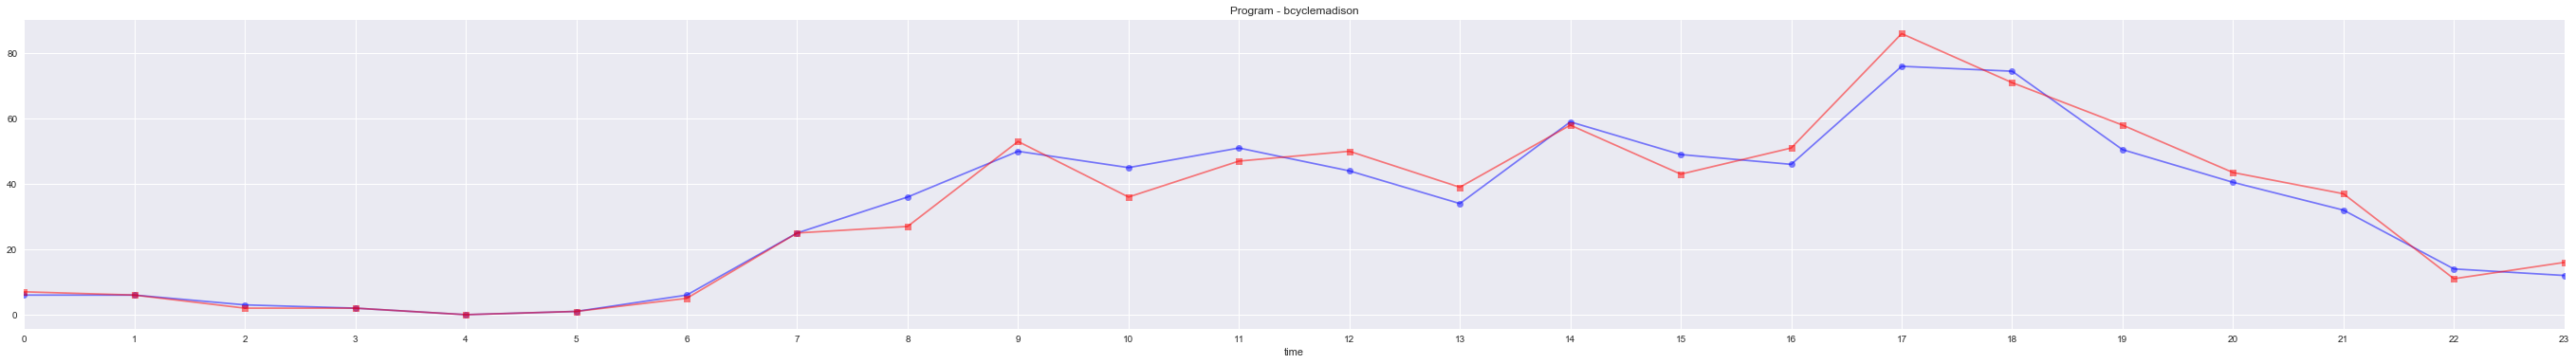

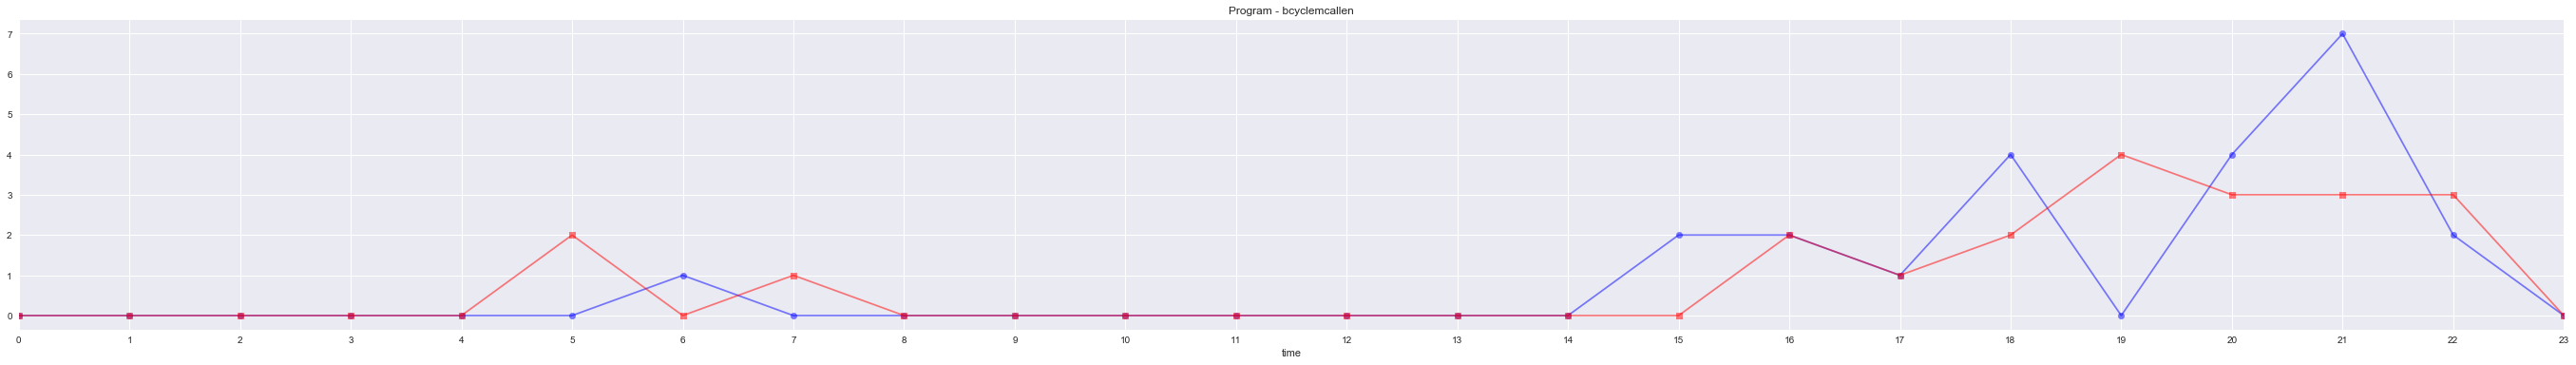

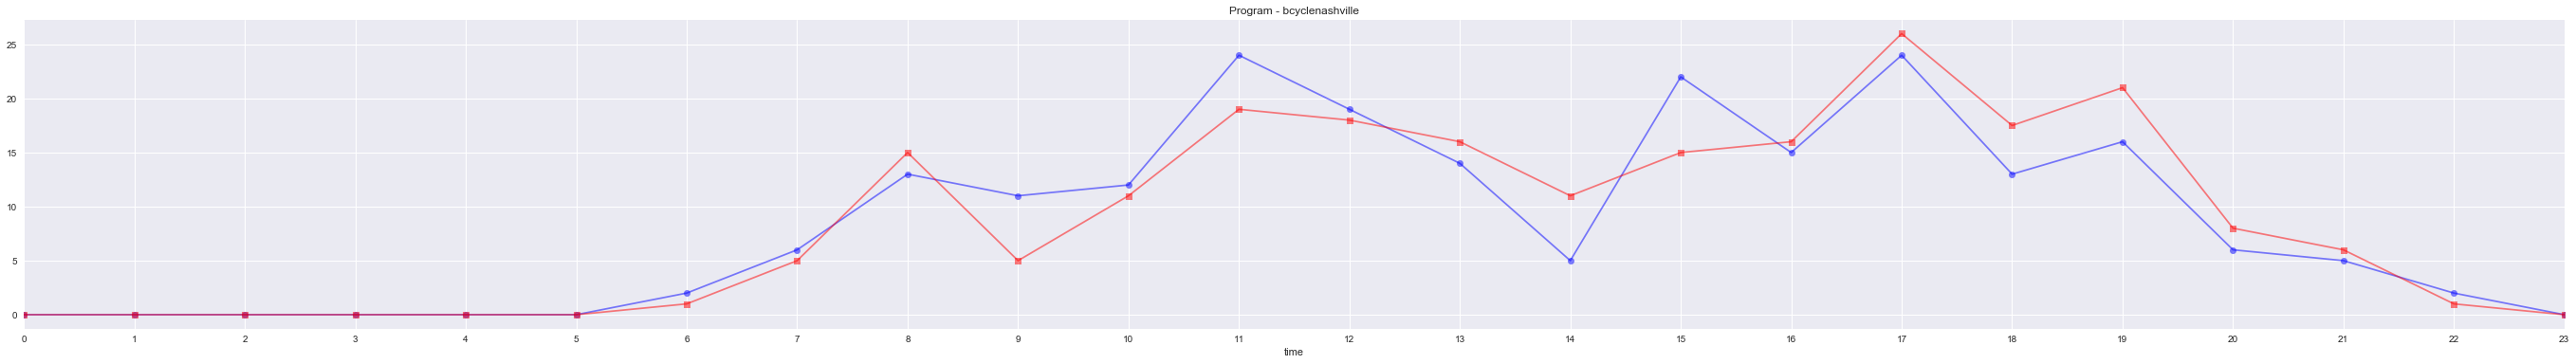

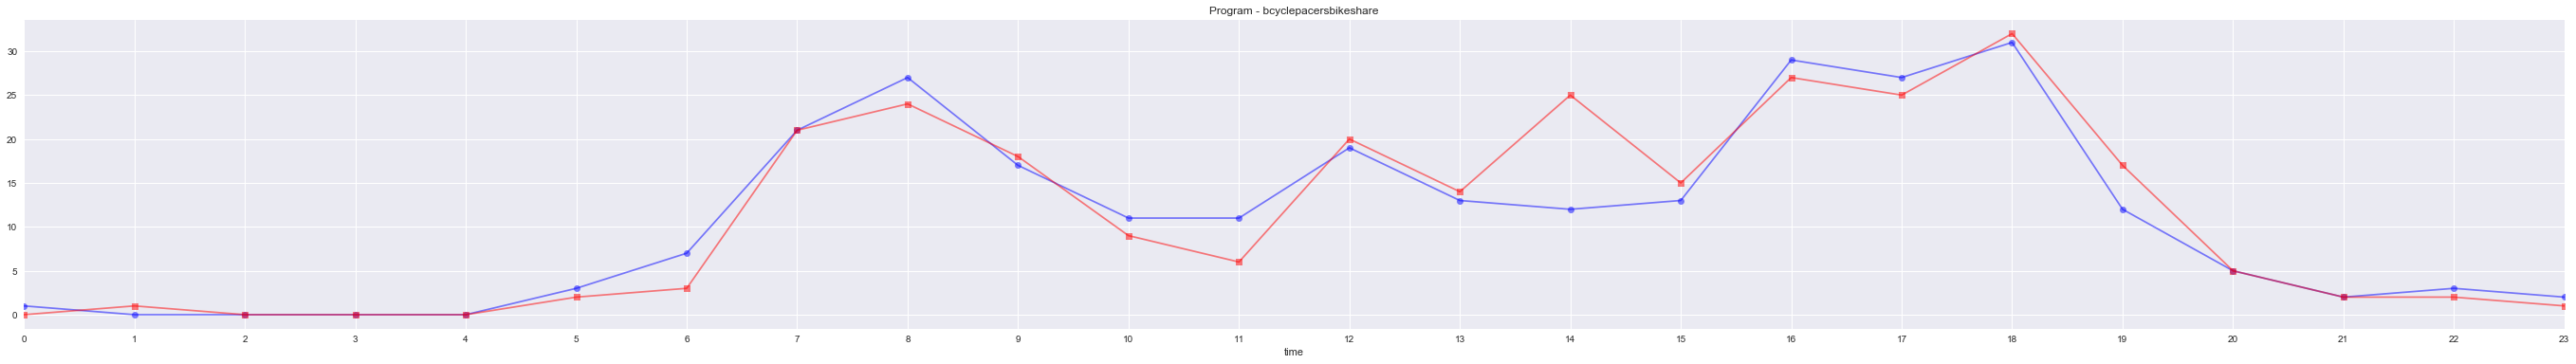

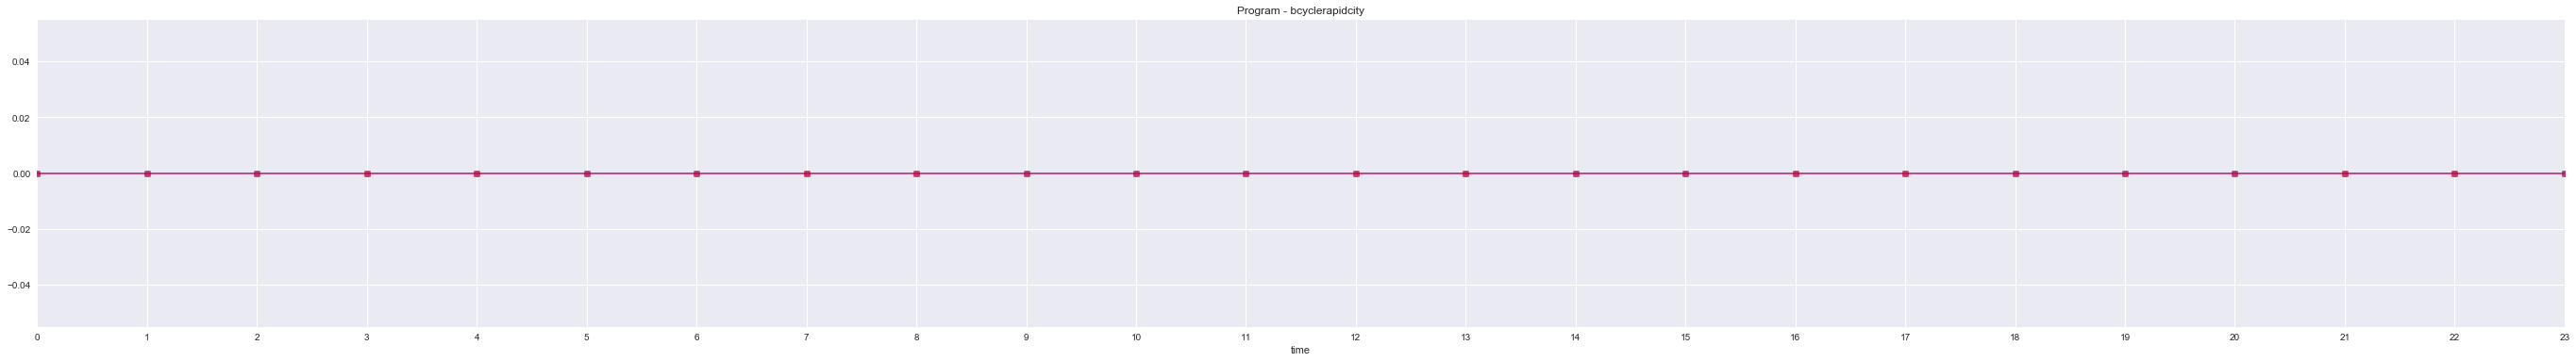

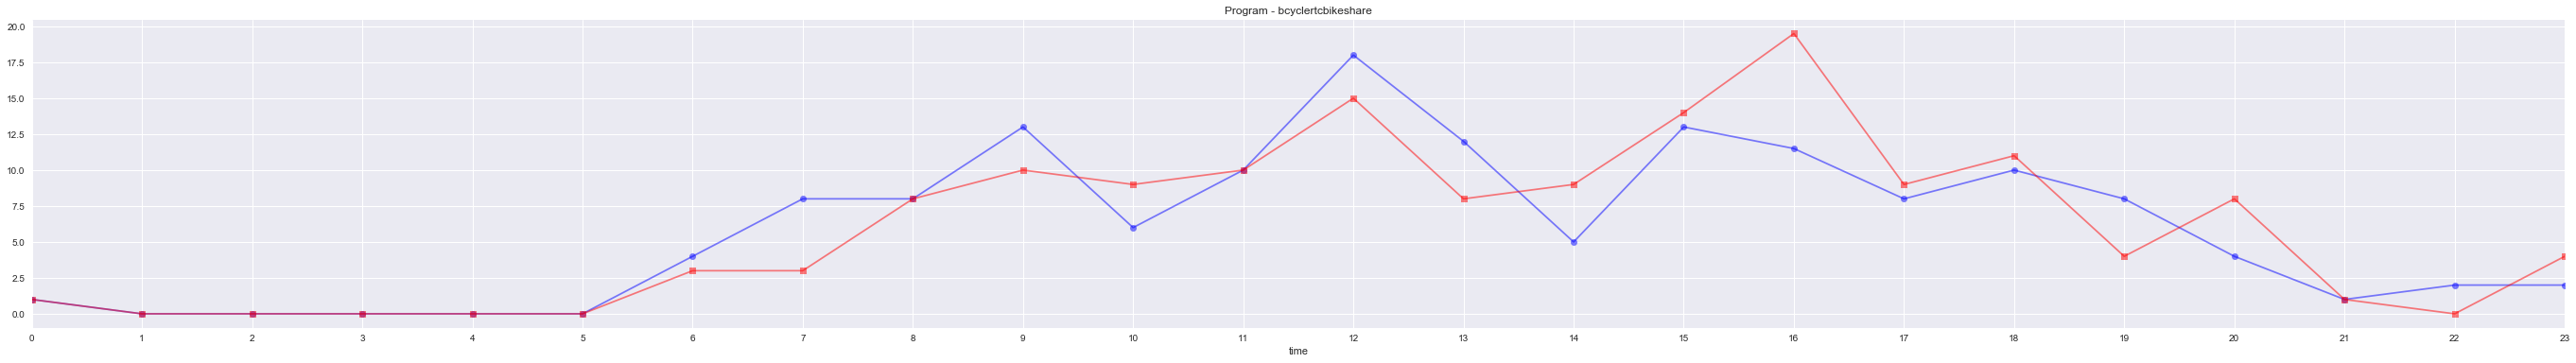

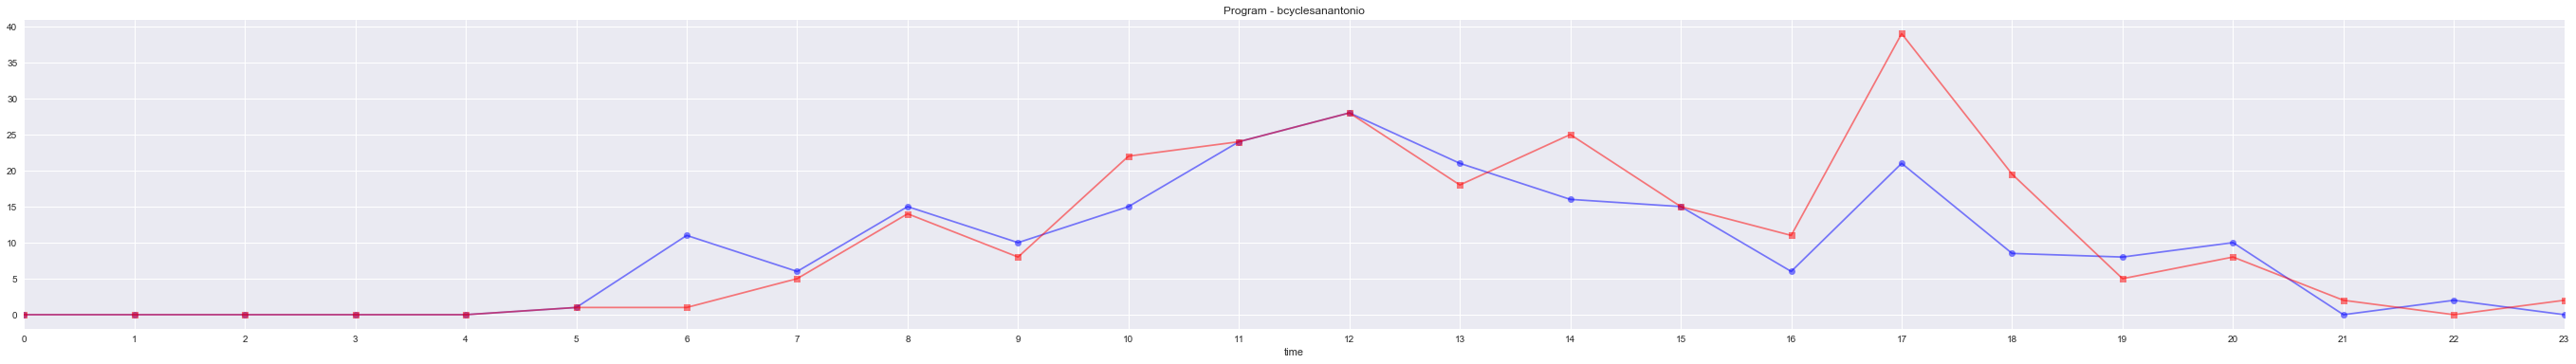

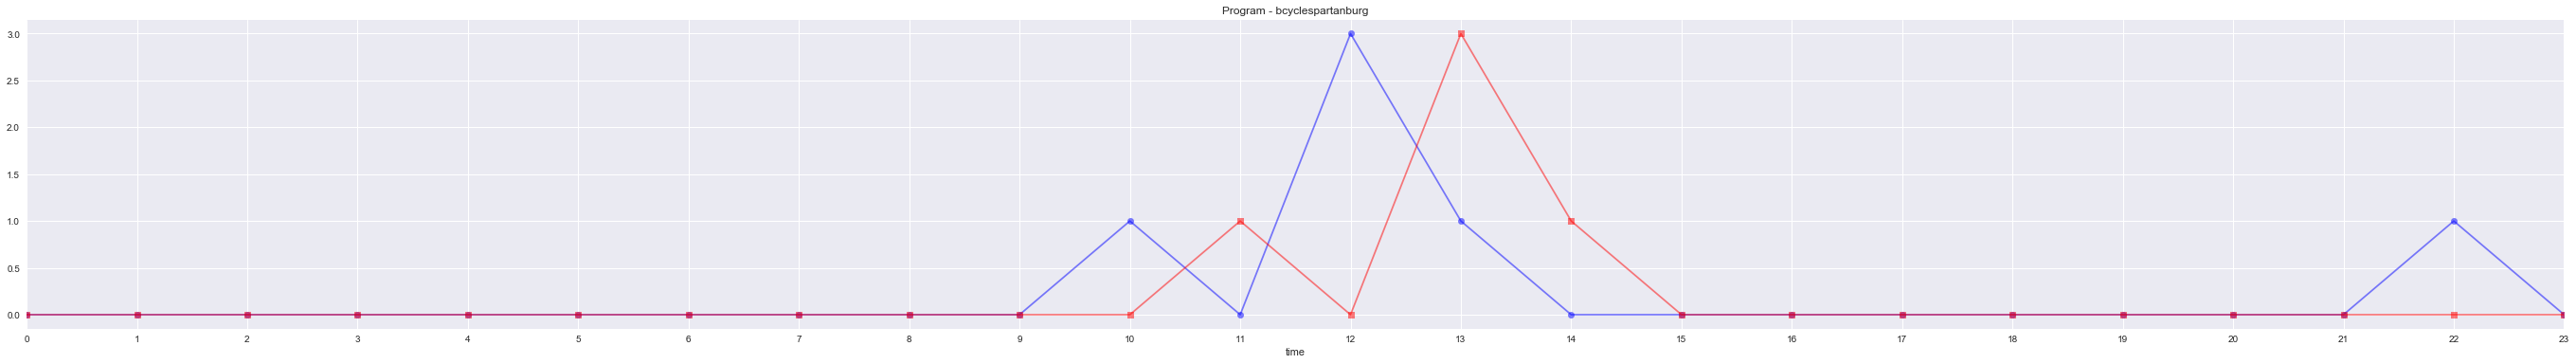

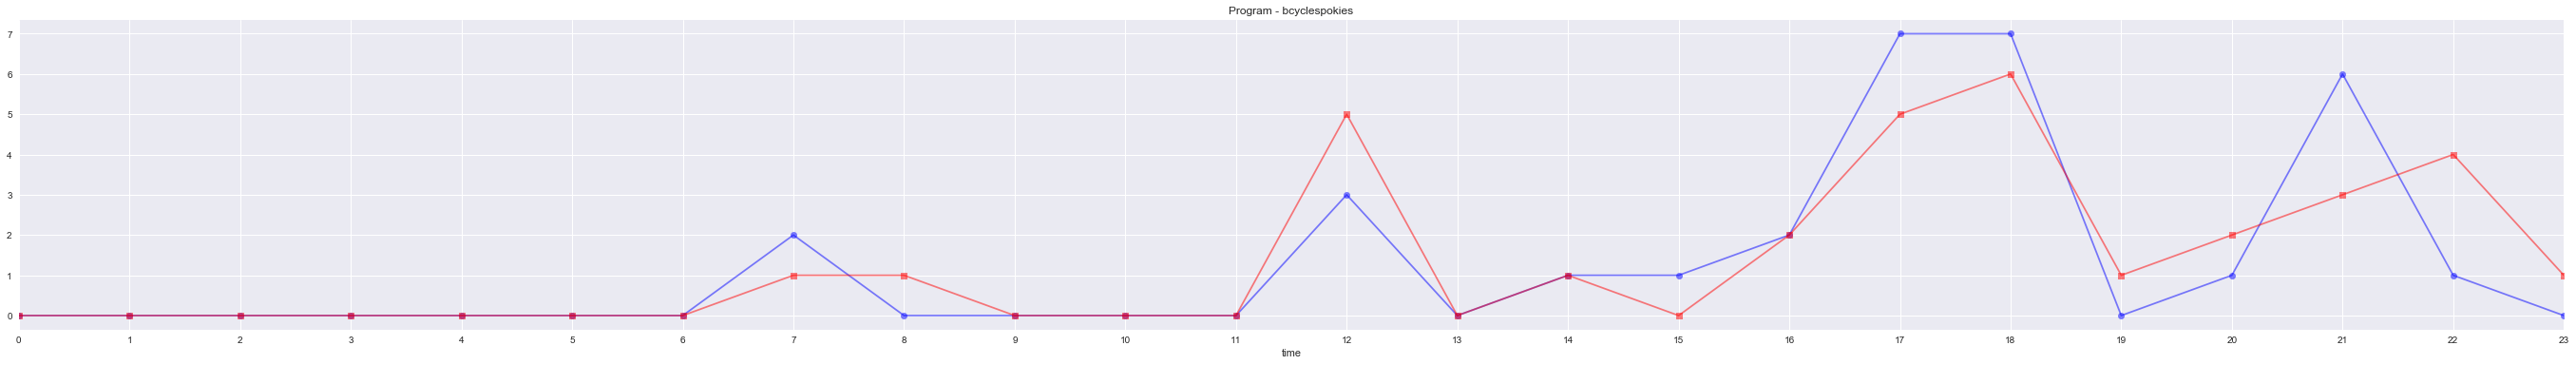

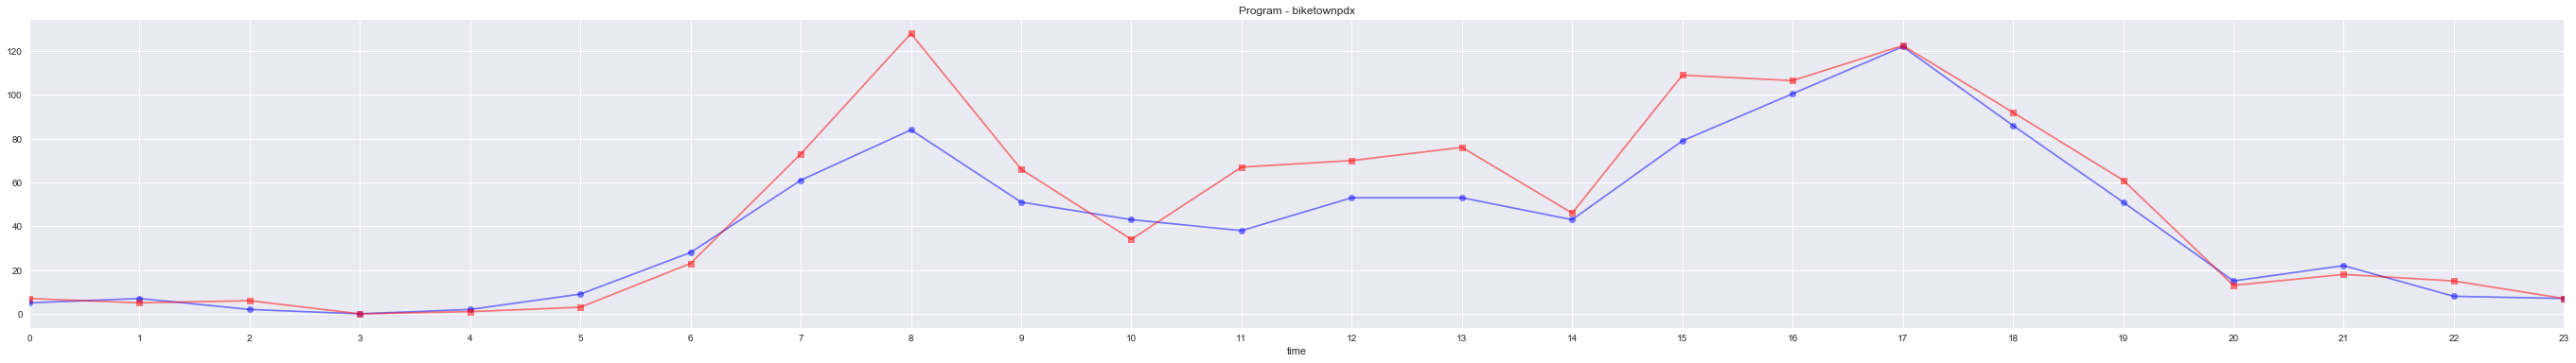

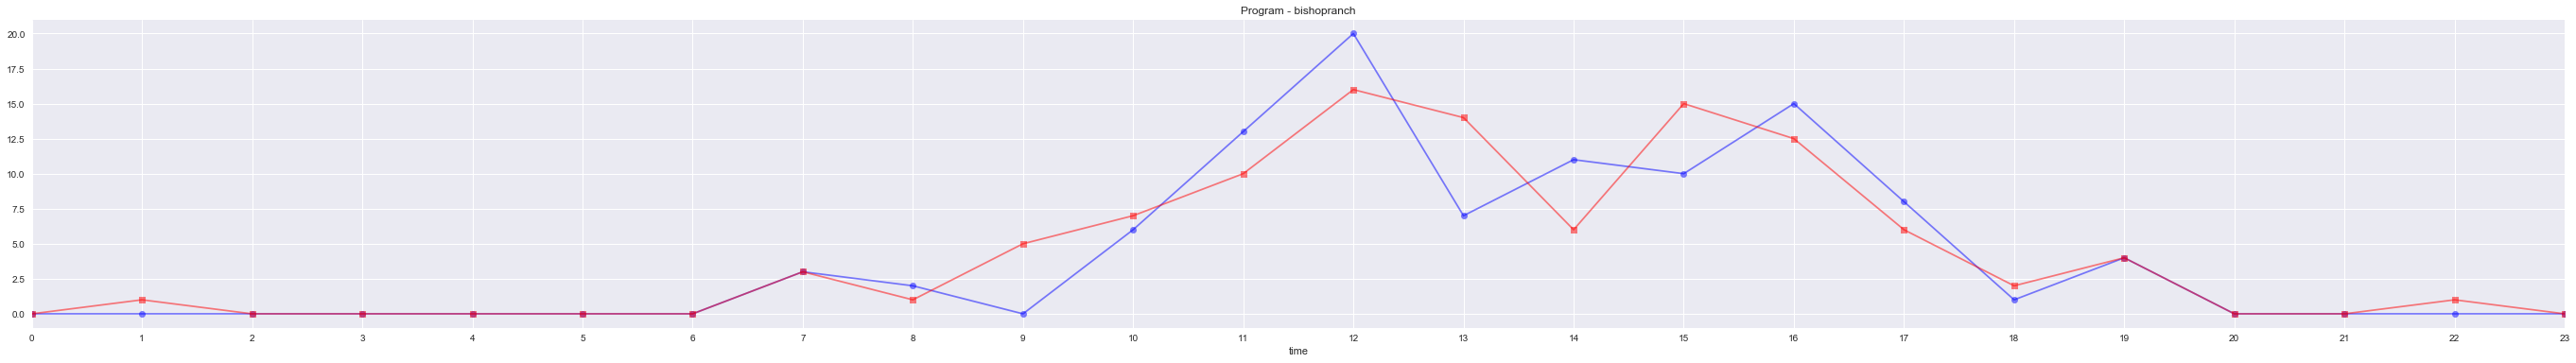

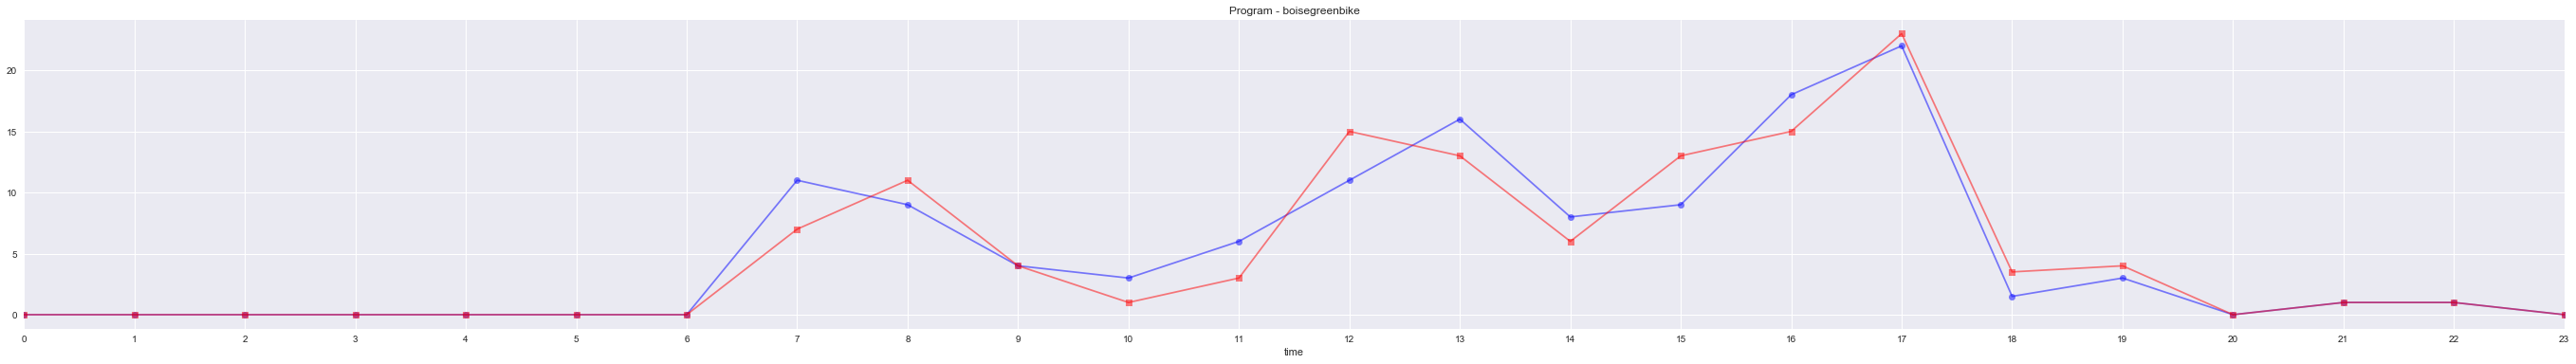

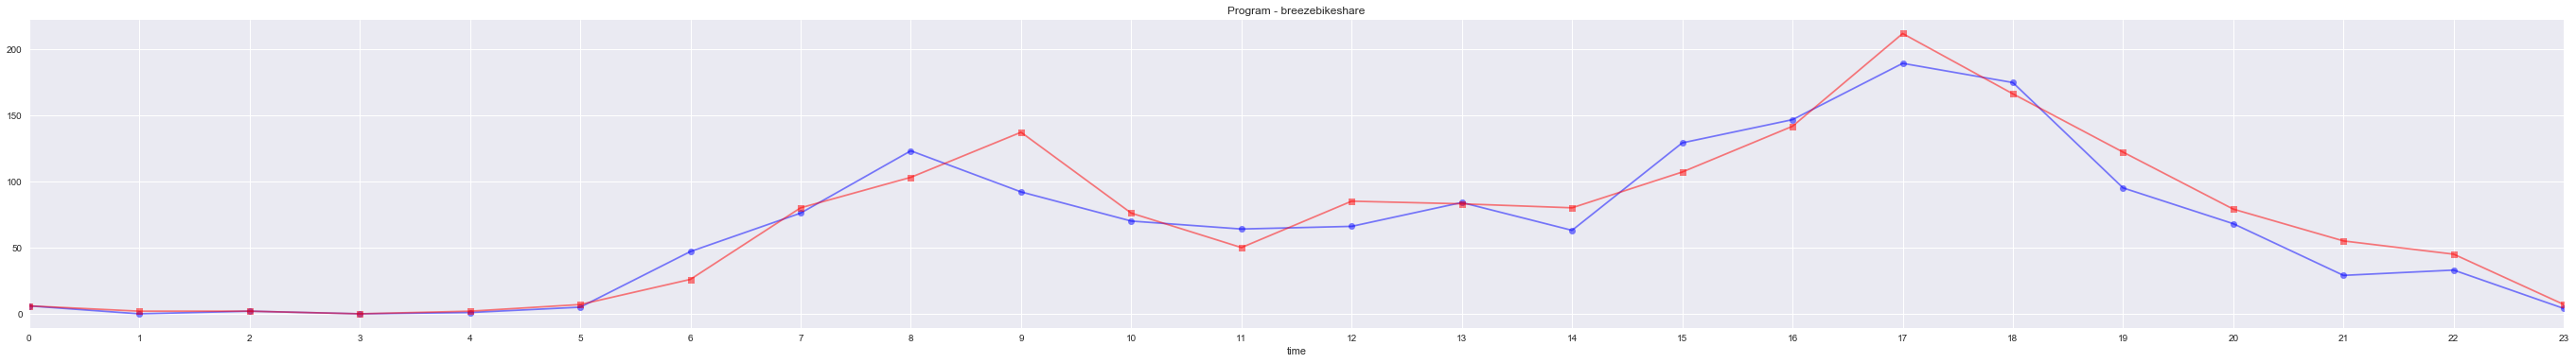

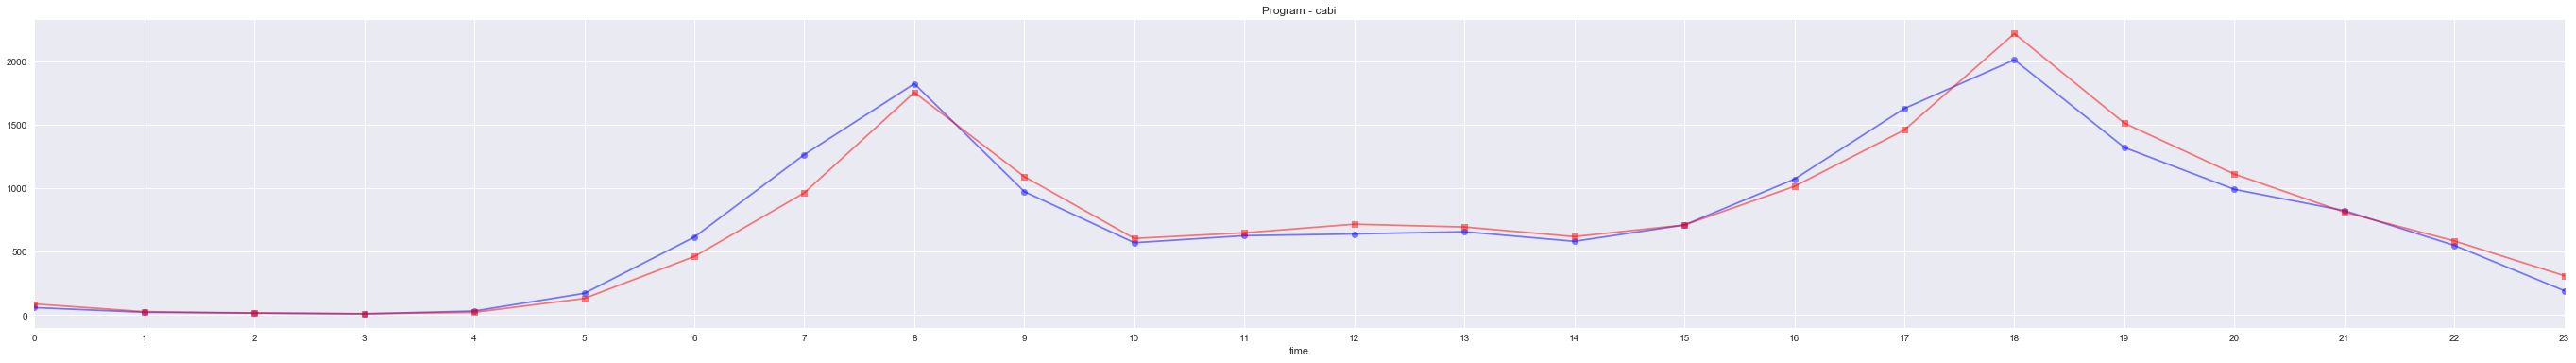

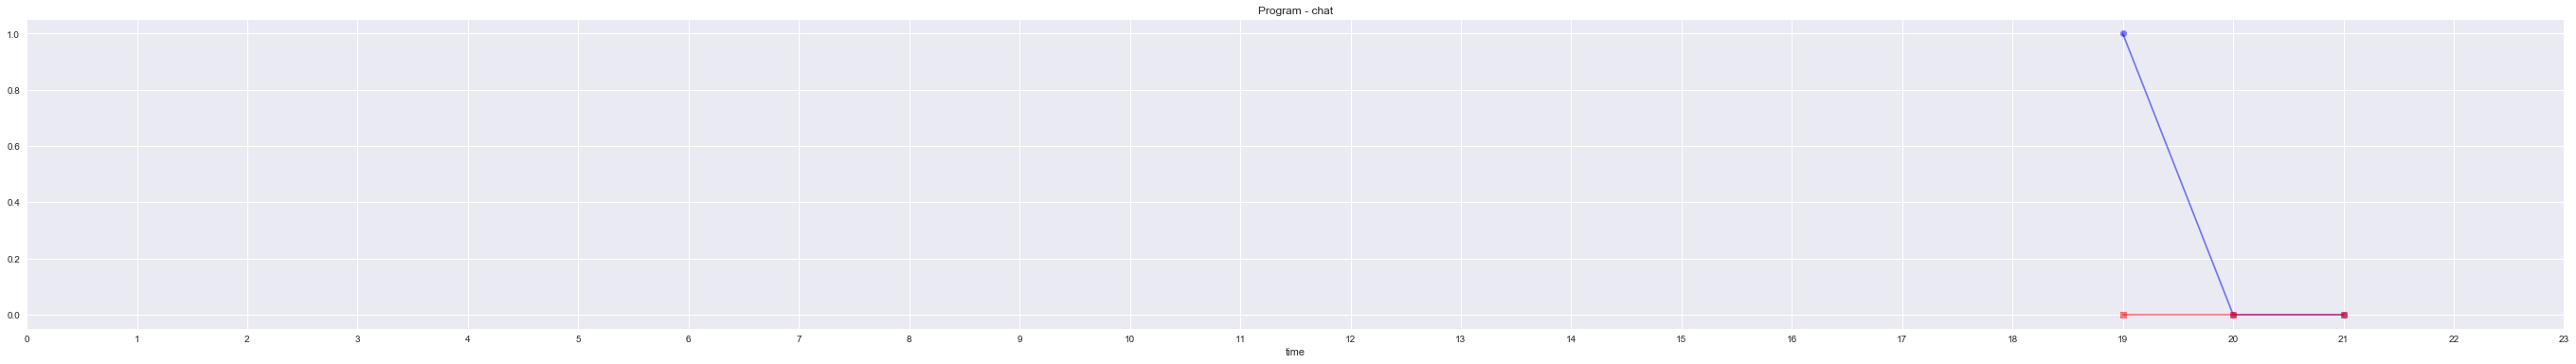

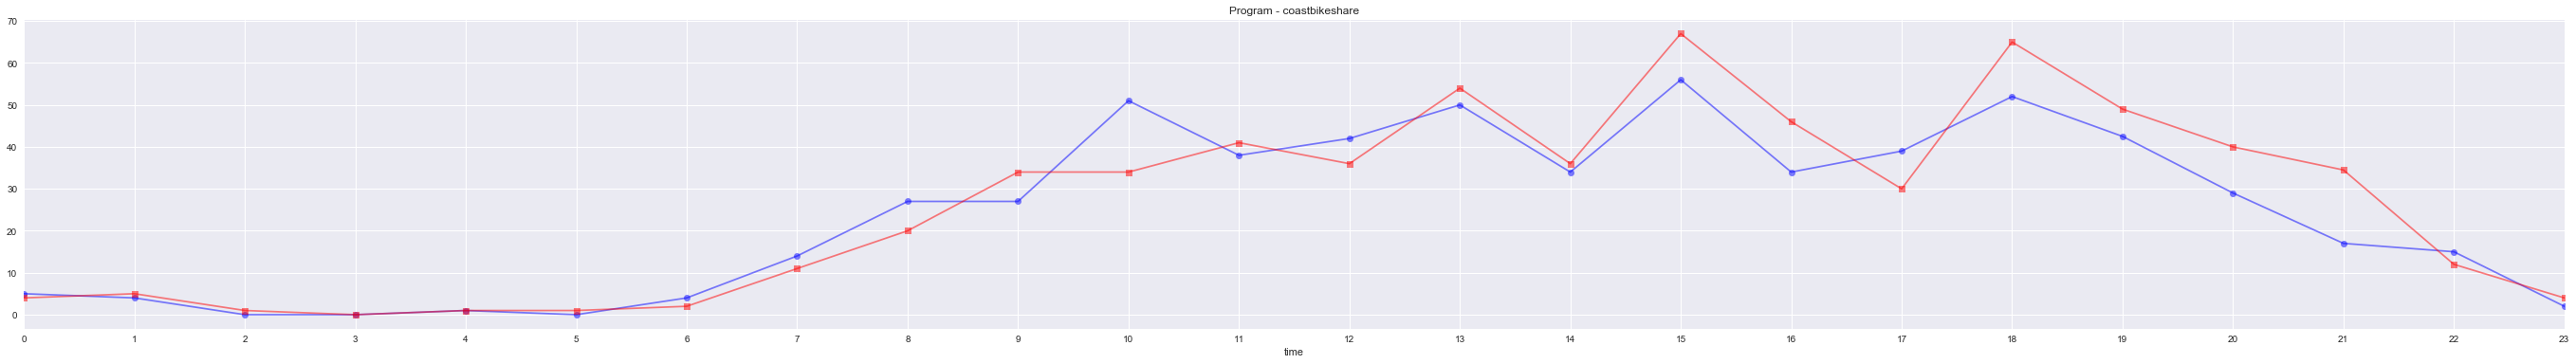

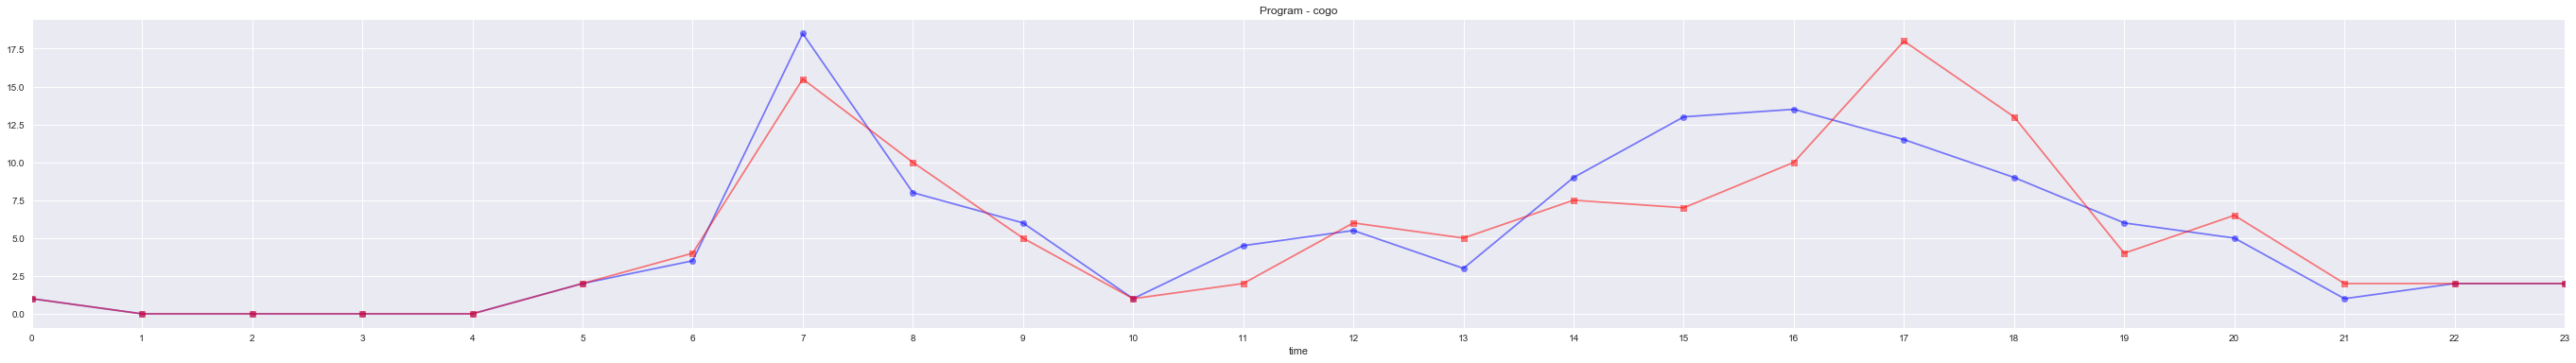

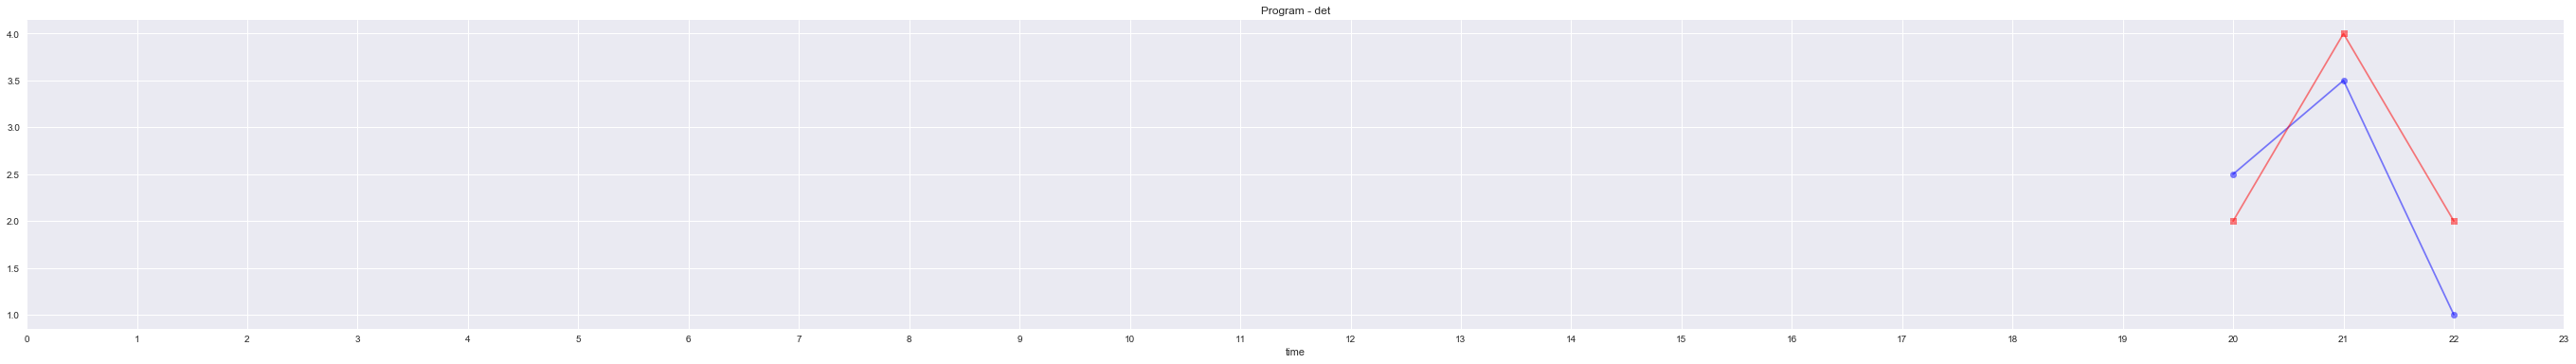

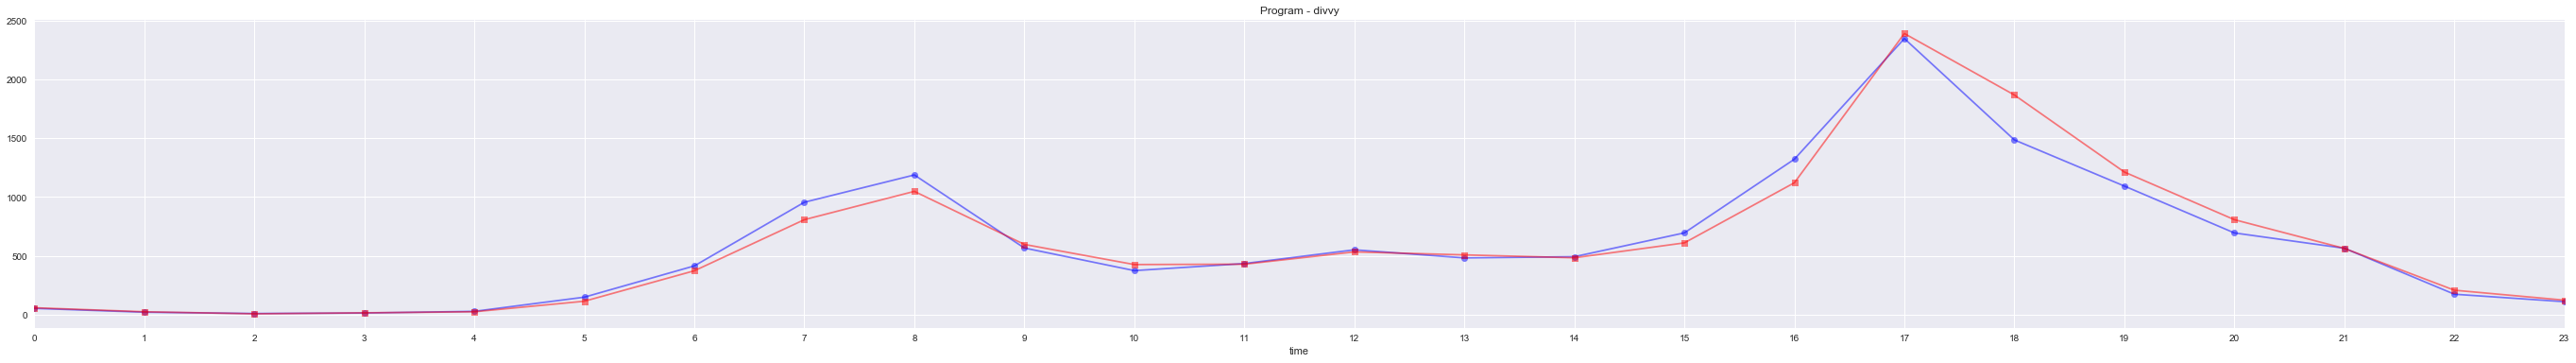

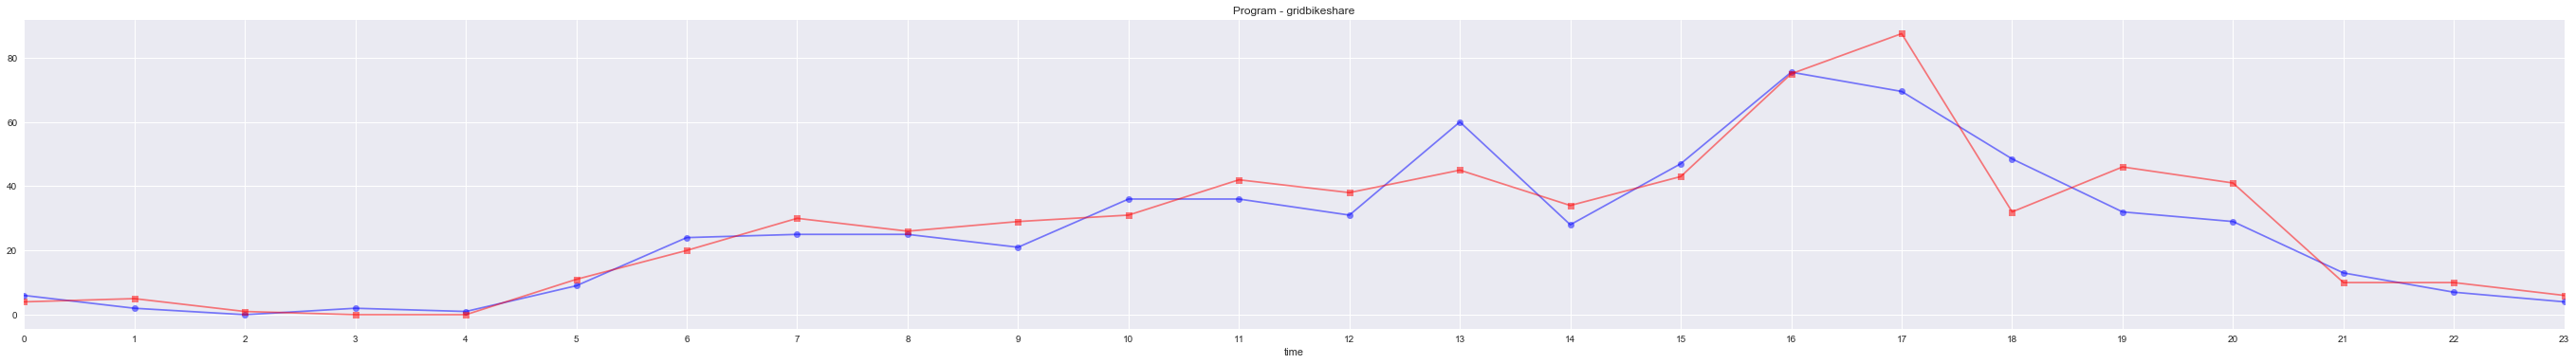

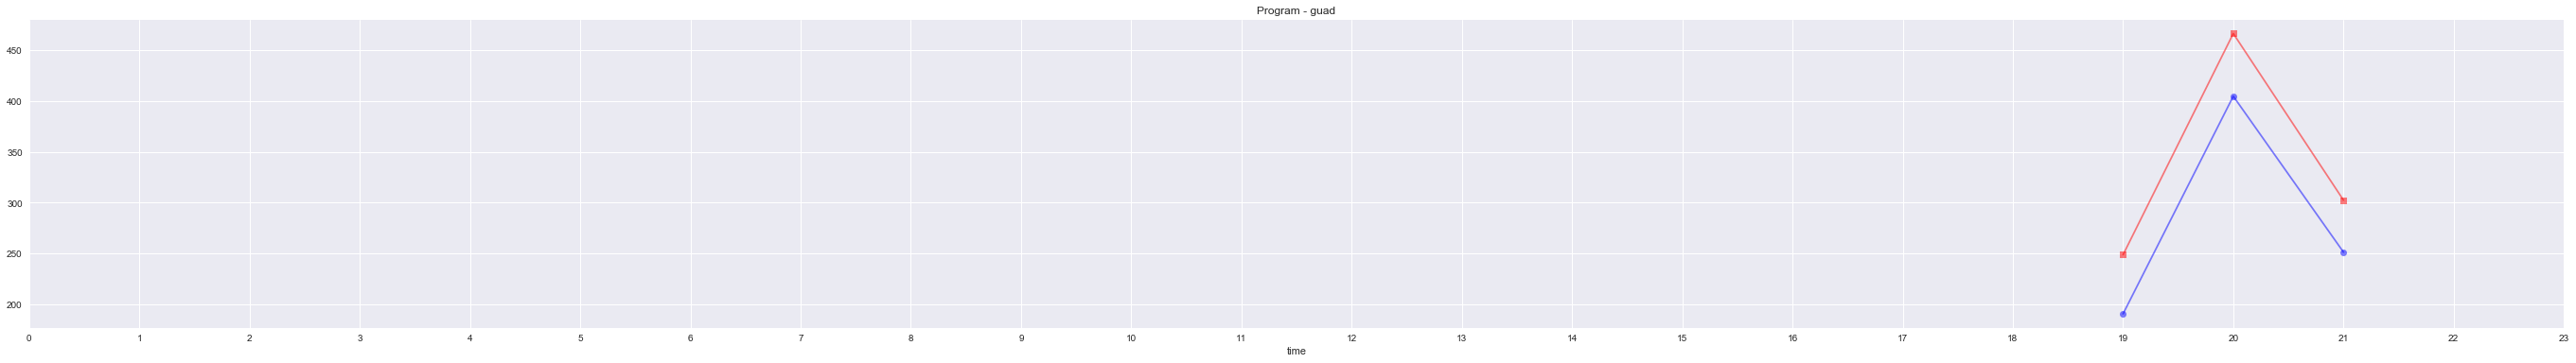

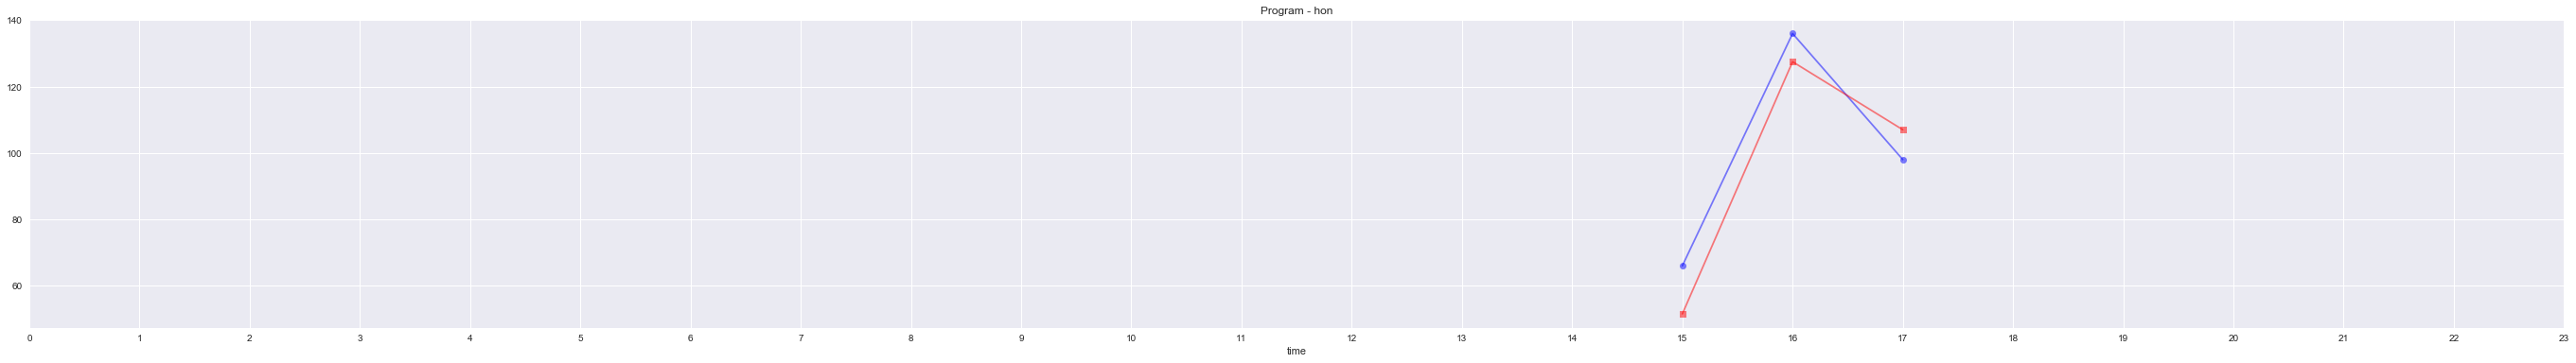

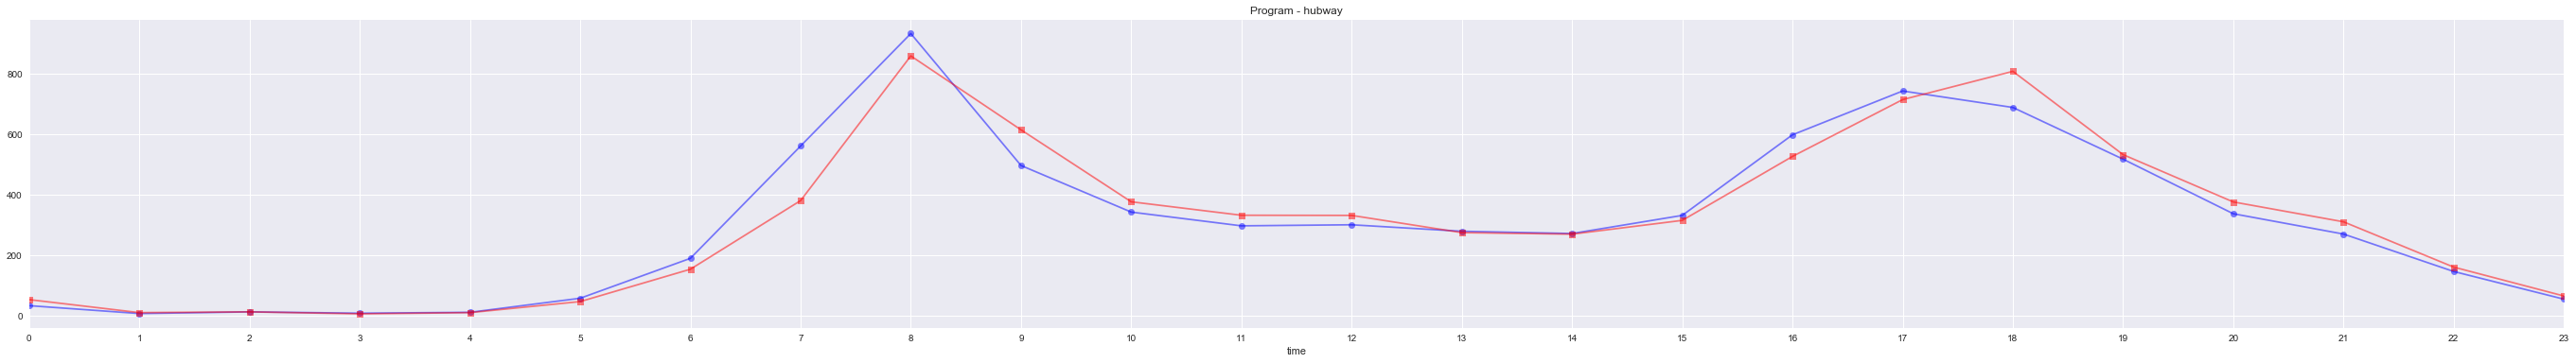

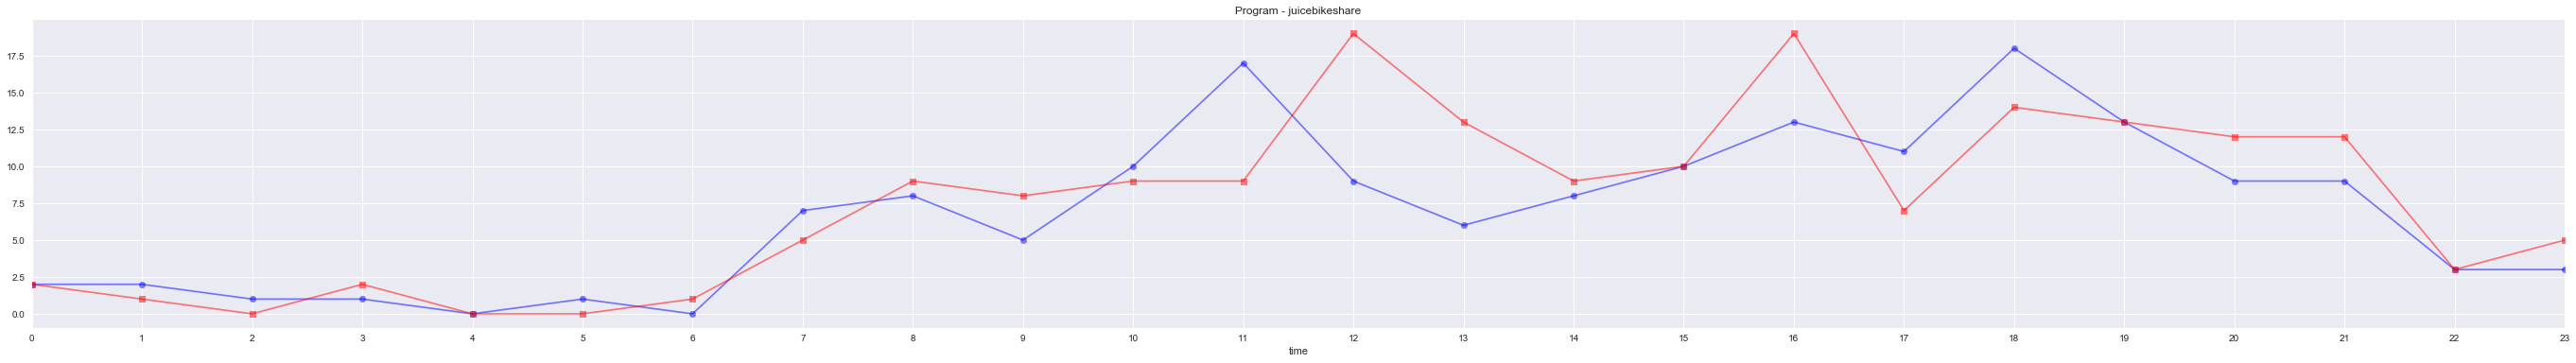

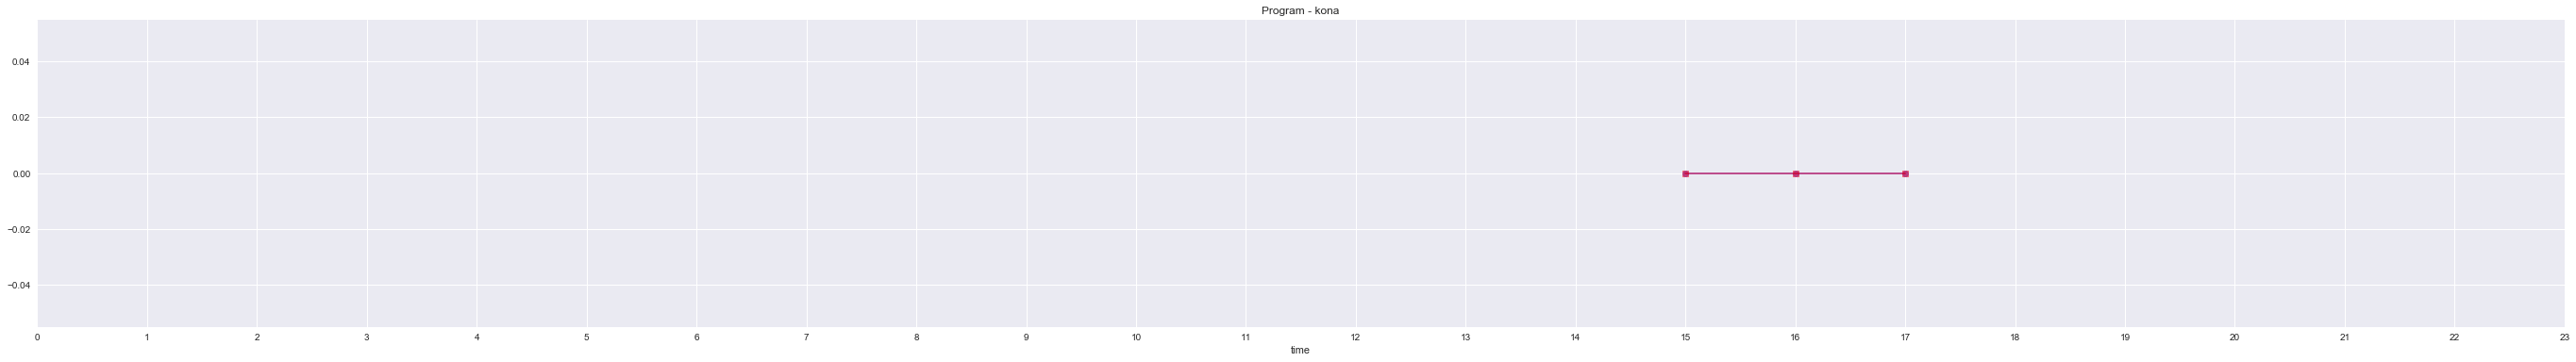

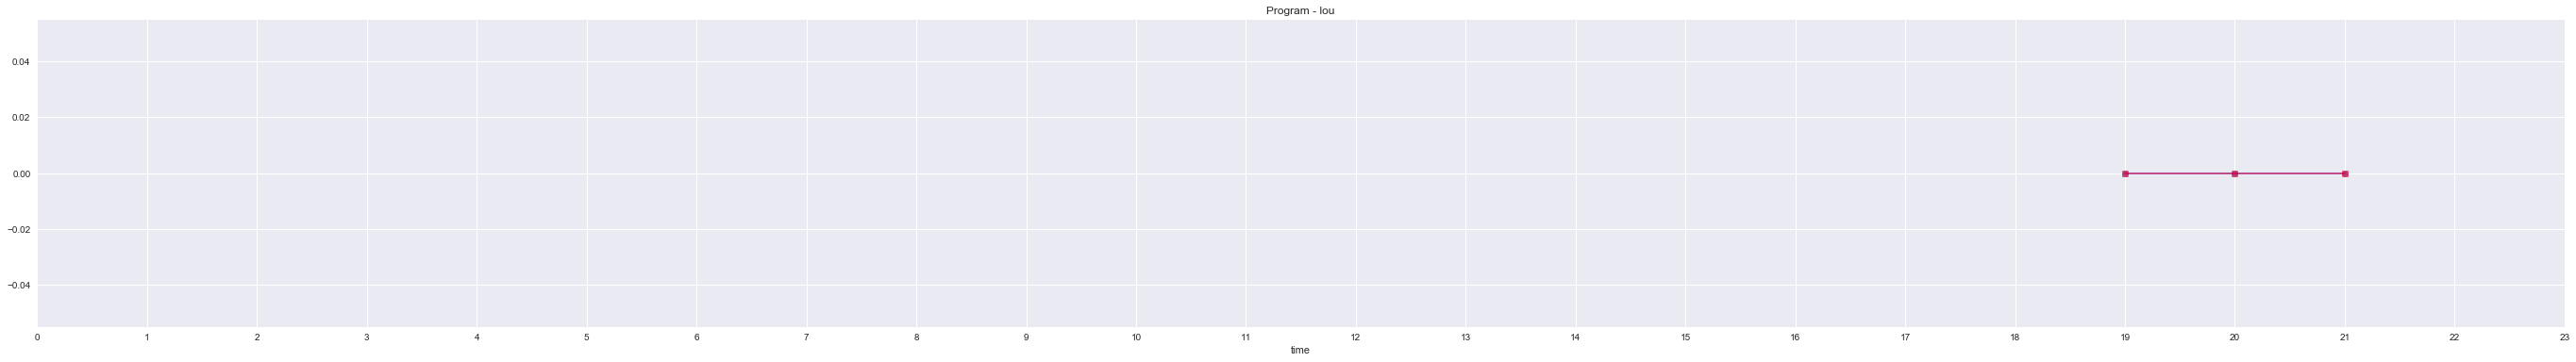

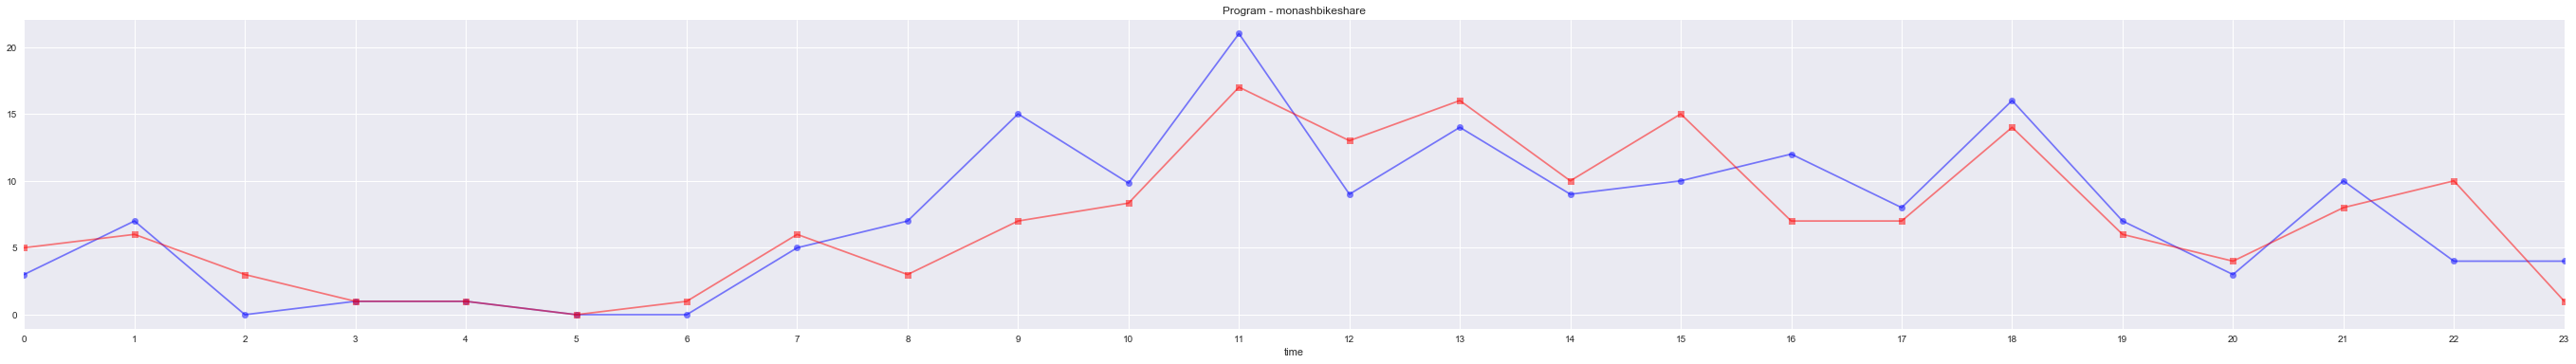

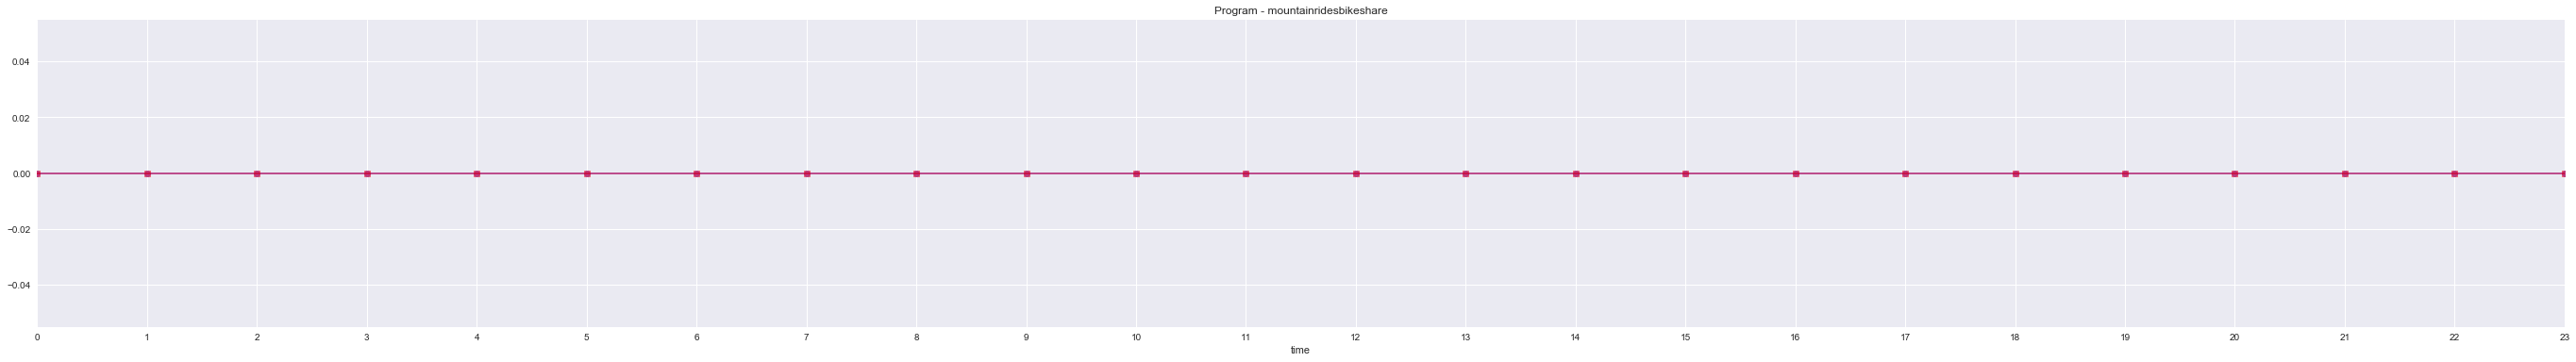

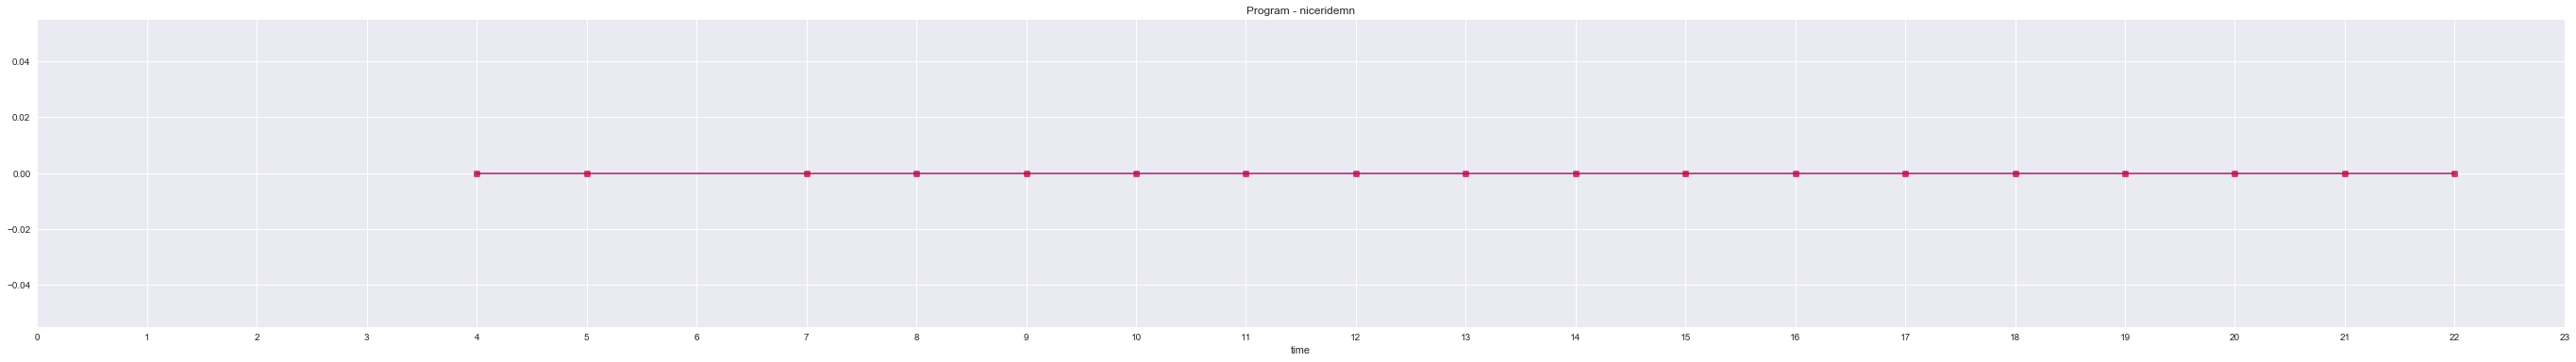

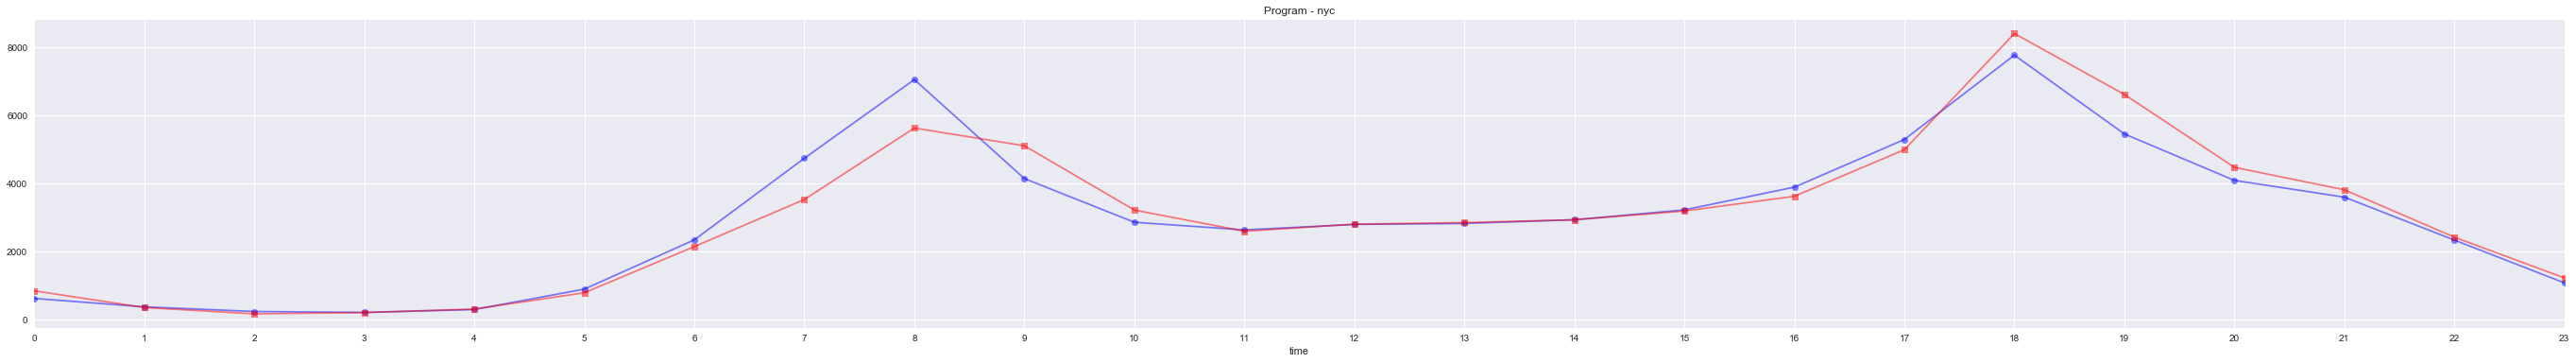

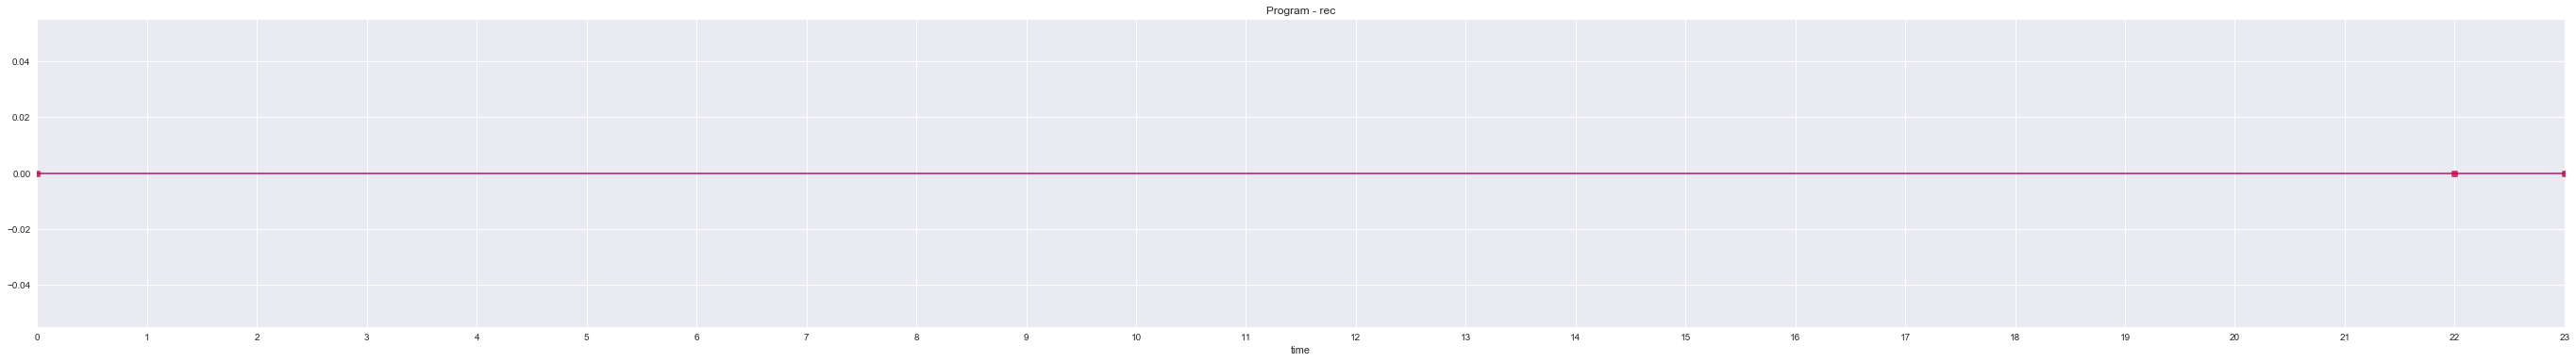

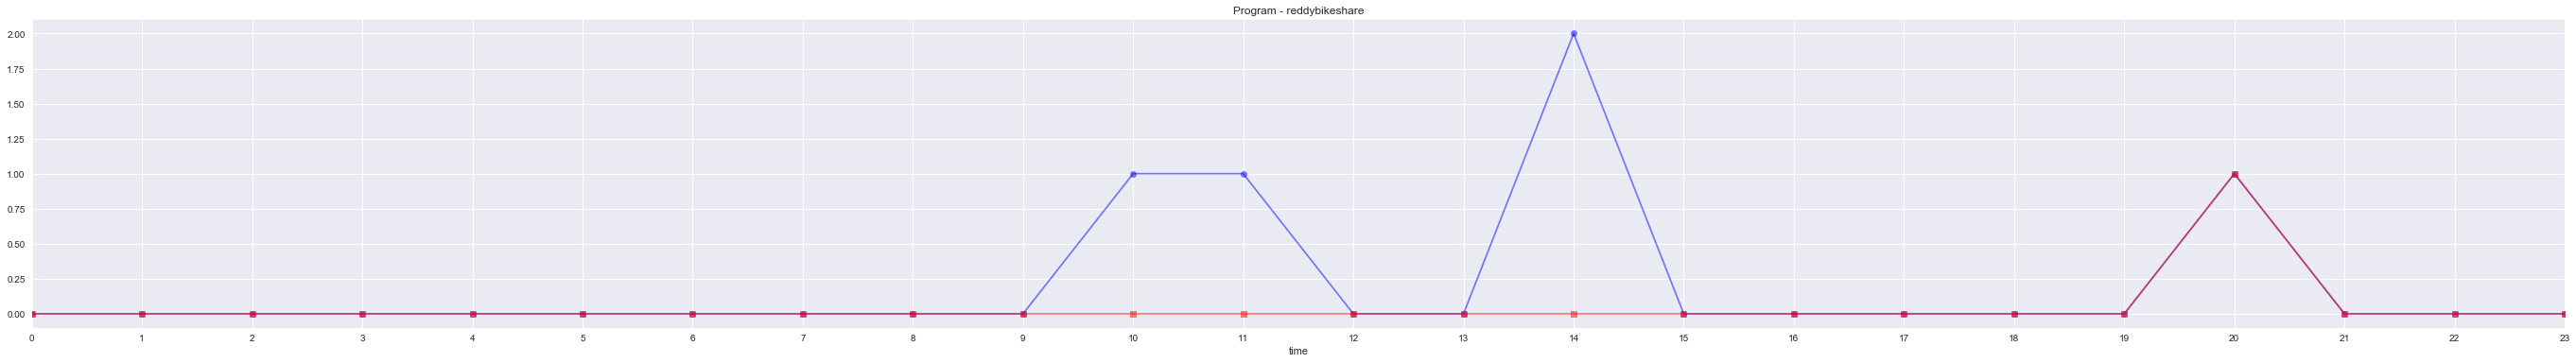

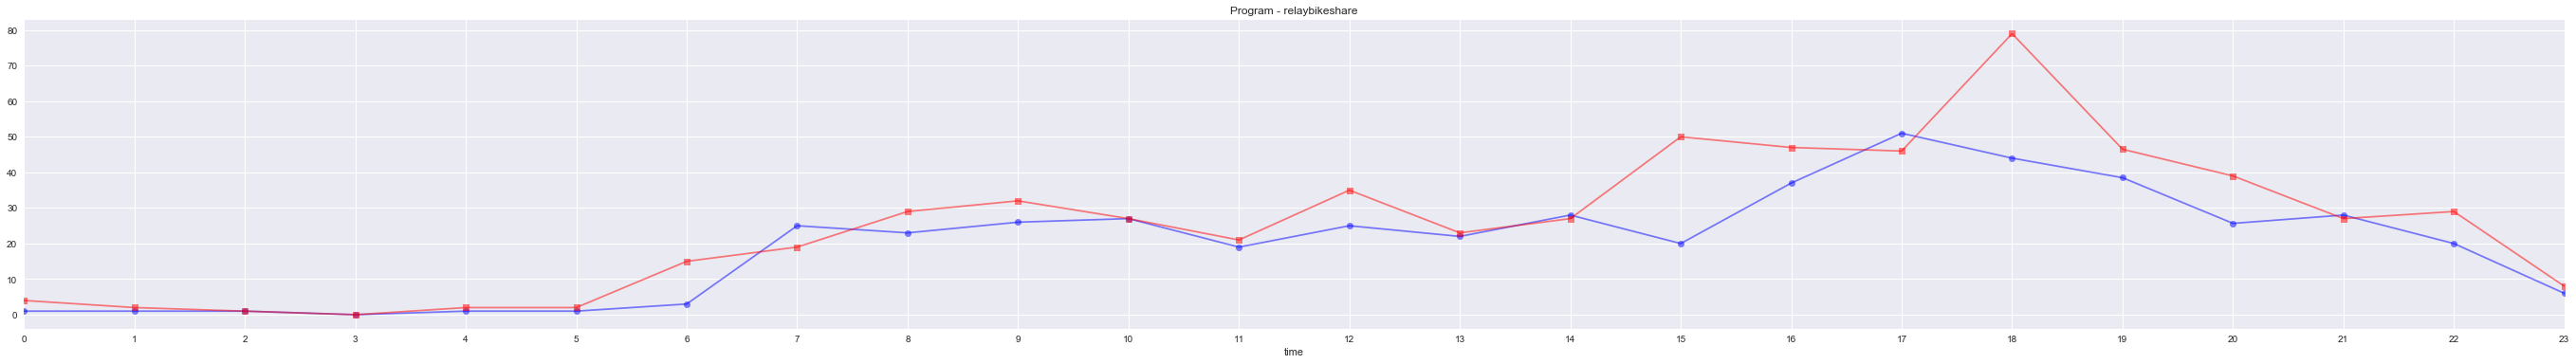

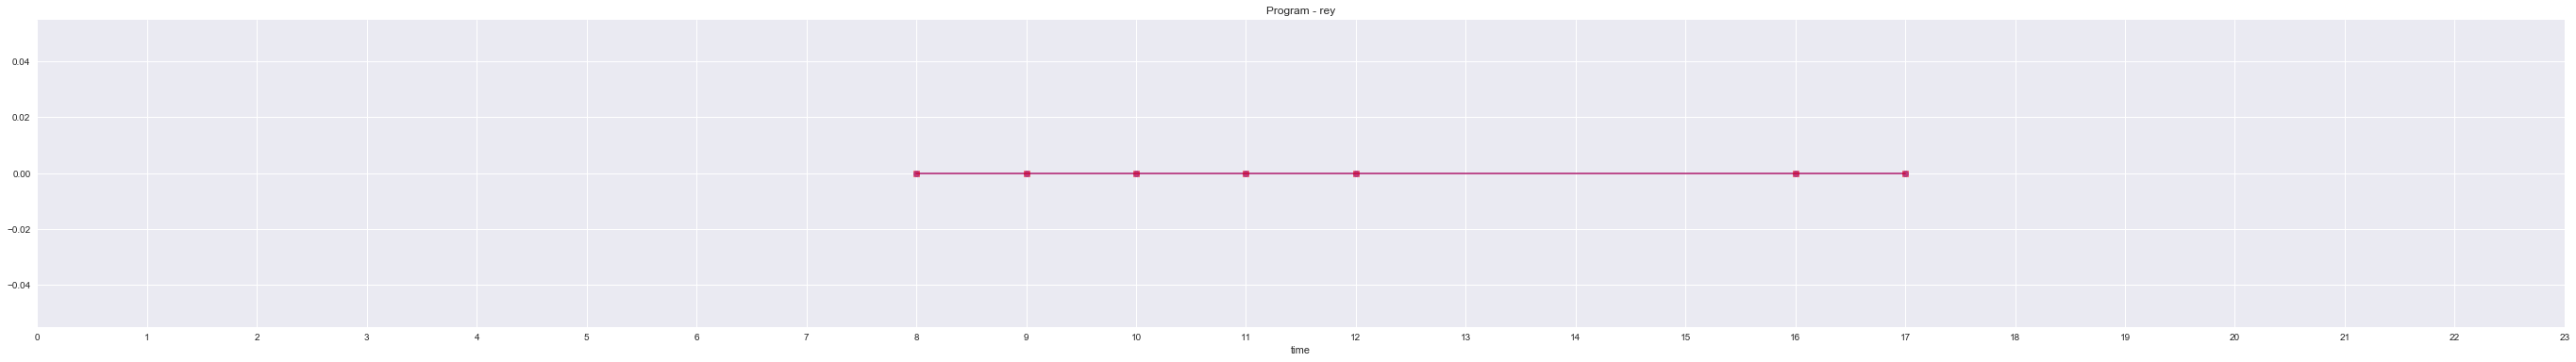

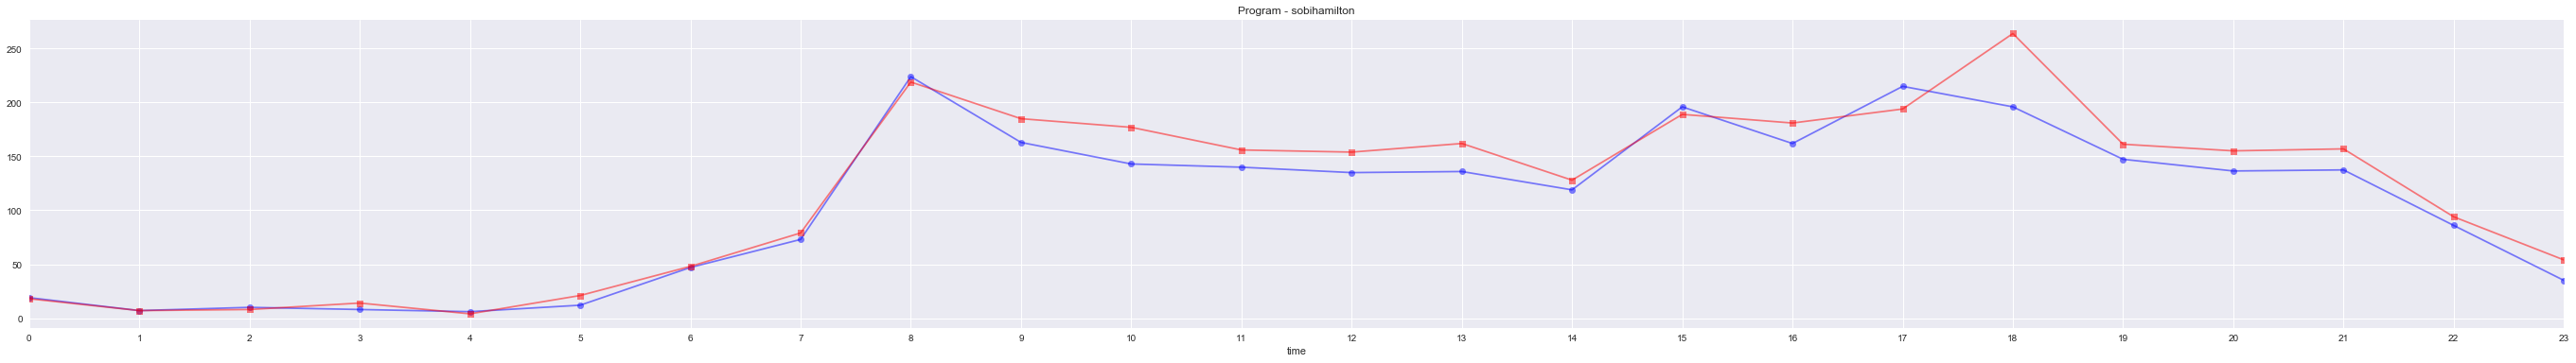

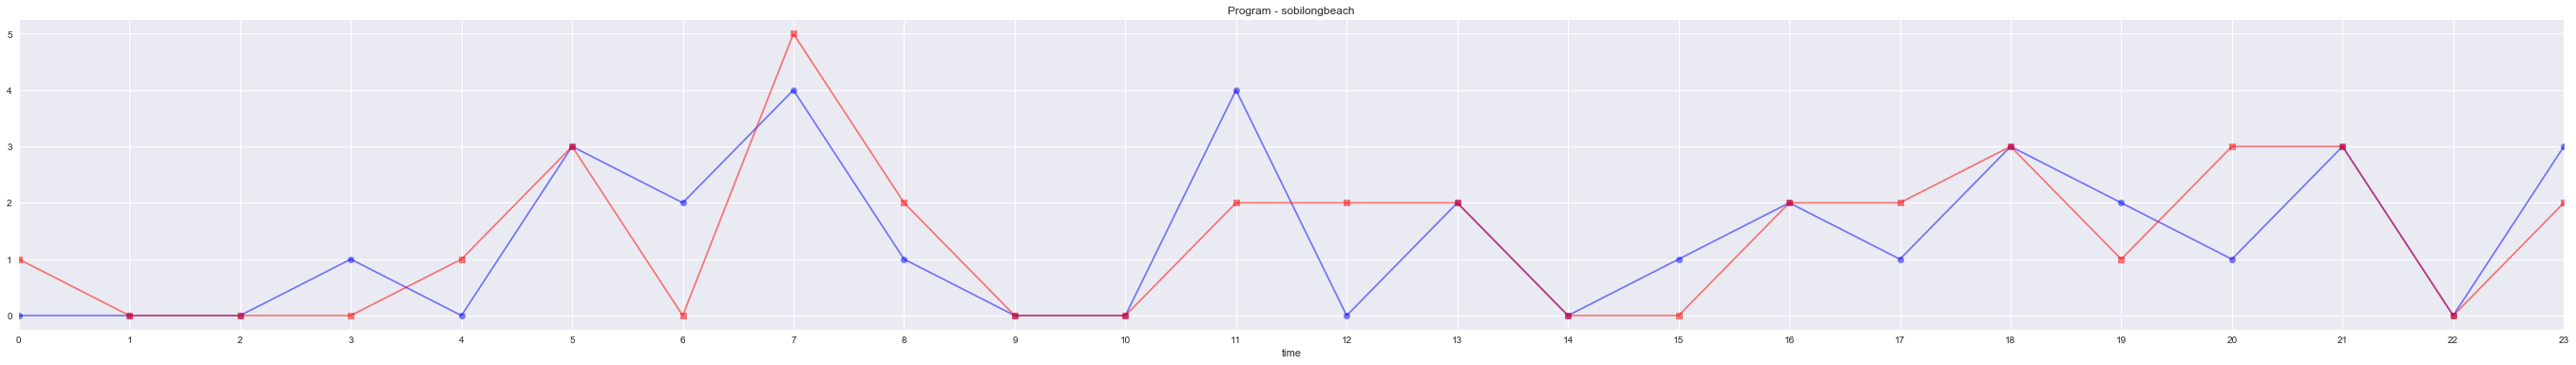

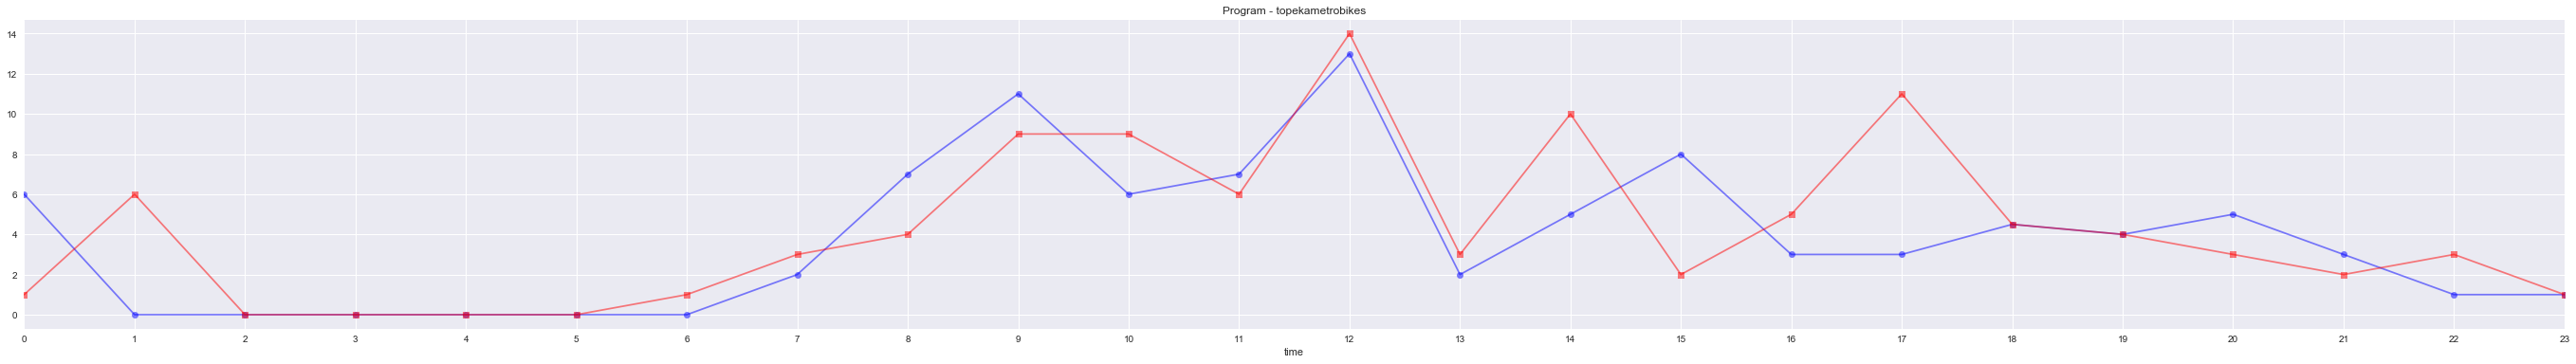

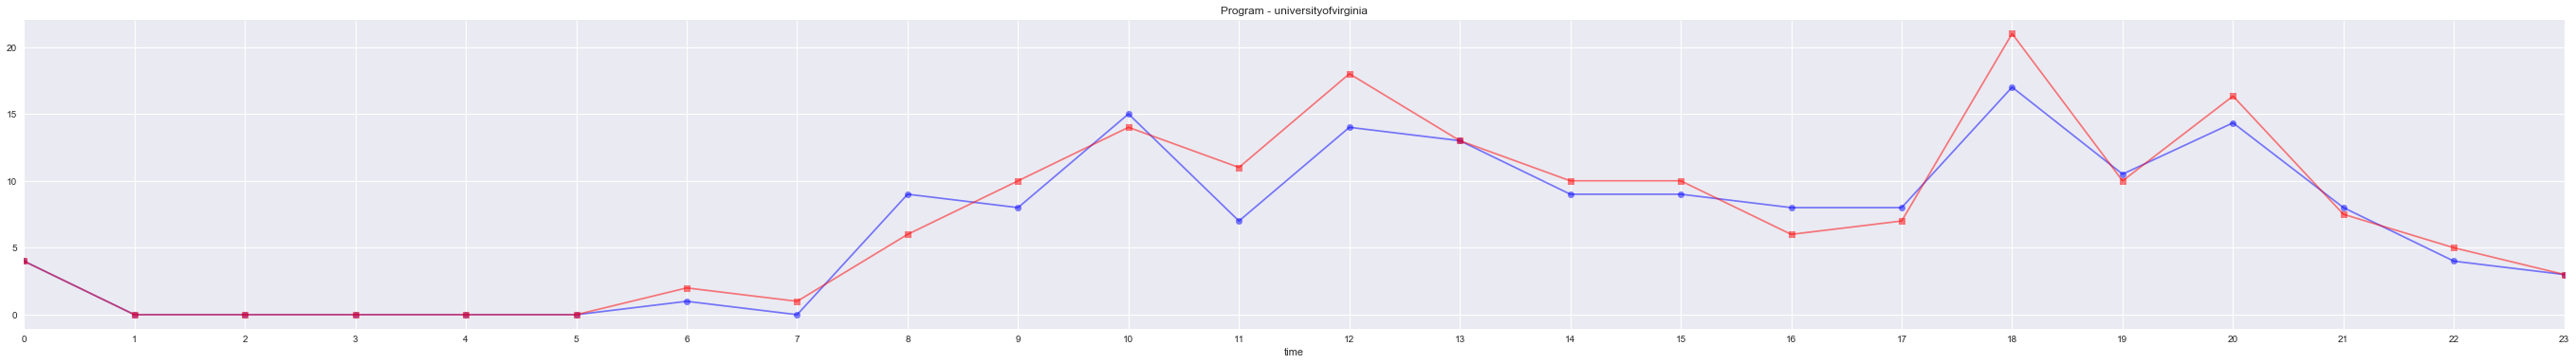

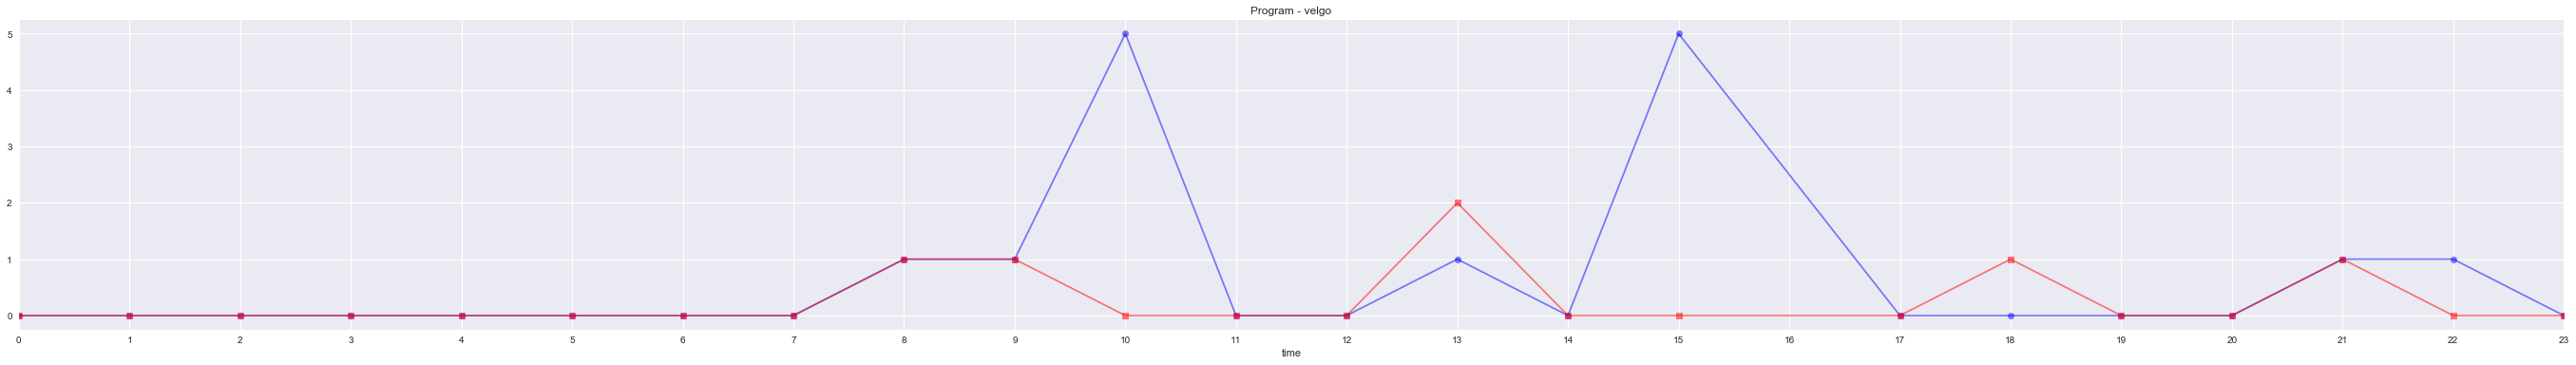

In [142]:
for pid in pd.unique(status_data_resample.program_id):
    fig, ax = plt.subplots(figsize=(48,6))
    data = status_data_resample[status_data_resample.program_id == pid].groupby([status_data_resample.time.dt.hour])
    data.trips_starting.sum().plot(kind ='line', color='b', alpha= 0.5, ax=ax, marker='o')
    data.trips_ending.sum().plot(kind ='line', color='r', alpha= 0.5, ax=ax, marker='s')
    title = 'Program - %s' % pid
    ax.set_title(title)
    x_ticks = range(0, 24)
    ax.set_xticks(x_ticks)
    plt.show()

Program ID			Trips Starting	Trips Ending	Net
ba                       	8786.0		8751.0		35.0


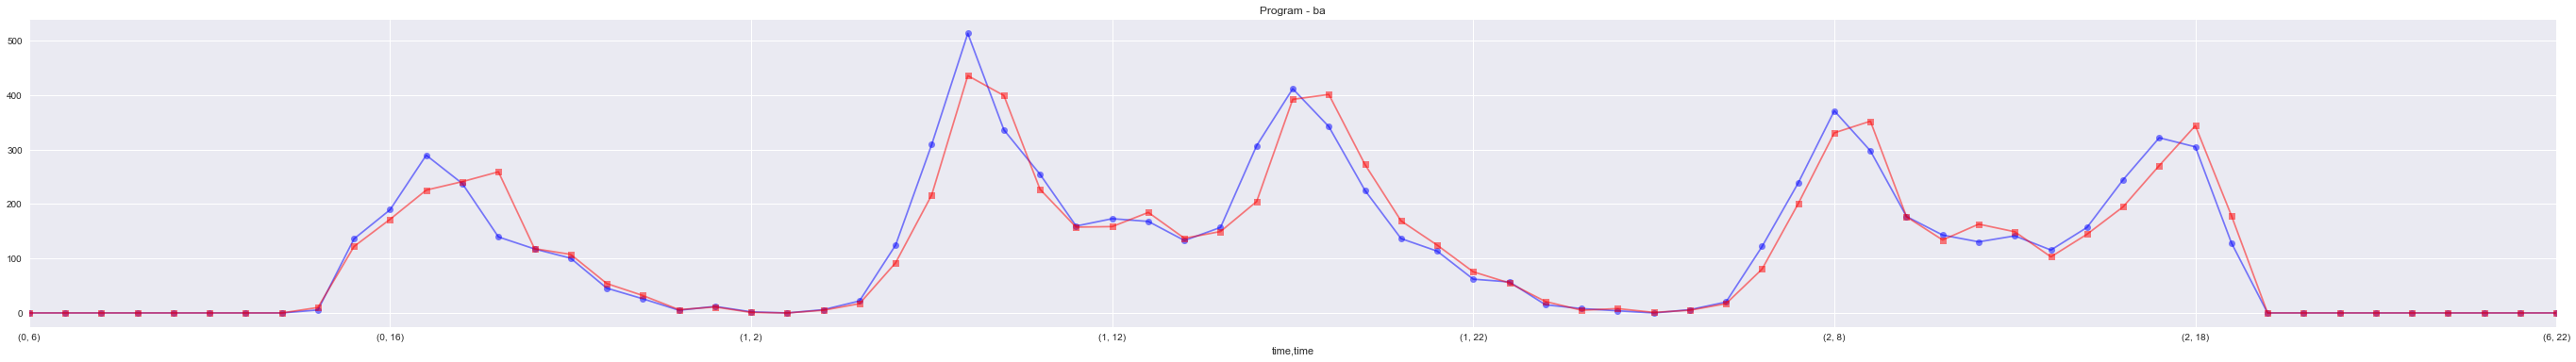

bcycledenver             	2029.0		2071.0		-42.0


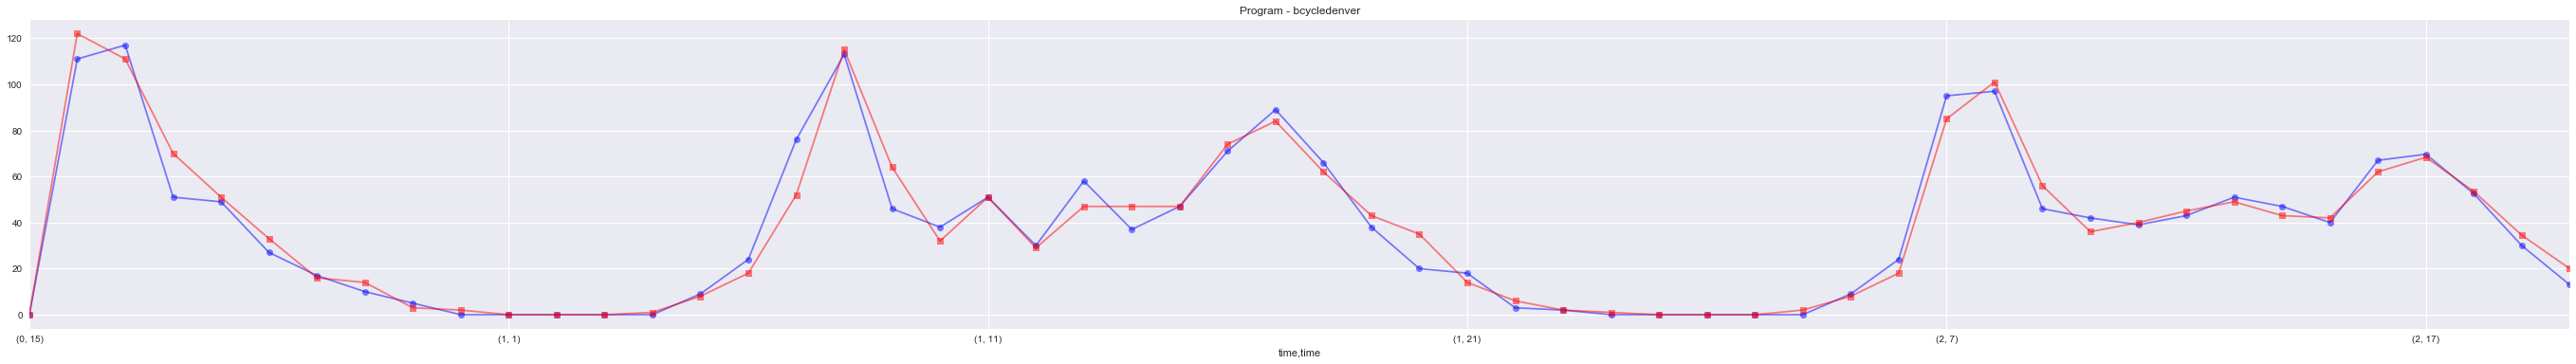

bcycleindego             	4815.0		4861.0		-46.0


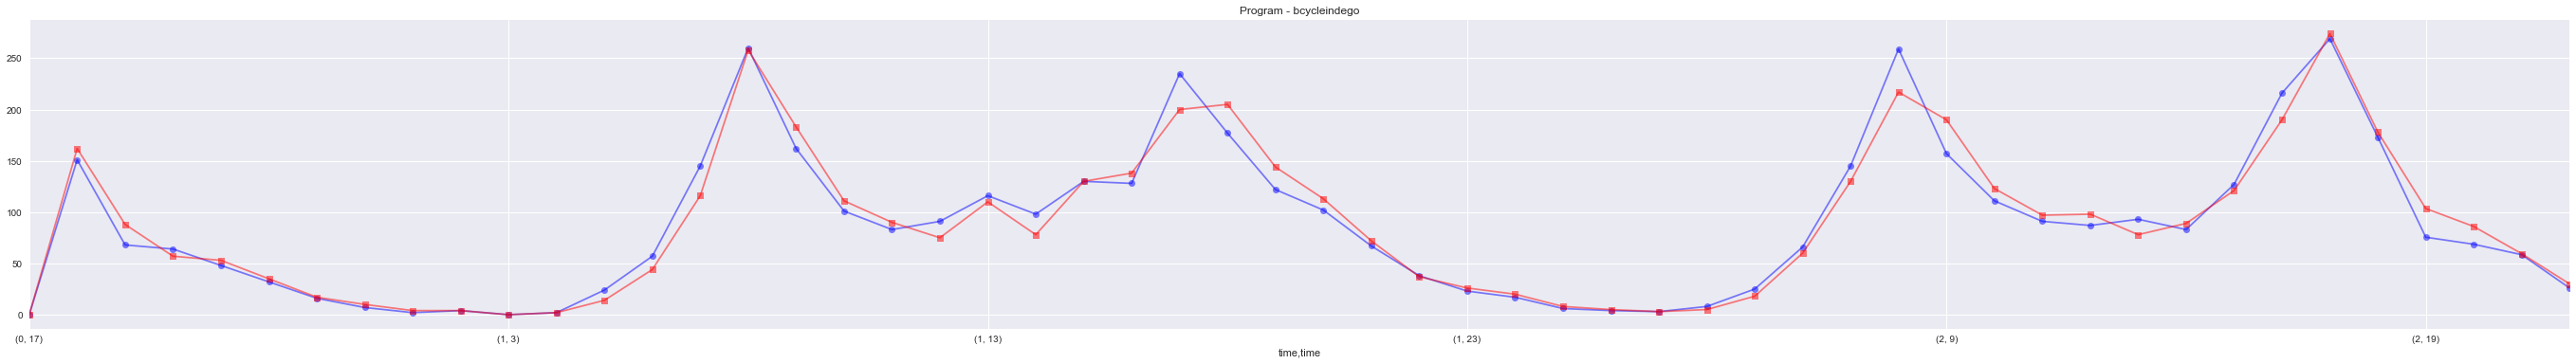

bcyclelametro            	2032.0		2045.0		-13.0


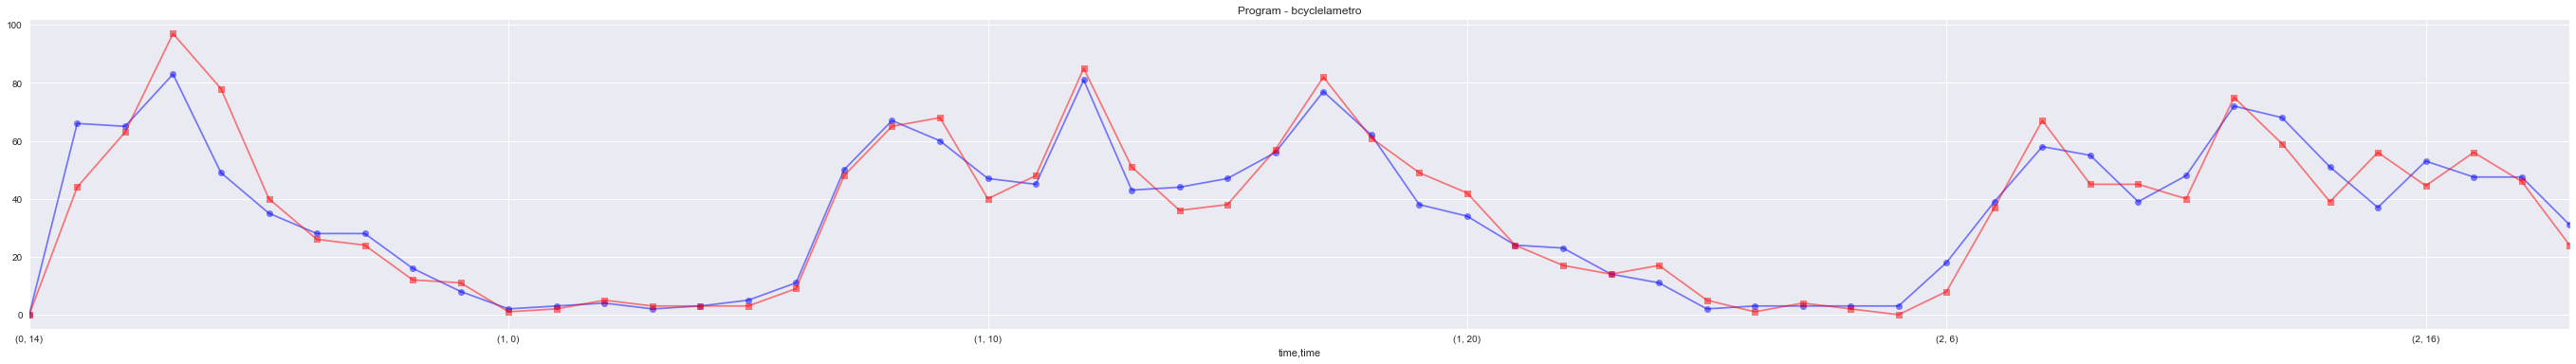

breezebikeshare          	1630.0		1736.0		-106.0


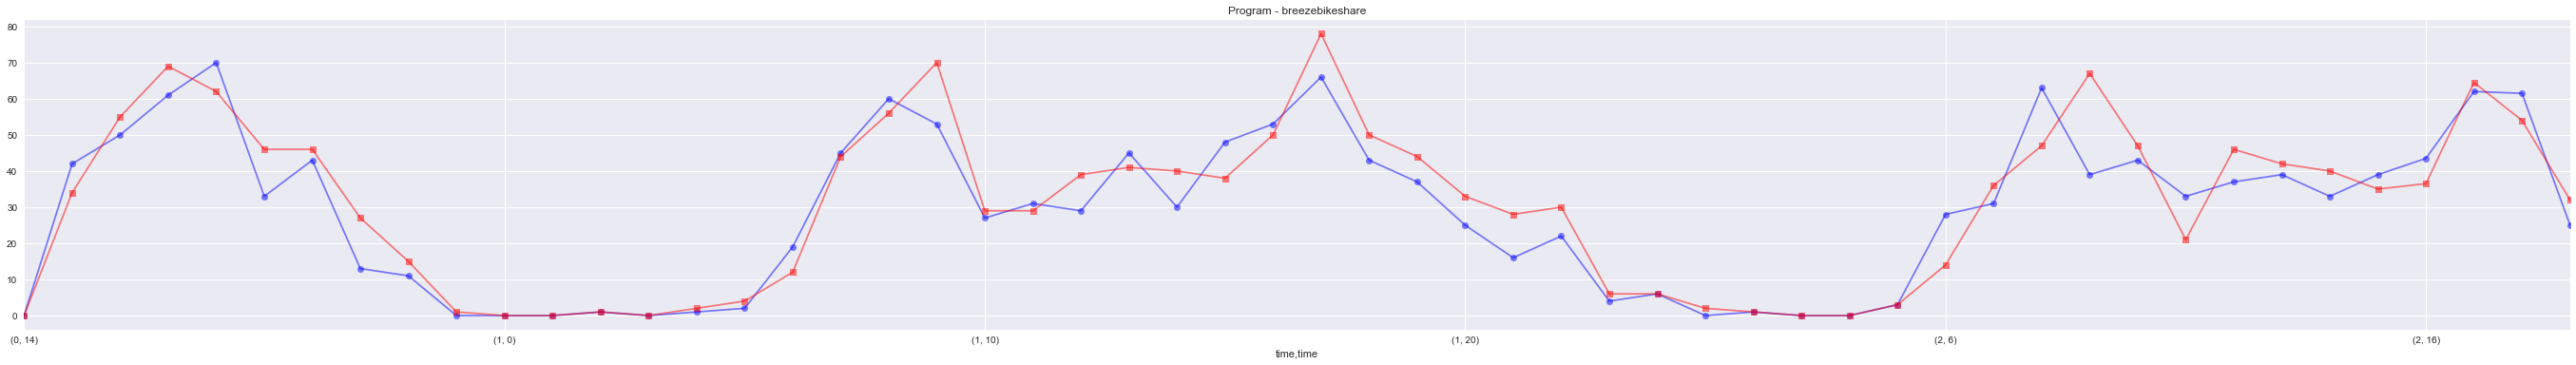

cabi                     	18549.0		18764.0		-215.0


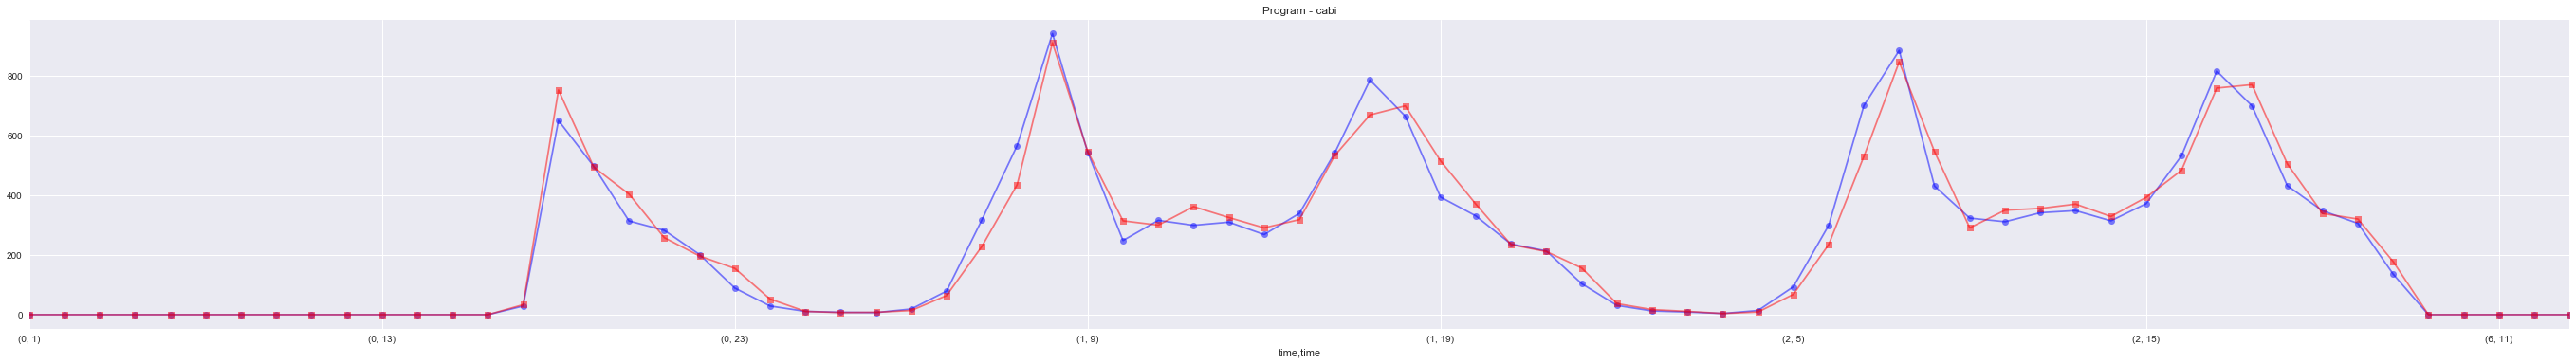

divvy                    	15014.0		15209.0		-195.0


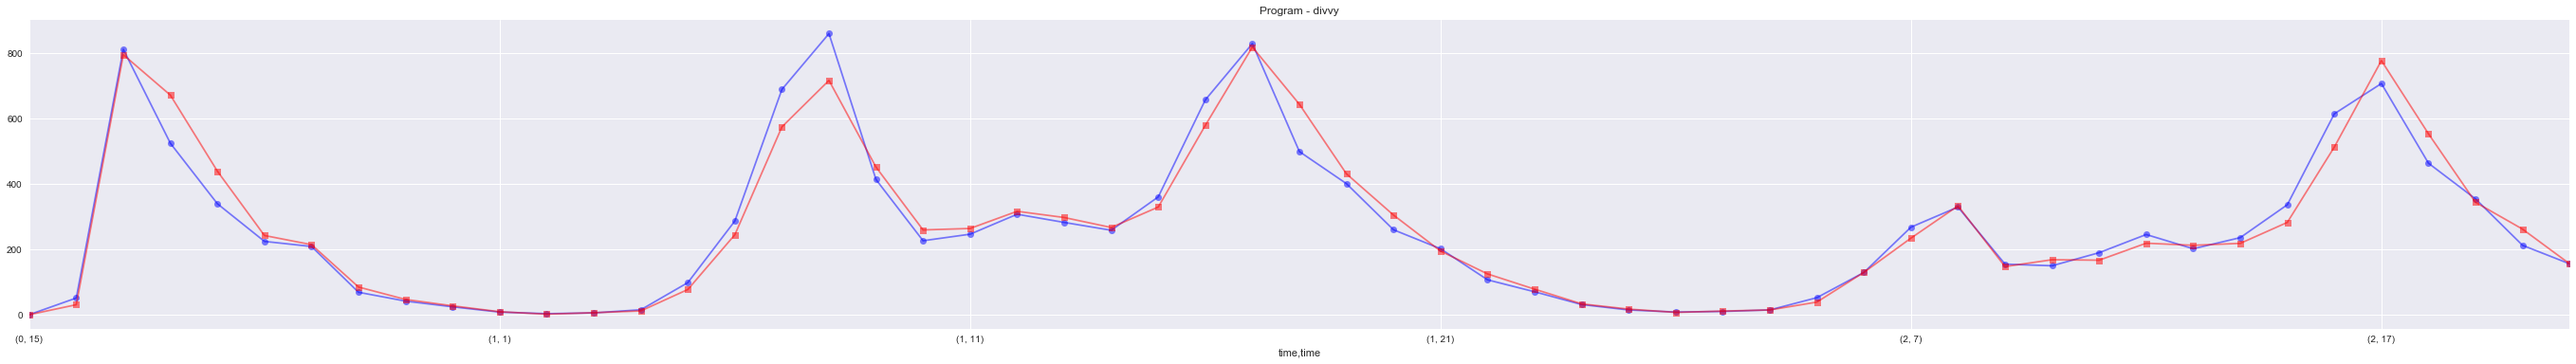

guad                     	1306.0		1550.0		-244.0


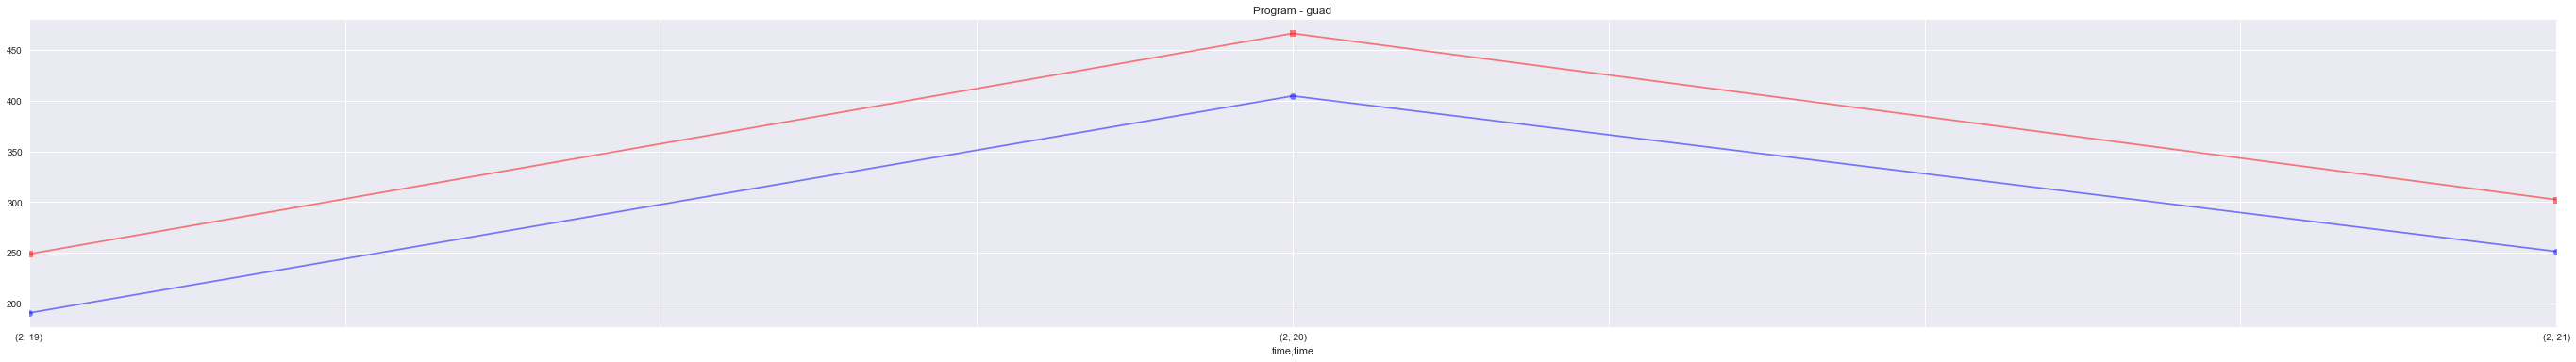

hubway                   	8020.0		7954.0		66.0


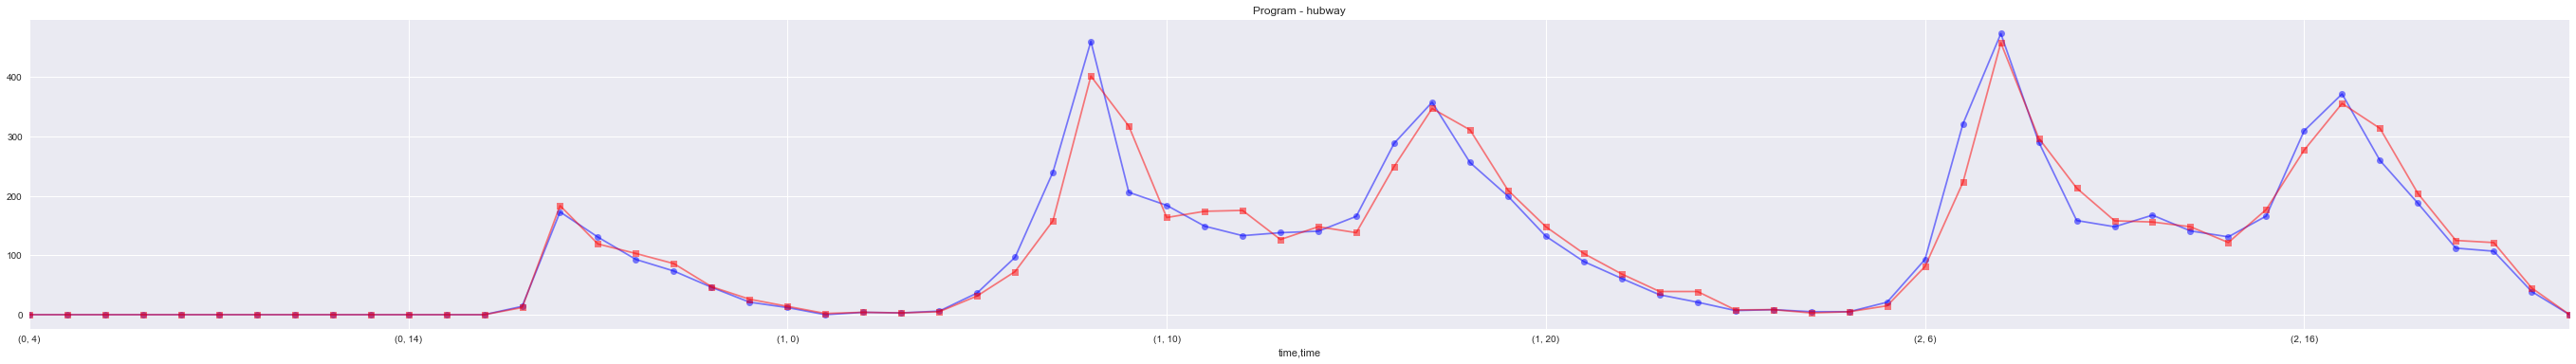

nyc                      	76871.0		77464.0		-593.0


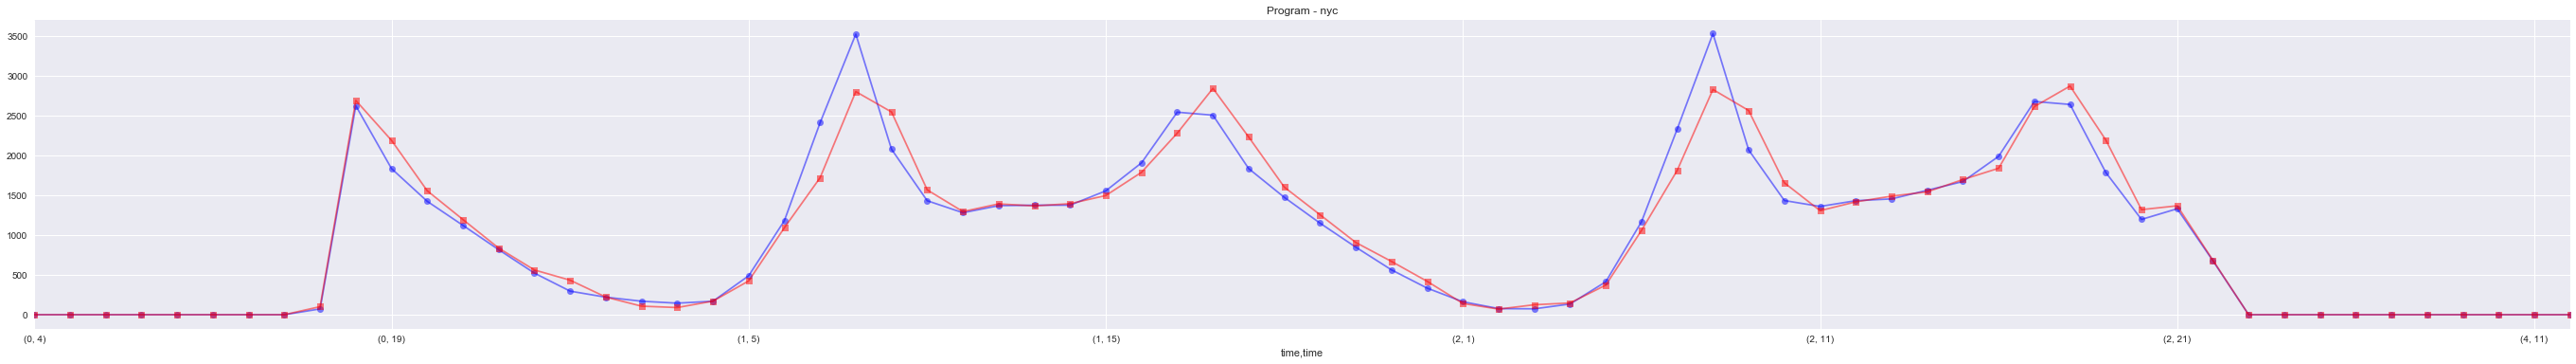

sobihamilton             	2608.0		2878.0		-270.0


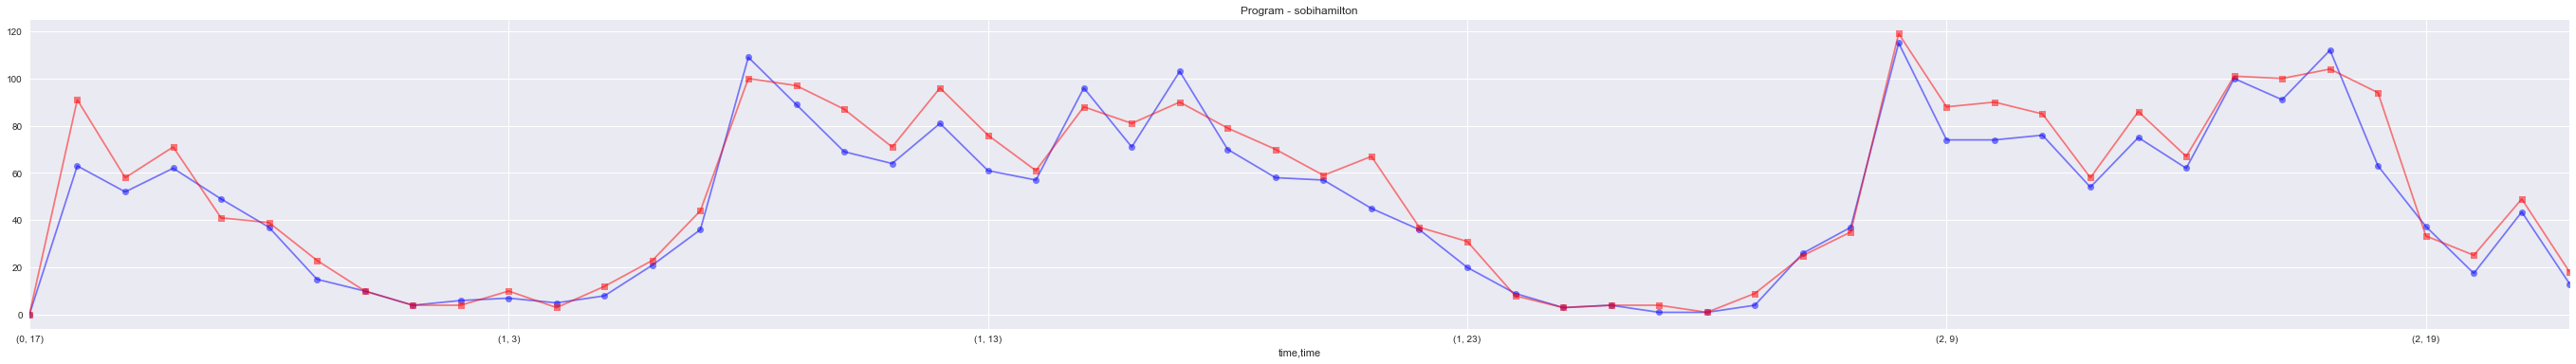

In [147]:
print('Program ID\t\t\tTrips Starting\tTrips Ending\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    if S > 1000:
        E = status_data[status_data.program_id == pid].trips_ending.sum()
        print('%s\t%s\t\t%s\t\t%s' % (pid.ljust(25), str(S), str(E), S-E))
        fig, ax = plt.subplots(figsize=(48,6))
        data = status_data_resample[status_data_resample.program_id == pid].groupby([status_data_resample.time.dt.dayofweek, status_data_resample.time.dt.hour])
        data.trips_starting.sum().plot(kind ='line', color='b', alpha= 0.5, ax=ax, marker='o')
        data.trips_ending.sum().plot(kind ='line', color='r', alpha= 0.5, ax=ax, marker='s')
        title = 'Program - %s' % pid
        ax.set_title(title)
        plt.show()

Program ID			Trips Starting	Trips Ending	Net
ba                       	8786.0		8751.0		35.0


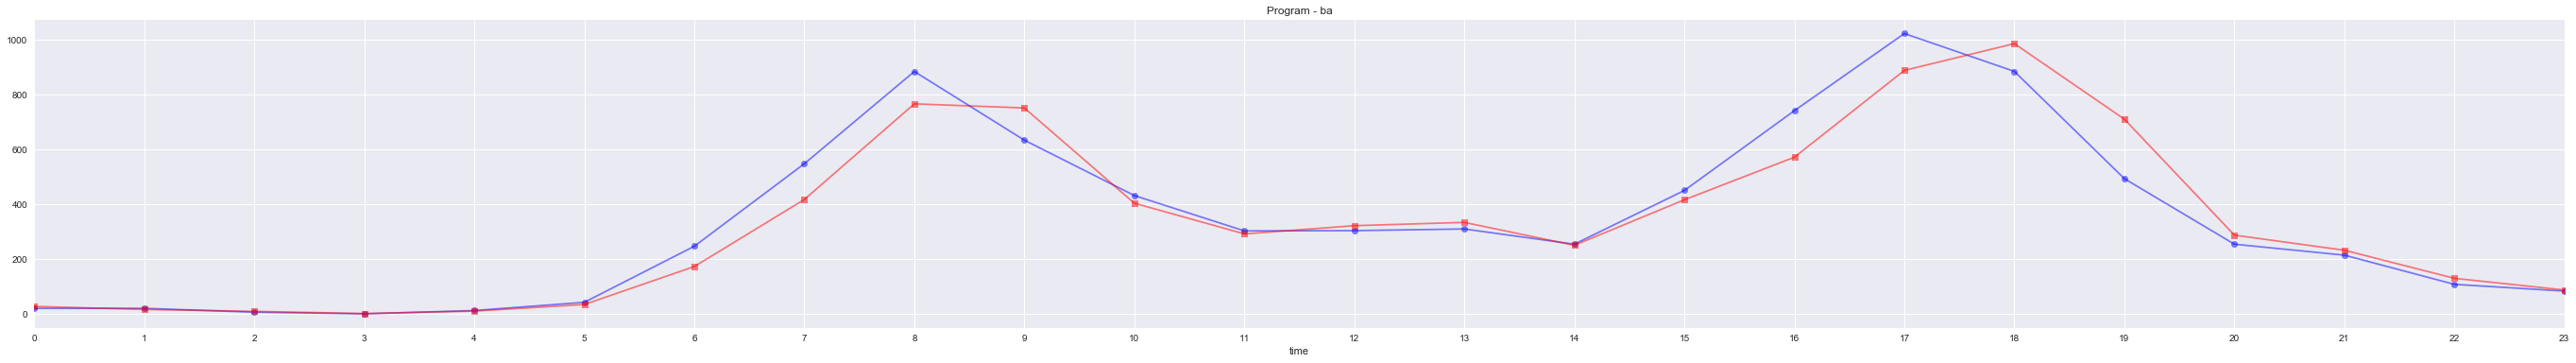

bcycledenver             	2029.0		2071.0		-42.0


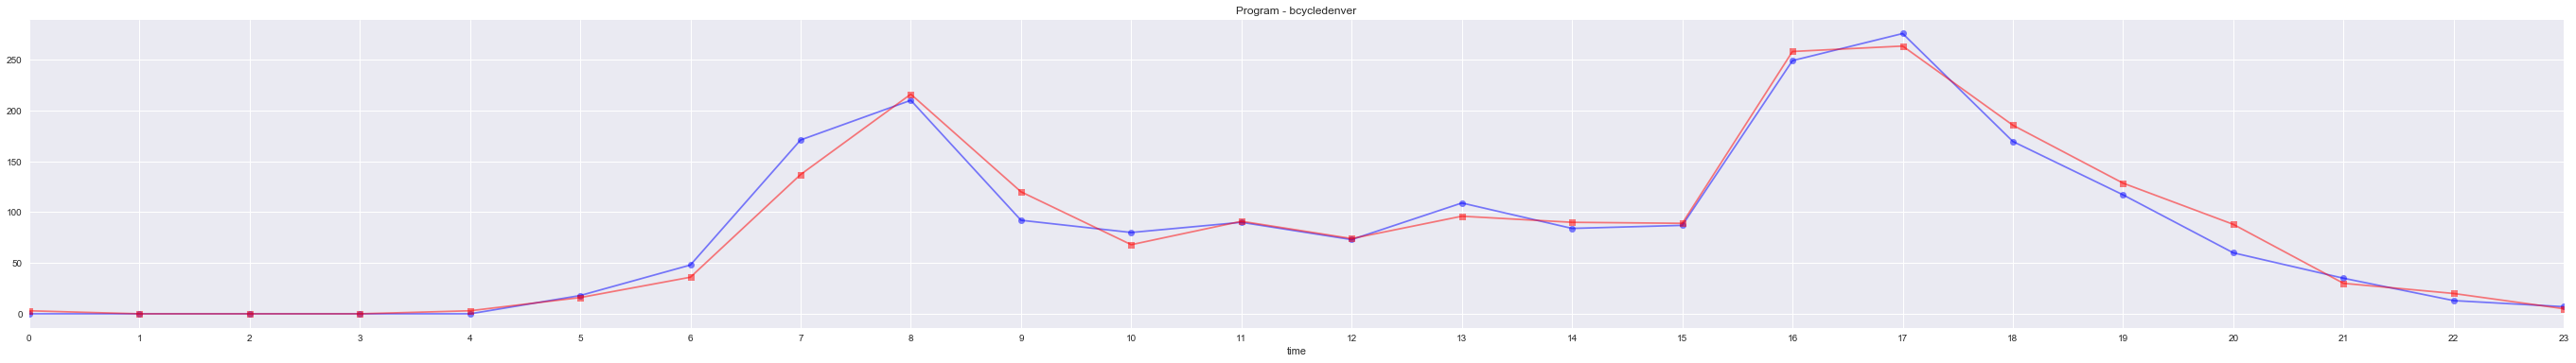

bcycleindego             	4815.0		4861.0		-46.0


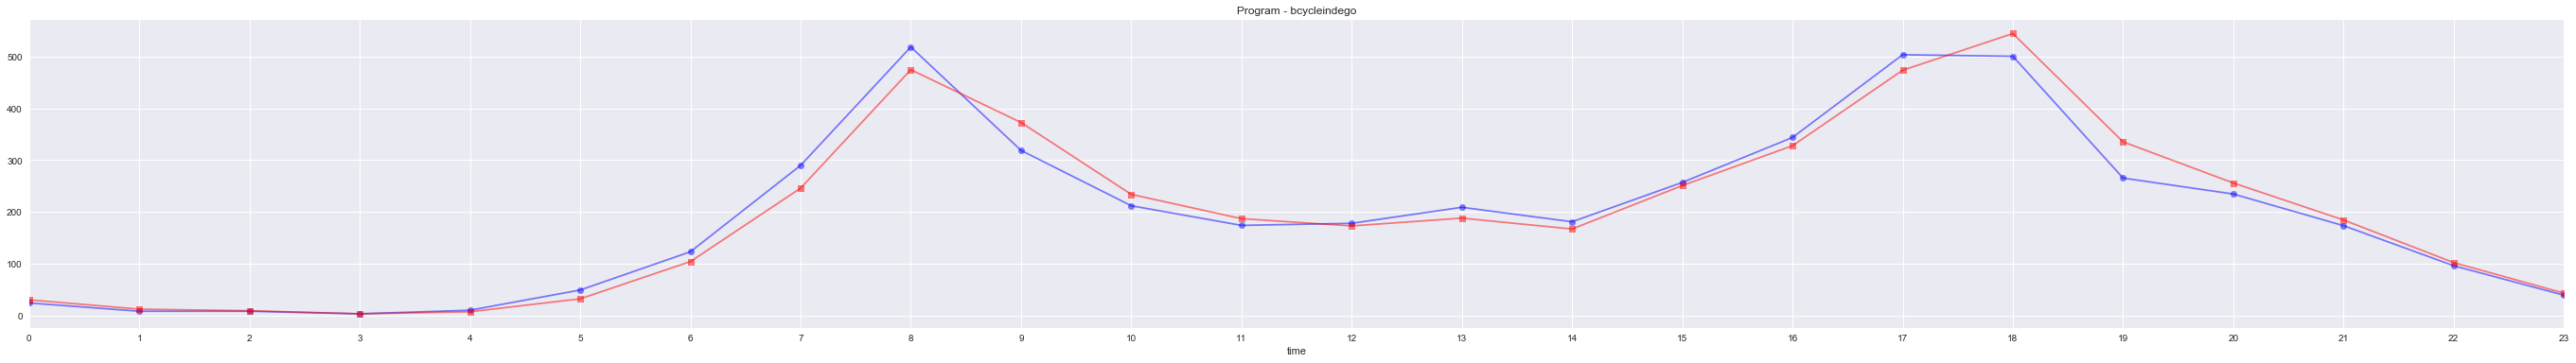

bcyclelametro            	2032.0		2045.0		-13.0


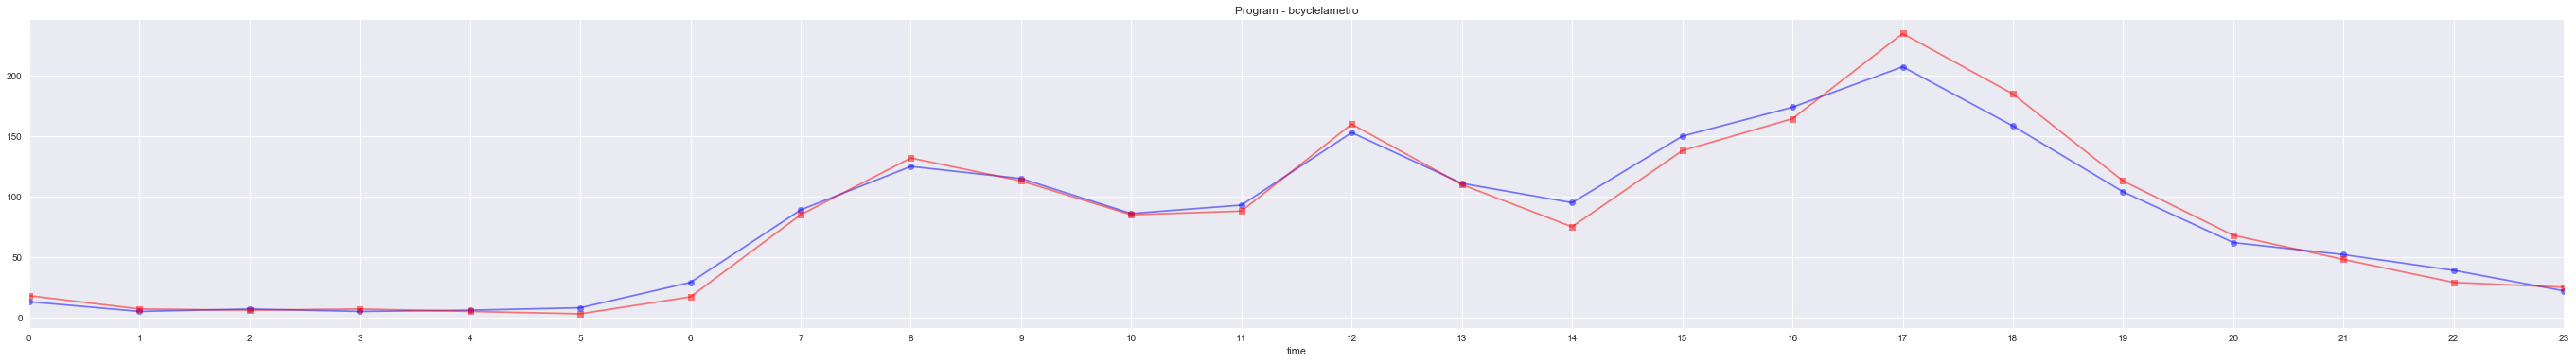

breezebikeshare          	1630.0		1736.0		-106.0


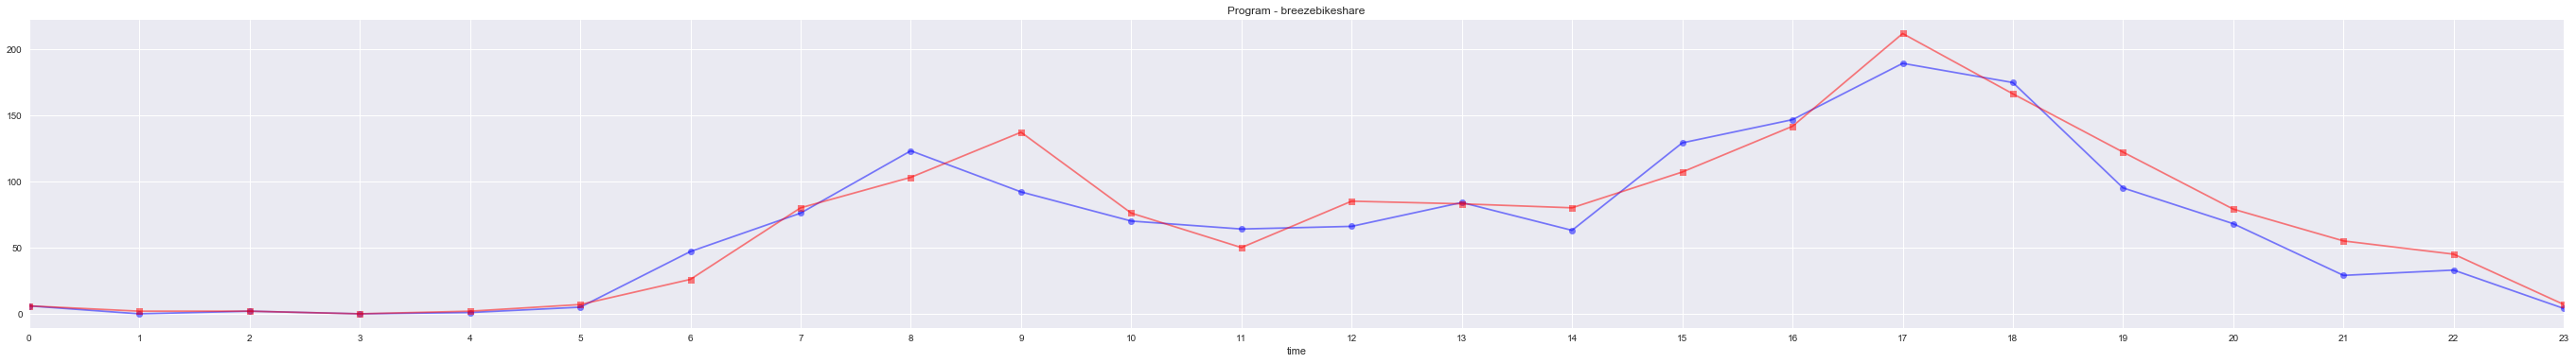

cabi                     	18549.0		18764.0		-215.0


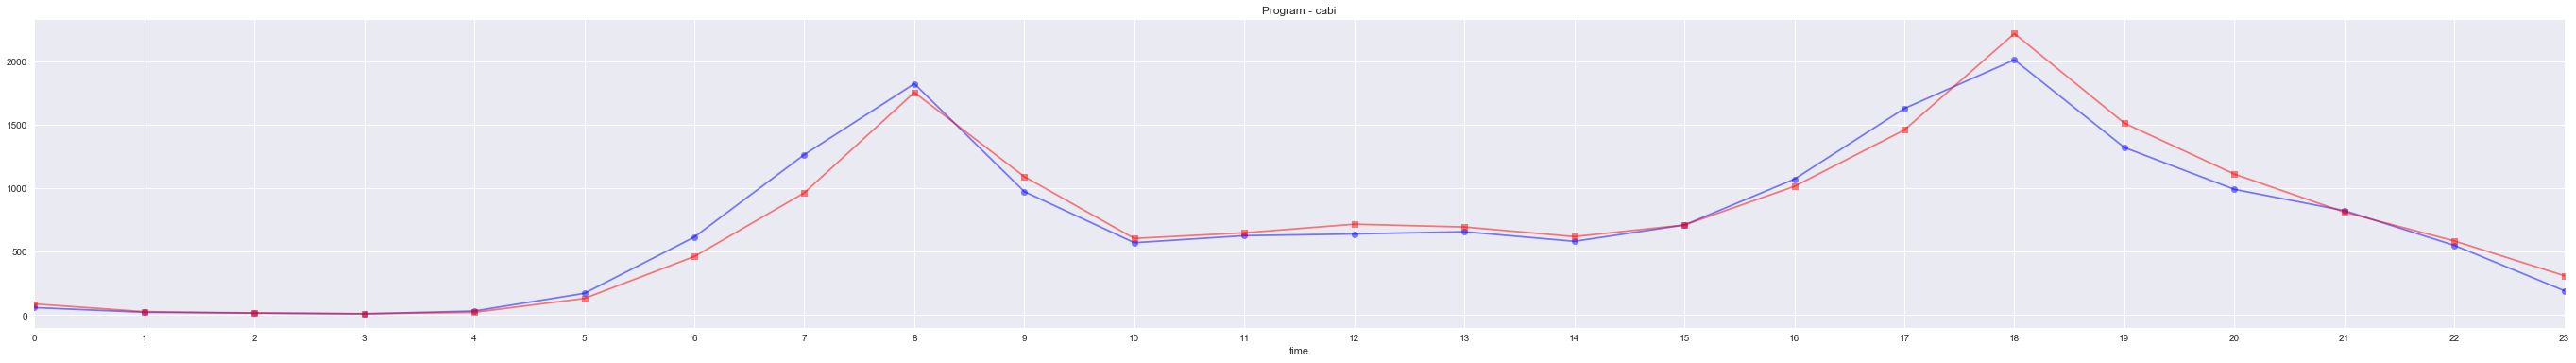

divvy                    	15014.0		15209.0		-195.0


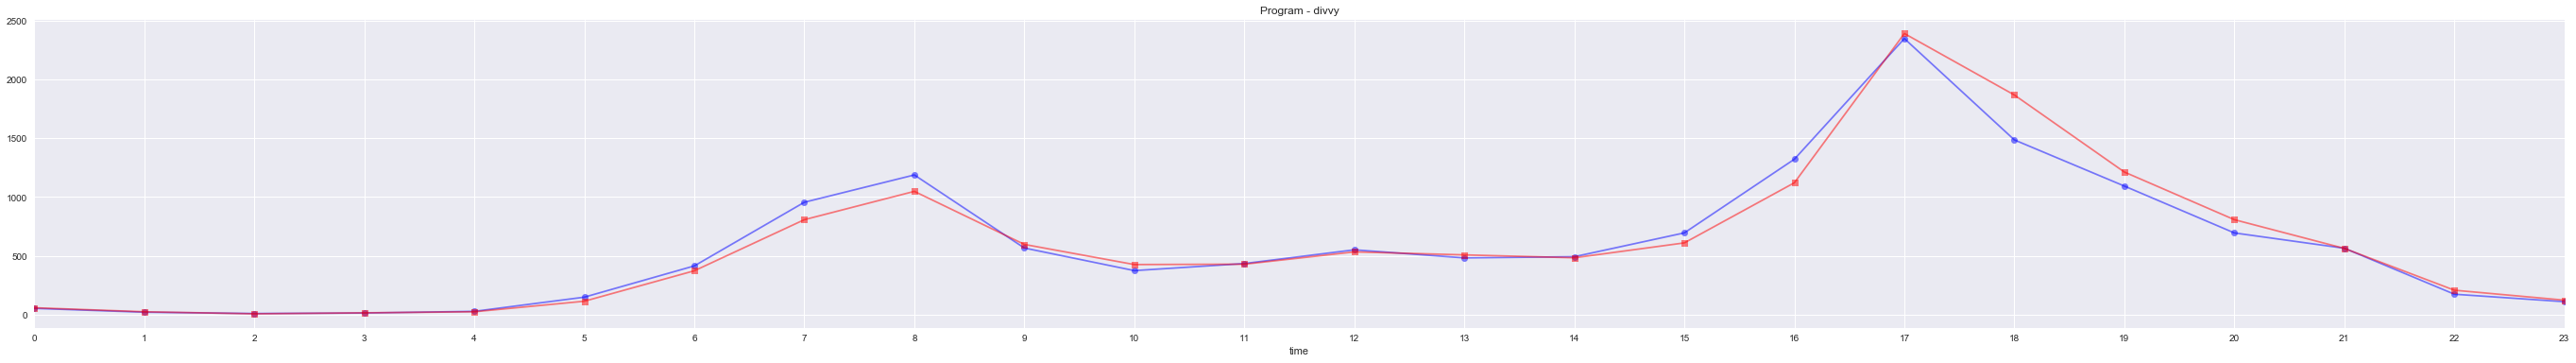

guad                     	1306.0		1550.0		-244.0


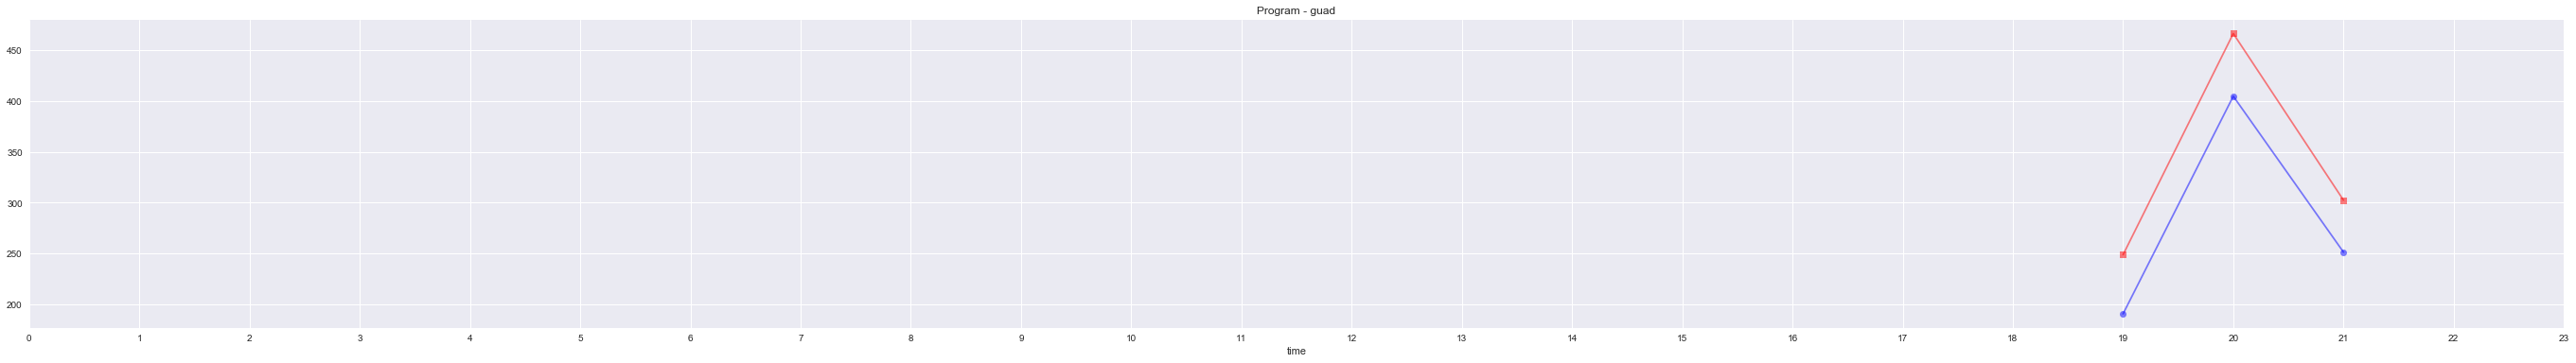

hubway                   	8020.0		7954.0		66.0


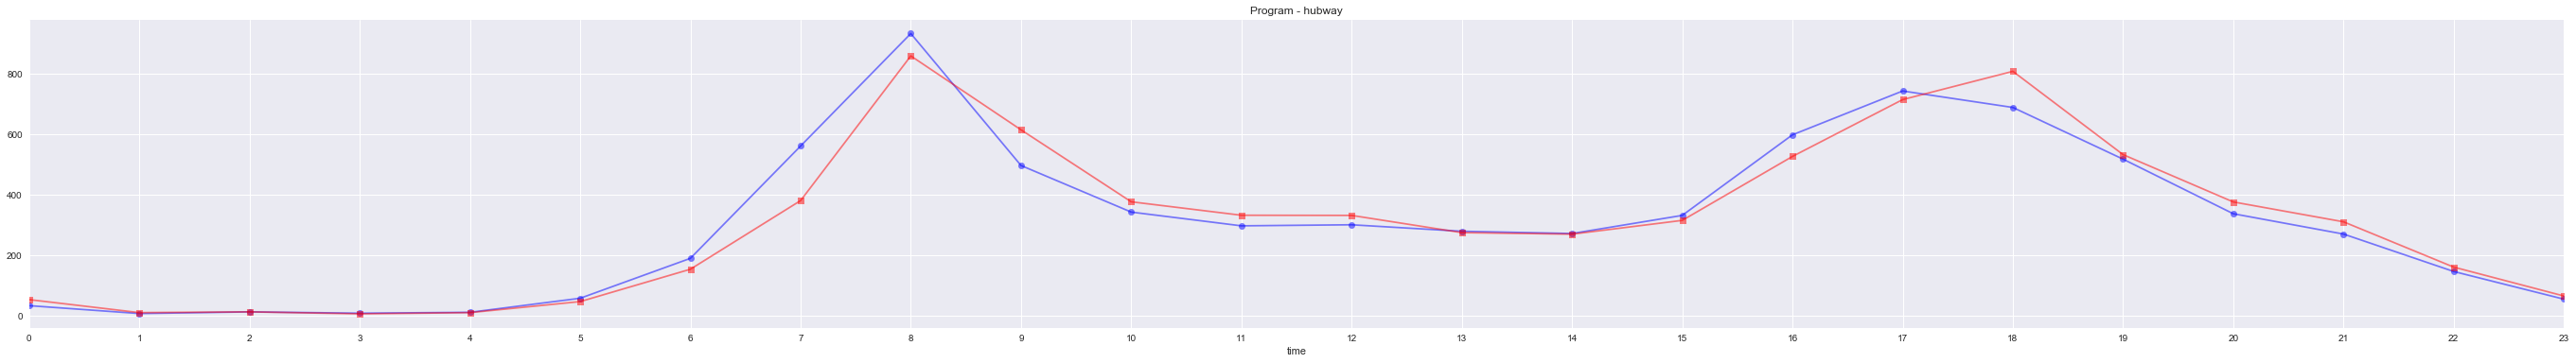

nyc                      	76871.0		77464.0		-593.0


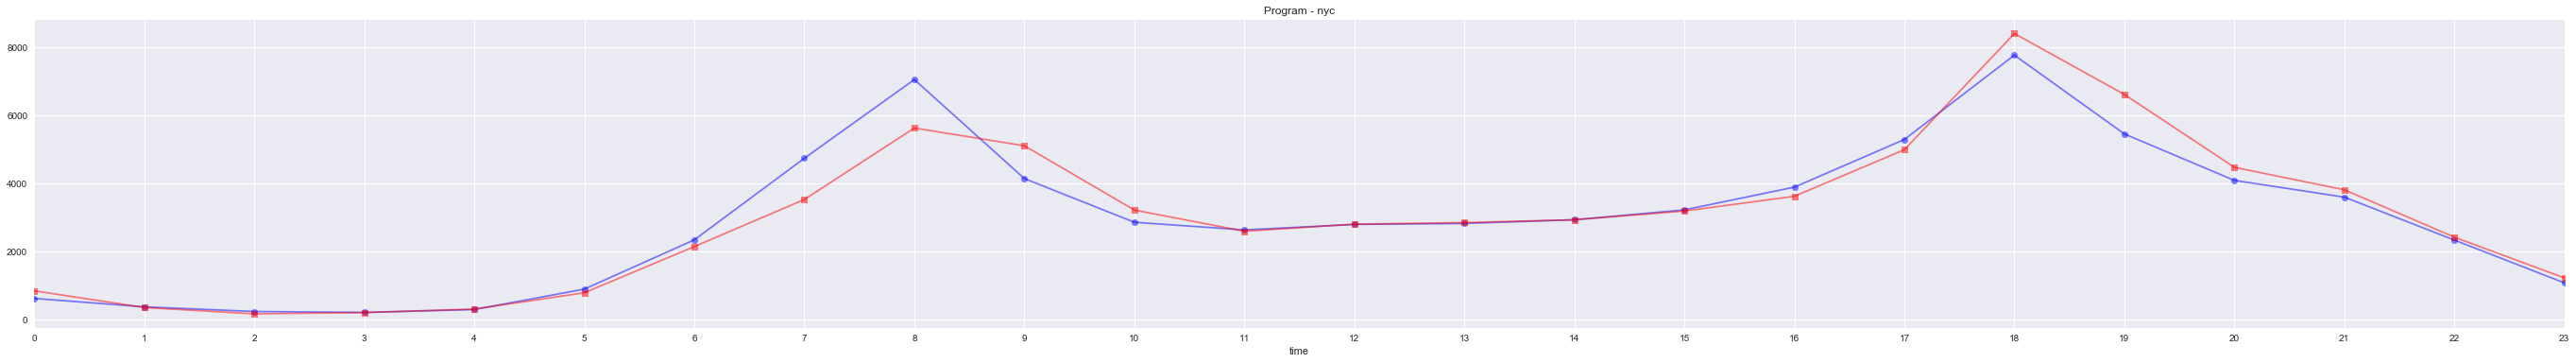

sobihamilton             	2608.0		2878.0		-270.0


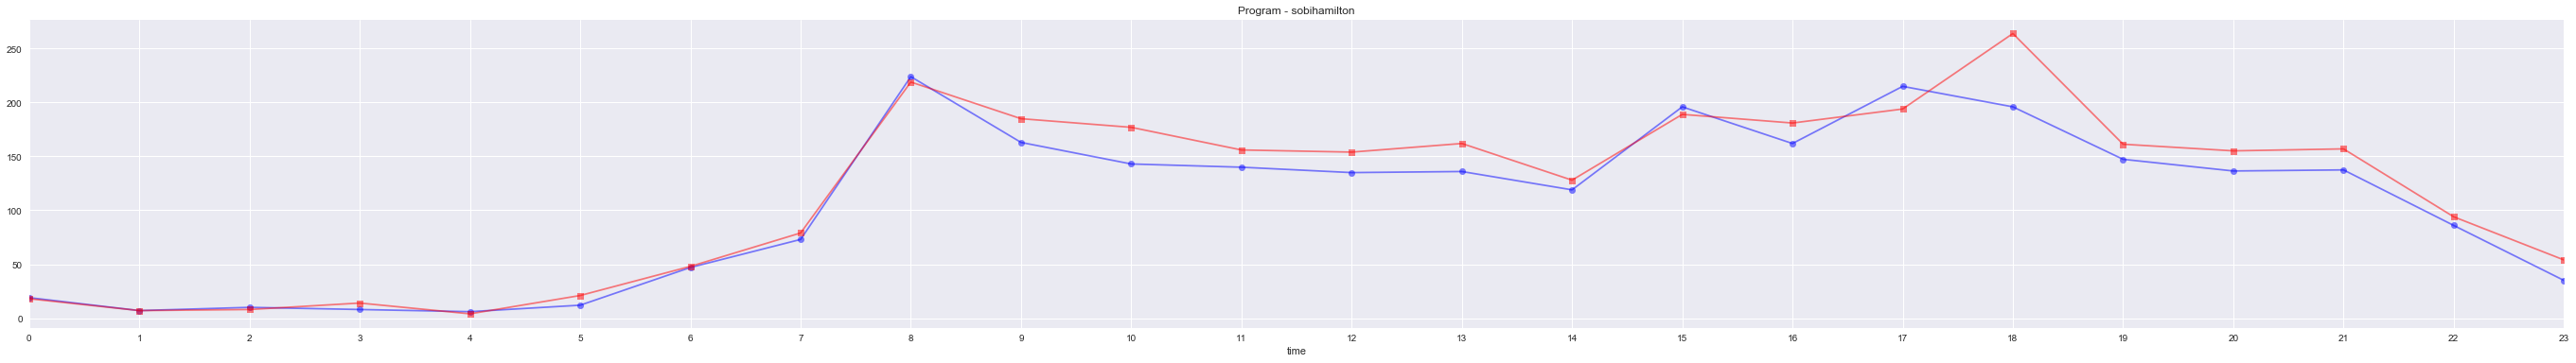

In [146]:
print('Program ID\t\t\tTrips Starting\tTrips Ending\tNet')
for pid in pd.unique(status_data.program_id):
    S = status_data[status_data.program_id == pid].trips_starting.sum()
    if S > 1000:
        E = status_data[status_data.program_id == pid].trips_ending.sum()
        print('%s\t%s\t\t%s\t\t%s' % (pid.ljust(25), str(S), str(E), S-E))
        fig, ax = plt.subplots(figsize=(48,6))
#         data = status_data_resample[status_data_resample.program_id == pid].groupby([status_data_resample.time.dt.dayofweek, status_data_resample.time.dt.hour])
        data = status_data_resample[status_data_resample.program_id == pid].groupby([status_data_resample.time.dt.hour])
        data.trips_starting.sum().plot(kind ='line', color='b', alpha= 0.5, ax=ax, marker='o')
        data.trips_ending.sum().plot(kind ='line', color='r', alpha= 0.5, ax=ax, marker='s')
        title = 'Program - %s' % pid
        ax.set_title(title)
        x_ticks = range(0, 24)
        ax.set_xticks(x_ticks)
        plt.show()